In [ ]:
import os
import pandas as pd
from datetime import datetime
import pytz
import ipywidgets as widgets
from IPython.display import display, HTML
from google.colab import drive

# 1 - Mount Google Drive
drive.mount('/content/drive')

# 2 - Set Pandas display options for human visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Path for storing decisions DataFrame
decisions_file = '/content/drive/MyDrive/userdecisions.csv'

# Initialize decisions DataFrame
decisions_df = pd.DataFrame(columns=['numero_controle_pncp', 'action', 'timestamp'])

# Load existing decisions if file exists
if os.path.exists(decisions_file):
    decisions_df = pd.read_csv(decisions_file)

# Store decision function
def store_decision(numero_controle_pncp, action):
    global decisions_df

    # Timestamp in Brasília timezone
    brasilia_tz = pytz.timezone('America/Sao_Paulo')
    timestamp_brasilia = datetime.now(brasilia_tz).strftime('%Y-%m-%d %H:%M:%S')

    new_row = pd.DataFrame({
        'numero_controle_pncp': [numero_controle_pncp],
        'action': [action],
        'timestamp': [timestamp_brasilia]
    })

    decisions_df = pd.concat([decisions_df, new_row], ignore_index=True)
    decisions_df.to_csv(decisions_file, index=False)

    print(f"Stored decision: {numero_controle_pncp} -> {action} at {timestamp_brasilia}")

# 3 - Present the user with buttons to choose which DataFrame to manage
df_choices = {'Top 40': 'top_40', 'Dispensa': 'top_40_dispensa', 'Now': 'top_40_now'}

choose_df_button = widgets.ToggleButtons(
    options=list(df_choices.keys()),
    description='Choose DataFrame:',
    disabled=False,
    button_style=''
)

display(choose_df_button)

# Global variable to keep track of the chosen DataFrame and current row index
chosen_df = None
current_row_index = 0

# Helper function to display a row in Trello-like layout
def display_row_in_trello_layout(row):
    print("\n\n" + "="*80)
    print(f"Numero Controle PNCP: {row['numero_controle_pncp']}")
    print(f"Numero Pregao/Dispensa: {row['title']}")
    print(f"Total Score: {row['total_score']}")
    print(f"Modalidade: {row['modalidade_licitacao_nome']}")
    print(f"Município: {row['municipio_nome']} / {row['uf']}")
    print(f"Unidade: {row['unidade_nome']} ({row['unidade_codigo']})")
    print(f"Orgao: {row['orgao_nome']} ({row['orgao_id']})")
    print(f"Valor Total: {row['valor_total_licitacao']}")
    print(f"Data Vigência: {row['data_fim_vigencia_iso8601']}")
    print(f"Count Line Items: {row['count_line_items']}")
    print(f"New Item URL: {row['new_item_url']}")
    print(f"Concatenated Words: {row['concatenated_words']}")
    print(f"Description: {row['description_normalized']}")
    print("="*80)


# 4 - Function to handle the chosen DataFrame and display the first row
def on_choose_df(change):
    global chosen_df, current_row_index
    df_name = df_choices[change['new']]
    chosen_df = globals()[df_name]
    current_row_index = 0
    display_row_in_trello_layout(chosen_df.iloc[current_row_index])
    display_decision_buttons()

choose_df_button.observe(on_choose_df, names='value')

# 5 - Present the user with decision buttons: Rejeitar, Analisar, Adiar
def display_decision_buttons():
    rejeitar_button = widgets.Button(description='Rejeitar')
    analisar_button = widgets.Button(description='Analisar')
    adiar_button = widgets.Button(description='Adiar')

    rejeitar_button.on_click(on_rejeitar_click)
    analisar_button.on_click(on_analisar_click)
    adiar_button.on_click(on_adiar_click)

    display(rejeitar_button, analisar_button, adiar_button)

# 6 - Functions for Rejeitar, Adiar (store decision and move to next row)
def on_rejeitar_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Rejeitar')
    move_to_next_row()

def on_adiar_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Adiar')
    move_to_next_row()

# Move to the next row and display it
def move_to_next_row():
    global current_row_index
    current_row_index += 1
    if current_row_index < len(chosen_df):
        display_row_in_trello_layout(chosen_df.iloc[current_row_index])
        display_decision_buttons()
    else:
        print("No more rows to display.")

# 7 - Function to handle Analisar (expand card and show detailed info)
def on_analisar_click(b):
    row = chosen_df.iloc[current_row_index]
    print("\n\n" + "="*80)
    print(f"Numero Controle: {row['numero_controle_pncp']}")
    # Here, expand with extra columns
    expanded_df = df_merged[df_merged['numero_controle_pncp'] == row['numero_controle_pncp']]
    print(expanded_df[['numeroItem', 'descricao_normalized', 'valorUnitarioEstimado', 'quantidade', 'valorTotal']])
    print("="*80)

    # Display additional buttons: Rejeitar, Adiar, and Cotar Produtos
    display_expanded_buttons()

# 8 - Present the user with "Cotar Produtos" button after Analisar
def display_expanded_buttons():
    cotar_produtos_button = widgets.Button(description='Cotar Produtos')
    rejeitar_button = widgets.Button(description='Rejeitar')
    adiar_button = widgets.Button(description='Adiar')

    cotar_produtos_button.on_click(on_cotar_produtos_click)
    rejeitar_button.on_click(on_rejeitar_click)
    adiar_button.on_click(on_adiar_click)

    display(cotar_produtos_button, rejeitar_button, adiar_button)

def on_cotar_produtos_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Cotar Produtos')
    move_to_next_row()

In [ ]:
import pandas as pd
import sqlite3
import unicodedata
import re
from google.colab import drive
import ipywidgets as widgets
from IPython.display import display, clear_output

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to the CSV and the database
csv_file_path = '/content/drive/MyDrive/suppliers_data.csv'
database_file_path = '/content/drive/MyDrive/supplier_database.db'

# Function to normalize Brazilian Portuguese keywords
def normalize_text(text):
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to save supplier info to CSV
def save_supplier_to_csv(supplier_info, file_path):
    df = pd.DataFrame([supplier_info])
    try:
        existing_df = pd.read_csv(file_path)
        updated_df = pd.concat([existing_df, df], ignore_index=True)
    except FileNotFoundError:
        updated_df = df
    updated_df.to_csv(file_path, index=False)
    print(f"Supplier data saved to {file_path}")

# Function to insert data into the database
def insert_keywords_into_db(supplier_info, db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Create the table if it doesn't exist
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS suppliers (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            company_name TEXT,
            contact_person TEXT,
            email TEXT,
            phone_number TEXT,
            address TEXT,
            supplier_type TEXT,
            tax_id TEXT,
            product_keywords TEXT,
            normalized_keywords TEXT,
            relationship_status TEXT
        )
    ''')

    # Insert supplier data
    cursor.execute('''
        INSERT INTO suppliers (
            company_name, contact_person, email, phone_number, address,
            supplier_type, tax_id, product_keywords, normalized_keywords, relationship_status
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        supplier_info['company_name'], supplier_info['contact_person'], supplier_info['email'],
        supplier_info['phone_number'], supplier_info['address'], supplier_info['supplier_type'],
        supplier_info['tax_id'], supplier_info['product_keywords'], supplier_info['normalized_keywords'],
        supplier_info['relationship_status']
    ))

    conn.commit()
    conn.close()
    print(f"Supplier data saved to database at {db_path}")

# Main supplier registration function
def register_supplier():
    supplier_info = {}

    # Collect basic info
    supplier_info['company_name'] = input("Enter the company name: ")
    supplier_info['contact_person'] = input("Enter the contact person's name: ")
    supplier_info['email'] = input("Enter the email address: ")

    while True:
        phone = input("Enter the phone number (digits only): ")
        if phone.isdigit():
            supplier_info['phone_number'] = phone
            break
        else:
            print("Please enter a valid phone number.")

    supplier_info['address'] = input("Enter the company address: ")

    # Supplier type selection
    supplier_types = ['Manufacturer', 'Distributor', 'Retailer', 'Service Provider']
    print("Select the type of supplier:")
    for i, stype in enumerate(supplier_types, 1):
        print(f"{i}. {stype}")

    while True:
        try:
            supplier_type_choice = int(input("Enter the number corresponding to the supplier type: "))
            if 1 <= supplier_type_choice <= len(supplier_types):
                supplier_info['supplier_type'] = supplier_types[supplier_type_choice - 1]
                break
            else:
                print("Invalid choice. Please select a number from the list.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # Tax ID
    while True:
        tax_id = input("Enter the tax ID (CNPJ/CPF): ")
        if len(tax_id) >= 11:
            supplier_info['tax_id'] = tax_id
            break
        else:
            print("Please enter a valid tax ID.")

    # Product keywords
    product_keywords = []
    normalized_keywords = []

    print("\nEnter product or service keywords offered by the supplier.")
    print("Type 'done' when finished.")

    while True:
        keyword = input("Enter a product keyword: ").strip().lower()
        if keyword == 'done':
            break
        elif keyword:
            normalized_keyword = normalize_text(keyword)
            product_keywords.append(keyword)
            normalized_keywords.append(normalized_keyword)

    supplier_info['product_keywords'] = ', '.join(product_keywords)
    supplier_info['normalized_keywords'] = ', '.join(normalized_keywords)

    return supplier_info

# Define status button function
def supplier_status_interface(supplier_info):
    # Buttons to select relationship status
    deeper_button = widgets.Button(description="Deeper Relationship Building", button_style='warning')
    sound_button = widgets.Button(description="Sound Partnership", button_style='success')
    status_output = widgets.Output()

    # Function to handle button clicks
    def on_deeper_clicked(b):
        supplier_info['relationship_status'] = 'Deeper Relationship Building'
        with status_output:
            clear_output()
            print("Selected Status: Deeper Relationship Building")
        save_supplier_to_csv(supplier_info, csv_file_path)
        insert_keywords_into_db(supplier_info, database_file_path)

    def on_sound_clicked(b):
        supplier_info['relationship_status'] = 'Sound Partnership'
        with status_output:
            clear_output()
            print("Selected Status: Sound Partnership")
        save_supplier_to_csv(supplier_info, csv_file_path)
        insert_keywords_into_db(supplier_info, database_file_path)

    # Link buttons to event handlers
    deeper_button.on_click(on_deeper_clicked)
    sound_button.on_click(on_sound_clicked)

    # Display buttons and output
    display(deeper_button, sound_button, status_output)

# Main execution
supplier = register_supplier()
supplier_status_interface(supplier)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the company name: teste
Enter the contact person's name: teste
Enter the email address: tata
Enter the phone number (digits only): 16666
Enter the company address: 1555
Select the type of supplier:
1. Manufacturer
2. Distributor
3. Retailer
4. Service Provider
Enter the number corresponding to the supplier type: 2
Enter the tax ID (CNPJ/CPF): 15555
Please enter a valid tax ID.
Enter the tax ID (CNPJ/CPF): 83983915000157

Enter product or service keywords offered by the supplier.
Type 'done' when finished.
Enter a product keyword: teste
Enter a product keyword: done


Button(button_style='warning', description='Deeper Relationship Building', style=ButtonStyle())

Button(button_style='success', description='Sound Partnership', style=ButtonStyle())

Output()

Supplier data saved to /content/drive/MyDrive/suppliers_data.csv
Supplier data saved to database at /content/drive/MyDrive/supplier_database.db


In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path for the CSV template
template_path = '/content/drive/MyDrive/supplier_info_template.csv'

# Create a DataFrame with the necessary columns
template_data = {
    "company_name": [],
    "contact_person": [],
    "email": [],
    "phone_number": [],
    "address": [],
    "supplier_type": [],
    "tax_id": [],
    "product_keywords": []
}

template_df = pd.DataFrame(template_data)

# Save the DataFrame to a CSV file
template_df.to_csv(template_path, index=False)

print(f"CSV template created at: {template_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV template created at: /content/drive/MyDrive/supplier_info_template.csv


# Edital extract

In [ ]:
import re
import os

def windows_to_python_path(windows_path):
    """
    Converts a Windows file path to a format Python can read and mounts Google Drive (if applicable).

    Args:
      windows_path: The file path in Windows format.

    Returns:
      The file path in Python format, ready to be used.
    """
    # Normalize the path for the operating system format
    normalized_path = os.path.normpath(windows_path)

    # Convert to Google Drive format (if applicable)
    drive_path = windows_to_drive_path(normalized_path)
    if drive_path:
        return drive_path
    else:
        # If it's not a Google Drive path, return the normalized path
        return normalized_path

def windows_to_drive_path(windows_path):
    """
    Converts a Windows file path to Google Drive format if it matches.

    Args:
      windows_path: The file path in Windows format.

    Returns:
      The file path in Google Drive format, or None if it's not a Drive path.
    """
    # Adjusted regex to match Google Drive paths
    match = re.match(r"[A-Za-z]:\\Meu Drive\\(.*)", windows_path)
    if match:
        drive_path = '/content/drive/MyDrive/' + match.group(1).replace("\\", "/")
        return drive_path
    else:
        return None

# Prompt user for input and use the input path (this accepts paths with backslashes)
windows_path = input("Enter a Windows file path: ")

# Convert the path
python_path = windows_to_python_path(windows_path)

# Print the converted path
print(python_path)


In [ ]:
import re
import os
from google.colab import drive
import pdfplumber
import pandas as pd

def windows_to_python_path(windows_path):
    """
    Converts a Windows file path to a format Python can read and mounts Google Drive (if applicable).

    Args:
      windows_path: The file path in Windows format.

    Returns:
      The file path in Python format, ready to be used.
    """
    # Normalize the path for the operating system format
    normalized_path = os.path.normpath(windows_path)

    # Convert to Google Drive format (if applicable)
    drive_path = windows_to_drive_path(normalized_path)
    if drive_path:
        # Mount Google Drive if the path is a Drive path
        drive.mount('/content/drive')
        return drive_path
    else:
        # If it's not a Google Drive path, return the normalized path
        return normalized_path

def windows_to_drive_path(windows_path):
    """
    Converts a Windows file path to Google Drive format if it matches.

    Args:
      windows_path: The file path in Windows format.

    Returns:
      The file path in Google Drive format, or None if it's not a Drive path.
    """
    # Adjusted regex to match Google Drive paths
    match = re.match(r"[A-Za-z]:\\Meu Drive\\(.*)", windows_path)
    if match:
        drive_path = '/content/drive/MyDrive/' + match.group(1).replace("\\", "/")
        return drive_path
    else:
        return None

def extract_product_data(pdf_path):
    """
    Extracts product data from tables in a PDF file,
    handling variations in table structure and column names.

    Args:
        pdf_path: Path to the PDF file.

    Returns:
        A pandas DataFrame containing the product data.
    """

    all_data = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            for table in page.extract_tables():
                # Check if the table has the expected structure
                if len(table[0]) >= 6:  # Adjust the number if necessary
                    for row in table[1:]:  # Skip the header row
                        if len(row) >= 7 and row[0] is not None and row[0].lower() != "item":
                            # Concatenate lines from the description column and remove extra line breaks
                            descricao_completa = " ".join([linha.strip() for linha in row[1].splitlines() if linha.strip()])

                            # Adjust the row with the complete description
                            row_ajustada = [row[0]] + [descricao_completa] + row[2:7]
                            row_ajustada = row_ajustada[:7] + [None] * (7 - len(row_ajustada))
                            all_data.append(row_ajustada)

    # Create a pandas DataFrame from the extracted data
    df = pd.DataFrame(all_data)

    # Rename columns
    df.columns = ["Item", "Descrição", "CATSER/CATMAT", "Unidade", "Quantidade", "Valor Unitário", "Valor Total"]

    return df

# Prompt user for input and use the input path (this accepts paths with backslashes)
windows_path = input("Enter a Windows file path: ")

# Convert the path
python_path = windows_to_python_path(windows_path)

# Extract product data using the converted path
product_df = extract_product_data(python_path)

# Print the DataFrame (or you can process it as you wish)
print(product_df.to_markdown(index=False, numalign="left", stralign="left"))

# Manage orgao, unidade, palavras

In [ ]:
import pandas as pd
import os
import sqlite3
import unicodedata
import re

from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')

# Define paths for all three databases in Google Drive
DB_FOLDER = '/content/drive/MyDrive/sqlite_dbs/'
os.makedirs(DB_FOLDER, exist_ok=True)

# Database files
DB_ORGAO_ID_FILE = os.path.join(DB_FOLDER, 'orgao_id_scores.db')
DB_UNIDADE_CODIGO_FILE = os.path.join(DB_FOLDER, 'unidade_codigo_scores.db')
DB_DESCRIPTION_WORDS_FILE = os.path.join(DB_FOLDER, 'description_words.db')

# -----------------------------------------------
# Common Utility Functions
# -----------------------------------------------
# List of stop words to remove (expand as needed)
STOP_WORDS = {"de", "e", "do", "da", "em", "para", "com", "o", "a", "os", "as"}

def normalize_text(text):
    """Normalizes a string for case-insensitive searching and database storage."""
    # Handle None or NaN values
    if pd.isna(text):
        return ''

    # Remove accents
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Split text into words
    words = text.split()

    # Remove stop words
    words = [word for word in words if word not in STOP_WORDS]

    # Join the words back into a normalized string
    return ' '.join(words)

# -----------------------------------------------
# Orgao ID Management
# -----------------------------------------------
def create_orgao_id_table():
    """Creates the orgao_id_scores table if it doesn't exist."""
    conn = sqlite3.connect(DB_ORGAO_ID_FILE)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS orgao_id_scores (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            orgao_id INTEGER UNIQUE
        )
    ''')
    conn.commit()
    conn.close()

def load_orgao_id_scores():
    """Loads orgao_id_scores from the database."""
    conn = sqlite3.connect(DB_ORGAO_ID_FILE)
    cursor = conn.cursor()
    cursor.execute('SELECT orgao_id FROM orgao_id_scores WHERE orgao_id <= 99999')
    results = cursor.fetchall()
    conn.close()
    return [row[0] for row in results]

def save_orgao_id_scores(orgao_id):
    """Saves a new orgao_id into the database if not a duplicate."""
    conn = sqlite3.connect(DB_ORGAO_ID_FILE)
    cursor = conn.cursor()

    # Check for duplicate before insertion
    cursor.execute('SELECT COUNT(*) FROM orgao_id_scores WHERE orgao_id = ?', (orgao_id,))
    if cursor.fetchone()[0] == 0:  # No duplicates found
        cursor.execute('INSERT INTO orgao_id_scores (orgao_id) VALUES (?)', (orgao_id,))
        conn.commit()
    else:
        print(f"orgao_id {orgao_id} is already in the database.")

    conn.close()


def delete_orgao_id_scores(orgao_ids):
    """Deletes orgao_id values from the database."""
    conn = sqlite3.connect(DB_ORGAO_ID_FILE)
    cursor = conn.cursor()
    for orgao_id in orgao_ids:
        cursor.execute('DELETE FROM orgao_id_scores WHERE orgao_id = ?', (orgao_id,))
    conn.commit()
    conn.close()

# -----------------------------------------------
# Unidade Codigo Management
# -----------------------------------------------
def create_unidade_codigo_table():
    """Creates the unidade_codigo_scores table if it doesn't exist."""
    conn = sqlite3.connect(DB_UNIDADE_CODIGO_FILE)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS unidade_codigo_scores (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            unidade_codigo INTEGER UNIQUE
        )
    ''')
    conn.commit()
    conn.close()

def load_unidade_codigo_scores():
    """Loads unidade_codigo_scores from the database."""
    conn = sqlite3.connect(DB_UNIDADE_CODIGO_FILE)
    cursor = conn.cursor()
    cursor.execute('SELECT unidade_codigo FROM unidade_codigo_scores')
    results = cursor.fetchall()
    conn.close()
    return [row[0] for row in results]

def insert_unidade_codigo_scores(code):
    """Inserts a new unidade_codigo into the database if not a duplicate."""
    conn = sqlite3.connect(DB_UNIDADE_CODIGO_FILE)
    cursor = conn.cursor()

    # Check for duplicate before insertion
    cursor.execute('SELECT COUNT(*) FROM unidade_codigo_scores WHERE unidade_codigo = ?', (code,))
    if cursor.fetchone()[0] == 0:  # No duplicates found
        cursor.execute('INSERT INTO unidade_codigo_scores (unidade_codigo) VALUES (?)', (code,))
        conn.commit()
    else:
        print(f"unidade_codigo {code} is already in the database.")

    conn.close()


def remove_unidade_codigo_from_db(code):
    """Removes a unidade_codigo from the database."""
    conn = sqlite3.connect(DB_UNIDADE_CODIGO_FILE)
    cursor = conn.cursor()
    cursor.execute('DELETE FROM unidade_codigo_scores WHERE unidade_codigo = ?', (code,))
    conn.commit()
    conn.close()

# -----------------------------------------------
# Description Words Management
# -----------------------------------------------
def create_description_words_table():
    """Creates the description_words table if it doesn't exist."""
    conn = sqlite3.connect(DB_DESCRIPTION_WORDS_FILE)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS description_words (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            word TEXT UNIQUE
        )
    ''')
    conn.commit()
    conn.close()

def load_description_words():
    """Loads description_words from the database."""
    conn = sqlite3.connect(DB_DESCRIPTION_WORDS_FILE)
    cursor = conn.cursor()
    cursor.execute('SELECT word FROM description_words')
    results = cursor.fetchall()
    conn.close()
    return [row[0] for row in results]

def save_description_word(word):
    """Saves a new word into the database if not a duplicate."""
    conn = sqlite3.connect(DB_DESCRIPTION_WORDS_FILE)
    cursor = conn.cursor()

    # Check for duplicate before insertion
    cursor.execute('SELECT COUNT(*) FROM description_words WHERE word = ?', (word,))
    if cursor.fetchone()[0] == 0:  # No duplicates found
        cursor.execute('INSERT INTO description_words (word) VALUES (?)', (word,))
        conn.commit()
    else:
        print(f"'{word}' is already in the database.")

    conn.close()

def remove_description_word(word):
    """Removes a word from the database."""
    conn = sqlite3.connect(DB_DESCRIPTION_WORDS_FILE)
    cursor = conn.cursor()
    cursor.execute('DELETE FROM description_words WHERE word = ?', (word,))
    conn.commit()
    conn.close()

# -----------------------------------------------
# Management Functions for User Interaction
# -----------------------------------------------
def manage_orgao_id_scores():
    orgao_id_scores = load_orgao_id_scores()
    print("Current orgao_id_scores:", orgao_id_scores)
    while True:
        operation = input("Do you want to add or remove orgao_id scores? (add/remove/done): ").strip().lower()
        if operation == 'done':
            break
        if operation == 'add':
            new_codes = input("Enter new orgao_id values separated by commas: ").strip()
            codes = [int(code) for code in new_codes.split(',') if code.isdigit() and int(code) <= 99999]
            for code in codes:
                if code not in orgao_id_scores:
                    save_orgao_id_scores(code)
                    orgao_id_scores.append(code)
        elif operation == 'remove':
            codes_to_remove = input("Enter orgao_id values to remove: ").strip()
            codes = [int(code) for code in codes_to_remove.split(',') if code.isdigit()]
            for code in codes:
                if code in orgao_id_scores:
                    delete_orgao_id_scores([code])
                    orgao_id_scores.remove(code)
        print("Updated list:", orgao_id_scores)

def manage_unidade_codigo_scores():
    unidade_codigo_scores = load_unidade_codigo_scores()
    print("Current unidade_codigo_scores:", unidade_codigo_scores)
    while True:
        operation = input("Do you want to add or remove unidade_codigo scores? (add/remove/done): ").strip().lower()
        if operation == 'done':
            break
        if operation == 'add':
            new_codes = input("Enter new unidade_codigo values separated by commas: ").strip()
            codes = [int(code) for code in new_codes.split(',') if code.isdigit() and len(str(code)) <= 6]
            for code in codes:
                if code not in unidade_codigo_scores:
                    insert_unidade_codigo_scores(code)
                    unidade_codigo_scores.append(code)
        elif operation == 'remove':
            codes_to_remove = input("Enter unidade_codigo values to remove: ").strip()
            codes = [int(code) for code in codes_to_remove.split(',') if code.isdigit()]
            for code in codes:
                if code in unidade_codigo_scores:
                    remove_unidade_codigo_from_db(code)
                    unidade_codigo_scores.remove(code)
        print("Updated list:", unidade_codigo_scores)

def manage_description_words():
    # Load and normalize existing words
    description_words = load_description_words()
    normalized_words = set(normalize_text(word) for word in description_words)

    print("Current description_words:", description_words)
    while True:
        operation = input("Do you want to add or remove description words? (add/remove/done): ").strip().lower()
        if operation == 'done':
            break
        if operation == 'add':
            new_words = input("Enter new words separated by commas: ").strip()
            words = [normalize_text(word) for word in new_words.split(',')]
            for word in words:
                if word and word not in normalized_words:
                    save_description_word(word)
                    description_words.append(word)
                    normalized_words.add(word)
                elif word:
                    print(f"'{word}' is already in the database.")
        elif operation == 'remove':
            words_to_remove = input("Enter words to remove: ").strip()
            words = [normalize_text(word) for word in words_to_remove.split(',')]
            for word in words:
                if word and word in normalized_words:
                    remove_description_word(word)
                    description_words.remove(word)
                    normalized_words.remove(word)
                elif word:
                    print(f"'{word}' is not found in the database.")
        print("Updated list:", description_words)

# -----------------------------------------------
# Initialize All Tablesdo
# -----------------------------------------------
create_orgao_id_table()
create_unidade_codigo_table()
create_description_words_table()

# Manage the databases (you can call each one interactively as needed)
manage_orgao_id_scores()  # To manage orgao_id codes
manage_unidade_codigo_scores()  # To manage unidade_codigo codes
manage_description_words()  # To manage description words
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current orgao_id_scores: [3525, 6937, 6979, 7035, 7044, 7064, 7075, 7087, 7111, 7123, 7163, 7282, 7349, 7499, 7640, 9974, 10338, 14374, 16209, 17057, 18826, 21157, 21645, 22650, 22698, 23147, 23298, 24658, 25163, 26661, 31494, 31823, 32221, 32696, 33032, 34334, 34400, 34778, 34866, 38114, 38662, 38674, 38710, 39872, 39875, 41735, 42118, 43849, 44031, 44611, 46041, 48557, 49590, 51952, 53426, 53497, 54152, 54284, 54416, 54476, 57119, 57602, 57676, 58118, 58601, 60470, 60502, 60536, 60547, 60560, 60595, 60623, 60673, 60747, 60773, 60786, 60803, 60834, 60861, 60892, 60919, 60935, 60991, 61084, 62588, 67925, 68720, 71331, 73356, 73444, 73914, 74838, 74875, 75006, 75030, 75470, 75495, 80133, 80429, 80832, 80938, 81245, 81863, 83428, 83546, 84161, 84162, 84184, 84217, 84560, 85453, 85538, 85580, 87071, 87291, 88060, 90004, 90006, 90011, 90012, 90017, 90018, 90020, 

# Fetch data and create df_merged

In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path in Google Drive
folder_path = '/content/drive/MyDrive/df_merged_data'

# Define the file path
file_path = os.path.join(folder_path, 'df_merged.csv')

# Check if the file exists
if os.path.exists(file_path):
    # Load the CSV file into a DataFrame
    df_merged = pd.read_csv(file_path, low_memory=False)
    print("DataFrame successfully restored from CSV.")

    # Print some information about the DataFrame
    print(f"Number of rows: {df_merged.shape[0]}")
    print(f"Number of columns: {df_merged.shape[1]}")

    # Print file size for reference
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size} bytes")
else:
    print(f"File not found at {file_path}")

In [ ]:
import pandas as pd
import os
import sqlite3
import unicodedata
import re
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: give me a prompt to change the value of tam_pagina in endpoint_url_pregao = "https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=15&status=recebendo_proposta&q=comprasnet&tipos=1" endpoint_url_dispensa = "https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=15&status=recebendo_proposta&tipos=2"

# Define the base URL for pregao and dispensa
endpoint_url_pregao = "https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=15&status=recebendo_proposta&q=comprasnet&tipos=1"
endpoint_url_dispensa = "https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=15&status=recebendo_proposta&tipos=2"

# Get the desired value for tam_pagina
new_tam_pagina = int(input("Enter the new value for tam_pagina: "))

# Update the URLs with the new tam_pagina value
endpoint_url_pregao = endpoint_url_pregao.replace("tam_pagina=15", f"tam_pagina={new_tam_pagina}")
endpoint_url_dispensa = endpoint_url_dispensa.replace("tam_pagina=15", f"tam_pagina={new_tam_pagina}")

# Print the updated URLs
print("Updated endpoint_url_pregao:", endpoint_url_pregao)
print("Updated endpoint_url_dispensa:", endpoint_url_dispensa)

Enter the new value for tam_pagina: 9900
Updated endpoint_url_pregao: https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=9900&status=recebendo_proposta&q=comprasnet&tipos=1
Updated endpoint_url_dispensa: https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=9900&status=recebendo_proposta&tipos=2


In [ ]:
import requests
import pandas as pd

# Define the API endpoint URLs
# endpoint_url_pregao = "https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=15&status=recebendo_proposta&q=comprasnet&tipos=1"
# endpoint_url_dispensa = "https://pncp.gov.br/api/search/?tipos_documento=edital&ordenacao=-data&pagina=1&tam_pagina=15&status=recebendo_proposta&tipos=2"

# Function to fetch data from a given endpoint
def fetch_data(endpoint_url):
    response = requests.get(endpoint_url)
    if response.status_code == 200:
        return response.json()['items']
    else:
        print("Erro ao acessar o endpoint:", response.status_code)
        return []

# Fetch data from both endpoints
data_pregao = fetch_data(endpoint_url_pregao)
data_dispensa = fetch_data(endpoint_url_dispensa)

# Combine the data into one list
combined_data = data_pregao + data_dispensa

# Normalize the combined data into a flat table (Pandas DataFrame)
df_completo = pd.json_normalize(combined_data)

# Set Pandas option to display all columns
pd.set_option('display.max_columns', None)

pd.set_option('display.expand_frame_repr', False) # Evita quebra de linha na exibição

# Display 20 sample rows of df_completo with standardized column width
print(df_completo.sample(20))

# Check for any error or warning messages (this will only show runtime errors)
# ... your code to generate potential errors or warnings ...

# Display the quantity of rows and columns
print(f"Rows: {df_completo.shape[0]}, Columns: {df_completo.shape[1]}")

                                     id     index doc_type                                          title                                        description                            item_url document_type                   createdAt numero   ano numero_sequencial numero_sequencial_compra_ata          numero_controle_pncp orgao_id      orgao_cnpj                                         orgao_nome orgao_subrogado_id orgao_subrogado_nome unidade_id unidade_codigo                                   unidade_nome esfera_id esfera_nome poder_id     poder_nome municipio_id     municipio_nome  uf modalidade_licitacao_id  modalidade_licitacao_nome situacao_id      situacao_nome        data_publicacao_pncp       data_atualizacao_pncp data_assinatura data_inicio_vigencia    data_fim_vigencia  cancelado valor_global  tem_resultado tipo_id                    tipo_nome tipo_contrato_id tipo_contrato_nome
9642   4dc92020cd32617db787da8ed5dbb499  catalog2     _doc  Aviso de Contratação Direta nº 20242

In [ ]:
import re
import pandas as pd
import aiohttp
import asyncio
import time

# Asynchronous function to fetch items from the API
async def obter_itens(session, item_url):
    if pd.isna(item_url) or not re.match(r'^/compras/\d{14}/\d{4}/\d+', item_url):
        return pd.DataFrame()  # Return an empty DataFrame if item_url is not valid

    try:
        # Split the URL to extract cnpj, ano, and numero
        parts = item_url.split('/')
        cnpj = parts[2]
        ano = parts[3]
        numero = parts[4]

        # Construct the API endpoint URL
        endpoint_url = f"https://pncp.gov.br/api/pncp/v1/orgaos/{cnpj}/compras/{ano}/{numero}/itens?pagina=1&tamanhoPagina=9000"

        # Retry logic
        for attempt in range(5):  # Retry up to 5 times
            try:
                # Fetch data from the API asynchronously
                async with session.get(endpoint_url) as response:
                    if response.status == 429:
                        # Wait before retrying if rate limit is exceeded
                        print("Rate limit exceeded, waiting before retrying...")
                        await asyncio.sleep(60)  # Wait for 60 seconds
                        continue

                    response.raise_for_status()  # Raise an exception if the status code is not 200
                    data = await response.json()

                # Normalize the JSON into a flat table (DataFrame)
                df_itens = pd.json_normalize(data)

                # Add the 'item_url' as a column to the DataFrame
                df_itens['item_url'] = item_url

                return df_itens

            except Exception as e:
                print(f"Erro ao acessar o endpoint para {item_url}: {e}")
                await asyncio.sleep(5)  # Wait for 5 seconds before retrying
                continue

    except Exception as e:
        print(f"Erro geral: {e}")
        return pd.DataFrame()

# Asynchronous function to manage concurrent requests
async def criar_dataframe_itens(df):
    async with aiohttp.ClientSession() as session:
        # List to store tasks
        tasks = []

        # Loop through each unique 'item_url' that is not NaN
        for url in df['item_url'].dropna().unique():
            # Create a task to fetch items for each URL
            tasks.append(obter_itens(session, url))

        # Gather results asynchronously
        df_itens_list = await asyncio.gather(*tasks)

        # Filter out empty DataFrames
        df_itens_list = [df for df in df_itens_list if not df.empty]

        # Concatenate the list of DataFrames into a single DataFrame
        df_itens = pd.concat(df_itens_list, ignore_index=True)

    return df_itens

# Function to execute the asynchronous loop
async def fetch_data(df_completo):
    return await criar_dataframe_itens(df_completo)

# Assuming df_completo is already defined
df_itens = await fetch_data(df_completo)

# Print the combined DataFrame with all fetched items
print(df_itens.sample(20))

Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retrying...
Rate limit exceeded, waiting before retr

<ipython-input-4-57578213450d>:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_itens = pd.concat(df_itens_list, ignore_index=True)


        numeroItem                                          descricao materialOuServico materialOuServicoNome  valorUnitarioEstimado  valorTotal  quantidade              unidadeMedida  orcamentoSigiloso  itemCategoriaId itemCategoriaNome patrimonio codigoRegistroImobiliario  criterioJulgamentoId criterioJulgamentoNome  situacaoCompraItem situacaoCompraItemNome  tipoBeneficio                   tipoBeneficioNome  incentivoProdutivoBasico         dataInclusao      dataAtualizacao  temResultado  imagem  aplicabilidadeMargemPreferenciaNormal  aplicabilidadeMargemPreferenciaAdicional  percentualMargemPreferenciaNormal  percentualMargemPreferenciaAdicional ncmNbsCodigo ncmNbsDescricao                            item_url
57217          167                       Peça , acessório - motoserra                 M              Material                 0.0000        0.00        14.0                    Unidade               True                3     Não se aplica       None                      None   

In [ ]:
import pandas as pd

# Merge df_completo and df_itens
df_merged = pd.merge(df_completo, df_itens, left_on='item_url', right_on='item_url', how='left')

# Display 20 sample rows of df_merged in Markdown format with standardized column width
print(df_merged.sample(20).to_markdown(index=False, numalign="left", stralign="left"))

# Display the quantity of rows and columns
print(f"Rows: {df_merged.shape[0]}, Columns: {df_merged.shape[1]}")

# Display the quantity of rows and columns
print(f"Rows: {df_itens.shape[0]}, Columns: {df_itens.shape[1]}")

| id                               | index    | doc_type   | title                | description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | item_url                           | document_type   | createdAt                  | numero   | ano   | numero_sequencial   | numero_sequencial_compra_ata   | numero_controle_pncp         | orgao_id   | orgao_cnpj     | orgao_nome                                                      | orgao_subrogado_id   | orgao_subrogado_nome   | unidade_id   | unidade_codigo   | unidade_nome                                  | esfera_id   | esfera

# Calculate score:

In [ ]:
# prompt: remove from df_merged all rows where unidade_codigo   is not of six digits

# Convert 'unidade_codigo' to string and filter rows with six digits
df_merged = df_merged[df_merged['unidade_codigo'].astype(str).str.len() == 6]

In [ ]:
# prompt: exclude from df_merged all rows where numero_controle_pncp is 66858689000106-1-000031/2024

# Exclude rows where 'numero_controle_pncp' is '66858689000106-1-000031/2024'
df_merged = df_merged[df_merged['numero_controle_pncp'] != '66858689000106-1-000031/2024']

In [ ]:
# prompt: exclude from df_merged all rows where numero_controle_pncp is 66858689000106-1-000031/2024

# Exclude rows where 'numero_controle_pncp' is '66858689000106-1-000031/2024'
df_merged = df_merged[df_merged['numero_controle_pncp'] != '76995323000124-1-000234/2024']

In [ ]:
# prompt: exclude from df_merged all rows where numero_controle_pncp is 66858689000106-1-000031/2024

# Exclude rows where 'numero_controle_pncp' is '66858689000106-1-000031/2024'
df_merged = df_merged[df_merged['numero_controle_pncp'] != '42498733000148-1-001609/2024']

In [ ]:
# prompt: exclude from df_merged 76995323000124-1-000212/2024

df_merged = df_merged[df_merged['numero_controle_pncp'] != '76995323000124-1-000212/2024']



In [ ]:
import datetime
import pandas as pd

# Calculate the date one year from today
one_year_from_today = datetime.date.today() + datetime.timedelta(days=365)

# Convert 'data_fim_vigencia' column to string
df_merged['data_fim_vigencia'] = df_merged['data_fim_vigencia'].astype(str)

# Extract date and time components from 'data_fim_vigencia'
df_merged['data_fim_vigencia_year'] = df_merged['data_fim_vigencia'].str[:4]
df_merged['data_fim_vigencia_month'] = df_merged['data_fim_vigencia'].str[5:7]
df_merged['data_fim_vigencia_day'] = df_merged['data_fim_vigencia'].str[8:10]
df_merged['data_fim_vigencia_hour'] = df_merged['data_fim_vigencia'].str[11:13]
df_merged['data_fim_vigencia_minute'] = df_merged['data_fim_vigencia'].str[14:16]

# Combine the date and time components into ISO 8601 format
df_merged['data_fim_vigencia_iso8601'] = (
    df_merged['data_fim_vigencia_year'] + '-' +
    df_merged['data_fim_vigencia_month'] + '-' +
    df_merged['data_fim_vigencia_day'] + 'T' +
    df_merged['data_fim_vigencia_hour'] + ':' +
    df_merged['data_fim_vigencia_minute'] + ':00'
)

# Ensure it's recognized as a proper datetime format and handle errors
df_merged['data_fim_vigencia_iso8601'] = pd.to_datetime(df_merged['data_fim_vigencia_iso8601'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

# Apply all filters in sequence
df_merged = df_merged[
    (df_merged['data_fim_vigencia_iso8601'] <= pd.Timestamp(one_year_from_today)) &  # Exclude if beyond one year from today
    (df_merged['materialOuServicoNome'] != 'Serviço') &  # Exclude if material or service is 'Serviço'
    (df_merged['orcamentoSigiloso'] != True) &  # Exclude if orcamentoSigiloso is True
    (df_merged['situacao_nome'] == 'Divulgada no PNCP')  # Exclude if situacao_nome is not 'Divulgada no PNCP'
]

# Display the quantity of rows and columns
print(f"Rows: {df_merged.shape[0]}, Columns: {df_merged.shape[1]}")

Rows: 88808, Columns: 80


In [ ]:
import pandas as pd
import unicodedata
import re

# Load the user decisions CSV file
user_decisions_df = pd.read_csv('/content/drive/MyDrive/userdecisions.csv')

# Group by 'numero_controle_pncp' and get the latest action and timestamp for each group
latest_decisions = user_decisions_df.loc[user_decisions_df.groupby('numero_controle_pncp')['timestamp'].idxmax()]

# Merge the latest decisions with df_merged based on 'numero_controle_pncp'
df_merged = df_merged.merge(latest_decisions[['numero_controle_pncp', 'action', 'timestamp']], on='numero_controle_pncp', how='left')

# Rename the columns to avoid ambiguity
df_merged = df_merged.rename(columns={'action': 'latest_action', 'timestamp': 'latest_action_timestamp'})

# Filter out rows where 'latest_action' is 'Rejeitar' or 'Cotar Produtos'
df_merged = df_merged[~df_merged['latest_action'].isin(['Rejeitar', 'Cotar Produtos'])].copy()  # Create an explicit copy

# Modify 'new_item_url'
df_merged['new_item_url'] = df_merged['item_url'].str.replace('/compras/', 'https://pncp.gov.br/app/editais/', regex=False)

# Convert date columns to ISO8601 format
date_columns = ['createdAt', 'data_publicacao_pncp', 'data_atualizacao_pncp', 'data_assinatura', 'data_inicio_vigencia', 'data_fim_vigencia', 'dataInclusao', 'dataAtualizacao']
for col in date_columns:
    if col in df_merged.columns:
        df_merged[col] = pd.to_datetime(df_merged[col], errors='coerce').dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# Normalize text for case-insensitive searching
def normalize_text(text):
    """Normalizes a string for case-insensitive searching."""
    if pd.isna(text):
        return ''
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the normalization function
df_merged['description_normalized'] = df_merged['description'].apply(normalize_text)
df_merged['descricao_normalized'] = df_merged['descricao'].apply(normalize_text)

# Print 10 random rows of df_merged in Markdown format
print(df_merged.sample(10).to_markdown(index=False, numalign="left", stralign="left"))

# Display the quantity of rows and columns
print(f"Rows: {df_merged.shape[0]}, Columns: {df_merged.shape[1]}")

| id                               | index    | doc_type   | title                                     | description                                                                                                                                                                                                                                                            | item_url                           | document_type   | createdAt            | numero   | ano   | numero_sequencial   | numero_sequencial_compra_ata   | numero_controle_pncp         | orgao_id   | orgao_cnpj     | orgao_nome                                          | orgao_subrogado_id   | orgao_subrogado_nome   | unidade_id   | unidade_codigo   | unidade_nome                                 | esfera_id   | esfera_nome   | poder_id   | poder_nome    | municipio_id   | municipio_nome   | uf   | modalidade_licitacao_id   | modalidade_licitacao_nome   | situacao_id   | situacao_nome     | data_publicacao_pncp   | data_atualiza

In [ ]:
# prompt: add a column to df_merged that finds the word "eventual" in description_normalized and scores it negative 10. name this column score_puro_registro_preço

df_merged['score_puro_registro_preço'] = 0  # Initialize the column with 0

# Find rows where "eventual", "registro de preco", or "registro de precos" is present in 'description_normalized'
df_merged.loc[
    df_merged['description_normalized'].str.contains(r'eventual|registro de preco|registro de precos', case=False, regex=True),
    'score_puro_registro_preço'
] = -10



Rows: 85084, Columns: 91
Total count of 'score_diferenca_dias_normalizada': 85084
Number of NaN values in 'score_diferenca_dias_normalizada': 0
Percentage of NaN values in 'score_diferenca_dias_normalizada': 0.00%
Total count of 'score_diferenca_data_fim_vigencia_timestamp': 85084
Number of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': 0
Percentage of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': 0.00%


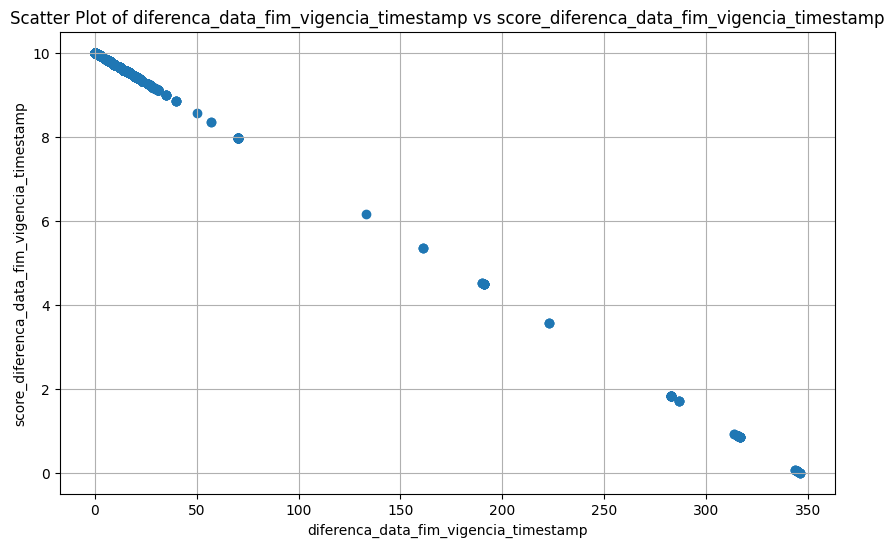

In [ ]:
import pandas as pd
import numpy as np
import datetime
from pytz import timezone  # Importing timezone for handling different time zones
import matplotlib.pyplot as plt

# Define the timezone for Brasília (America/Sao_Paulo)
brasilia_tz = timezone('America/Sao_Paulo')

# Add a timestamp column with the current time in Brasília
df_merged['timestamp_data_scarping'] = datetime.datetime.now(brasilia_tz)

# Calculate the quantity of NaT in 'data_fim_vigencia_iso8601'
nat_count = df_merged['data_fim_vigencia_iso8601'].isnull().sum()

# Calculate the total count of the column
total_count = len(df_merged['data_fim_vigencia_iso8601'])

# Calculate the difference between 'data_fim_vigencia' and 'dataInclusao'
df_merged['diferenca_dias'] = (pd.to_datetime(df_merged['data_fim_vigencia_iso8601'], errors='coerce', utc=True) - pd.to_datetime(df_merged['dataInclusao'], errors='coerce', utc=True)).dt.days

# Add a column that normalizes 'diferenca_dias' from 10 to 0 and call it 'score_diferenca_dias_normalizada'
df_merged['score_diferenca_dias_normalizada'] = np.where(
    df_merged['diferenca_dias'] < 365,
    10 - (df_merged['diferenca_dias'] / df_merged['diferenca_dias'].max() * 10),
    0
)

# Calculate the difference between 'data_fim_vigencia' and 'timestamp_data_scarping'
df_merged['diferenca_data_fim_vigencia_timestamp'] = (pd.to_datetime(df_merged['data_fim_vigencia_iso8601'], errors='coerce').dt.tz_localize(None) - pd.to_datetime(df_merged['timestamp_data_scarping'], errors='coerce').dt.tz_localize(None)).dt.days

# Add a column to df_merged that normalizes 'diferenca_data_fim_vigencia_timestamp' for 0 to 10 and call it 'score_diferenca_data_fim_vigencia_timestamp'
df_merged['score_diferenca_data_fim_vigencia_timestamp'] = 10 - (df_merged['diferenca_data_fim_vigencia_timestamp'] / df_merged['diferenca_data_fim_vigencia_timestamp'].max() * 10)

# Display the quantity of rows and columns
print(f"Rows: {df_merged.shape[0]}, Columns: {df_merged.shape[1]}")

# Calculate statistics for 'score_diferenca_dias_normalizada'
total_count_normalizada = df_merged['score_diferenca_dias_normalizada'].count()
nan_count_normalizada = df_merged['score_diferenca_dias_normalizada'].isna().sum()
nan_percentage_normalizada = (nan_count_normalizada / len(df_merged['score_diferenca_dias_normalizada'])) * 100

print(f"Total count of 'score_diferenca_dias_normalizada': {total_count_normalizada}")
print(f"Number of NaN values in 'score_diferenca_dias_normalizada': {nan_count_normalizada}")
print(f"Percentage of NaN values in 'score_diferenca_dias_normalizada': {nan_percentage_normalizada:.2f}%")

# Calculate statistics for 'score_diferenca_data_fim_vigencia_timestamp'
total_count_fim_vigencia = df_merged['score_diferenca_data_fim_vigencia_timestamp'].count()
nan_count_fim_vigencia = df_merged['score_diferenca_data_fim_vigencia_timestamp'].isna().sum()
nan_percentage_fim_vigencia = (nan_count_fim_vigencia / len(df_merged['score_diferenca_data_fim_vigencia_timestamp'])) * 100

print(f"Total count of 'score_diferenca_data_fim_vigencia_timestamp': {total_count_fim_vigencia}")
print(f"Number of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': {nan_count_fim_vigencia}")
print(f"Percentage of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': {nan_percentage_fim_vigencia:.2f}%")

# Plot 'diferenca_data_fim_vigencia_timestamp' vs 'score_diferenca_data_fim_vigencia_timestamp'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(df_merged['diferenca_data_fim_vigencia_timestamp'], df_merged['score_diferenca_data_fim_vigencia_timestamp'])
plt.xlabel('diferenca_data_fim_vigencia_timestamp')
plt.ylabel('score_diferenca_data_fim_vigencia_timestamp')
plt.title('Scatter Plot of diferenca_data_fim_vigencia_timestamp vs score_diferenca_data_fim_vigencia_timestamp')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Assuming df_merged is the dataframe loaded already
# Calculate the difference between timestamp_data_scarping and dataInclusao
df_merged['diferenca_timestamp_dataInclusao'] = (
    pd.to_datetime(df_merged['timestamp_data_scarping'], errors='coerce')
    - pd.to_datetime(df_merged['dataInclusao'], errors='coerce')
).dt.days

# Normalize 'diferenca_timestamp_dataInclusao' from 0 to 10
df_merged['score_diferenca_timestamp_dataInclusao'] = (
    10 - (df_merged['diferenca_timestamp_dataInclusao'] / df_merged['diferenca_timestamp_dataInclusao'].max() * 10)
)

# Calculate the total count of 'score_diferenca_dias_normalizada'
total_count = df_merged['score_diferenca_data_fim_vigencia_timestamp'].count()

# Calculate the number of NaN values in 'score_diferenca_dias_normalizada'
nan_count = df_merged['score_diferenca_data_fim_vigencia_timestamp'].isna().sum()

# Calculate the percentage of NaN values
nan_percentage = (nan_count / len(df_merged['score_diferenca_data_fim_vigencia_timestamp'])) * 100

# Output results
print(f"Total count of 'score_diferenca_data_fim_vigencia_timestamp': {total_count}")
print(f"Number of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': {nan_count}")
print(f"Percentage of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': {nan_percentage:.2f}%")

Total count of 'score_diferenca_data_fim_vigencia_timestamp': 85084
Number of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': 0
Percentage of NaN values in 'score_diferenca_data_fim_vigencia_timestamp': 0.00%


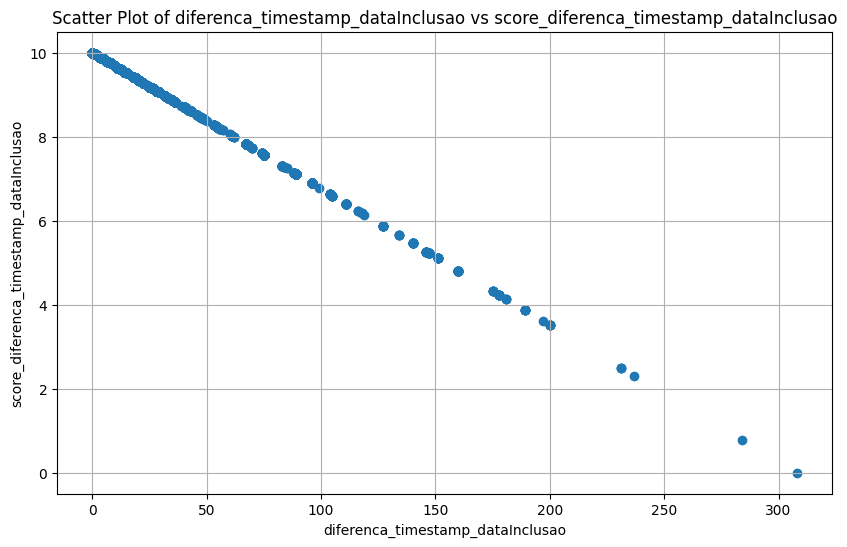

In [ ]:
# prompt: plot diferenca_timestamp_dataInclusao  score_diferenca_timestamp_dataInclusao

import matplotlib.pyplot as plt

# Plot 'diferenca_timestamp_dataInclusao' vs 'score_diferenca_timestamp_dataInclusao'
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(df_merged['diferenca_timestamp_dataInclusao'], df_merged['score_diferenca_timestamp_dataInclusao'])
plt.xlabel('diferenca_timestamp_dataInclusao')
plt.ylabel('score_diferenca_timestamp_dataInclusao')
plt.title('Scatter Plot of diferenca_timestamp_dataInclusao vs score_diferenca_timestamp_dataInclusao')
plt.grid(True)
plt.show()

In [ ]:
# prompt: add a column that gives 10 points when tipoBeneficioNome equals Participação exclusiva para ME/EPP print(df_merged.sample(20))

# Add a new column 'score_tipoBeneficioNome'
df_merged['score_tipoBeneficioNome'] = 0

# Assign 10 points where 'tipoBeneficioNome' equals 'Participação exclusiva para ME/EPP'
df_merged.loc[df_merged['tipoBeneficioNome'] == 'Participação exclusiva para ME/EPP', 'score_tipoBeneficioNome'] = 10



In [ ]:
import pandas as pd

# Assuming df_merged is already loaded

# 1. Group by 'numero_controle_pncp' and sum 'valorTotal'
df_merged['valor_total_licitacao'] = df_merged.groupby('numero_controle_pncp')['valorTotal'].transform('sum')

# 2. Normalize 'valor_total_licitacao' where higher values get closer to 2 and smaller values get closer to 0
df_merged['score_valor_total_licitacao'] = (df_merged['valor_total_licitacao'] / df_merged['valor_total_licitacao'].max()) * 2

# 3. Create the 'weekday_data_fim_vigencia' column based on 'data_fim_vigencia_iso8601'
df_merged['data_fim_vigencia_iso8601'] = pd.to_datetime(df_merged['data_fim_vigencia_iso8601'], errors='coerce')
df_merged['weekday_data_fim_vigencia'] = df_merged['data_fim_vigencia_iso8601'].dt.weekday

# Assign scores based on the weekday
df_merged['score_weekday_data_fim_vigencia'] = 0
df_merged.loc[df_merged['weekday_data_fim_vigencia'] == 4, 'score_weekday_data_fim_vigencia'] = 3  # Friday
df_merged.loc[df_merged['weekday_data_fim_vigencia'] == 0, 'score_weekday_data_fim_vigencia'] = 2  # Monday
df_merged.loc[(df_merged['weekday_data_fim_vigencia'] != 4) & (df_merged['weekday_data_fim_vigencia'] != 0), 'score_weekday_data_fim_vigencia'] = 1  # Other days

# 4. Extract the hour and minute from 'data_fim_vigencia_iso8601'
df_merged['hora_fim_vigencia'] = df_merged['data_fim_vigencia_iso8601'].dt.strftime('%H:%M')

# 5. Score 'hora_fim_vigencia' based on how close it is to 18:00
df_merged['hora_fim_vigencia'] = pd.to_datetime(df_merged['hora_fim_vigencia'], format='%H:%M').dt.time
df_merged['diff_hora_fim_vigencia'] = (pd.to_datetime(df_merged['hora_fim_vigencia'], format='%H:%M:%S').dt.hour - 18).abs()

# Normalize the difference to a score between 0 and 10
df_merged['score_hora_fim_vigencia'] = 10 - (df_merged['diff_hora_fim_vigencia'] / df_merged['diff_hora_fim_vigencia'].max() * 10)



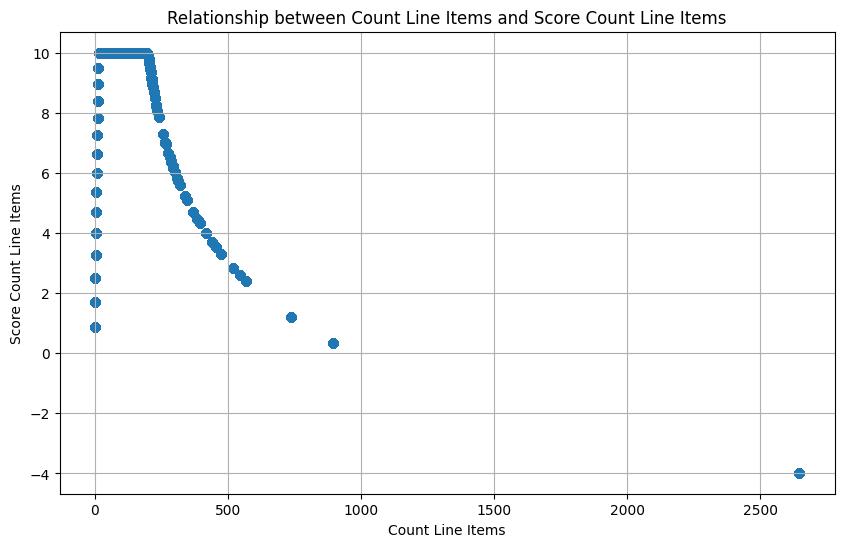

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_merged is already loaded

# 1. Group by 'numero_controle_pncp' and count the number of items
df_merged['count_line_items'] = df_merged.groupby('numero_controle_pncp')['item_url'].transform('count')

# 2. Define the function for the concave down increasing formula
def custom_function(x):
    # Updated constants to avoid negative scores
    a = 15  # Increased a to raise the plateau and ensure values are high enough
    b = 0.05  # Adjusted b to fine-tune the initial sharp increase
    c = 3  # Reduced c to soften the decline for x > 200
    d = 0.02  # Reduced d to make the decrease more gradual

    if x <= 15:
        return a * np.log(b * x + 1)  # Sharp increase for x <= 15
    elif 15 < x <= 200:
        return a * np.log(b * 15 + 1)  # Plateau for 15 < x <= 200
    else:
        return a * np.log(b * 15 + 1) - c * np.log(d * (x - 200) + 1)  # Gradual logarithmic decrease for x > 200



# 3. Apply the custom function to the 'count_line_items' column
df_merged['calculo_count_line_items'] = df_merged['count_line_items'].apply(custom_function)

# 4. Normalize 'calculo_count_line_items' to a score between 0 and 10
df_merged['score_count_line_items'] = (df_merged['calculo_count_line_items'] / df_merged['calculo_count_line_items'].max()) * 10

# 5. Create a scatter plot of 'count_line_items' vs 'score_count_line_items'
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['count_line_items'], df_merged['score_count_line_items'])
plt.xlabel('Count Line Items')
plt.ylabel('Score Count Line Items')
plt.title('Relationship between Count Line Items and Score Count Line Items')
plt.grid(True)
plt.show()

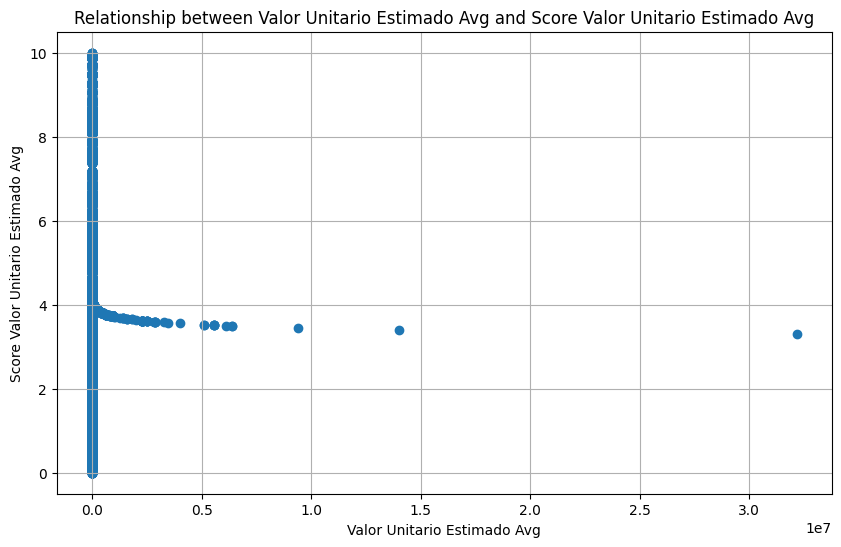

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_merged is already loaded

# 1. Calculate the average 'valorUnitarioEstimado' for each 'numero_controle_pncp', excluding zeros
df_merged['valorUnitarioEstimado_avg'] = df_merged[df_merged['valorUnitarioEstimado'] != 0].groupby('numero_controle_pncp')['valorUnitarioEstimado'].transform('mean')

# 2. Define the custom function for concave down increasing formula with adjusted ranges (1,000 to 50,000)
def custom_function(x):
    # Constants for scaling the output between 0 and 10
    max_value = 10  # Keep the max score as 10
    a = 2.5  # Sharp increase scaling, can be adjusted if needed
    b = 0.0005  # Controls the sharpness of the initial increase
    plateau_value = max_value  # Plateau height at max_value (10)
    c = 0.3  # Controls how fast the function decays after 50,000
    d = 0.00001  # Controls the smoothness of the decay after 50,000

    if x <= 1000:
        # Sharp increase scaled to reach max_value at x = 1000
        return plateau_value * (a * np.log(b * x + 1) / np.log(b * 1000 + 1))  # Scale to ensure it reaches 10 at x = 1000
    elif 1000 < x <= 50000:
        # Plateau region, constant value of 10
        return plateau_value
    else:
        # Logarithmic decrease, ensure it stays in positive range
        decrease_value = plateau_value - c * np.log(d * (x - 50000) + 1)
        return max(decrease_value, 0)  # Ensure the value never goes below 0


# 3. Apply the custom function to the 'valorUnitarioEstimado_avg' column
df_merged['calculo_valorUnitarioEstimado_avg'] = df_merged['valorUnitarioEstimado_avg'].apply(custom_function)

# 4. Normalize 'calculo_valorUnitarioEstimado_avg' to a score between 0 and 10
df_merged['score_valorUnitarioEstimado_avg'] = (df_merged['calculo_valorUnitarioEstimado_avg'] / df_merged['calculo_valorUnitarioEstimado_avg'].max()) * 10

# 5. Print 20 sample rows
#print(df_merged[['numero_controle_pncp', 'valorUnitarioEstimado_avg', 'score_valorUnitarioEstimado_avg']].sample(20))

# 6. Create a scatter plot of 'valorUnitarioEstimado_avg' vs 'score_valorUnitarioEstimado_avg'
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['valorUnitarioEstimado_avg'], df_merged['score_valorUnitarioEstimado_avg'])
plt.xlabel('Valor Unitario Estimado Avg')
plt.ylabel('Score Valor Unitario Estimado Avg')
plt.title('Relationship between Valor Unitario Estimado Avg and Score Valor Unitario Estimado Avg')
plt.grid(True)
plt.show()

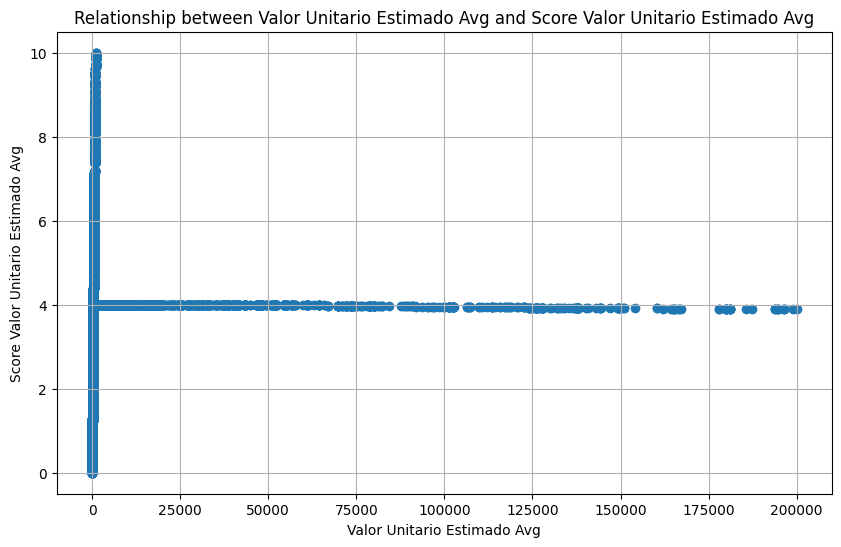

In [ ]:
# prompt: exclude all rows from df_merged where valorUnitarioEstimado_avg is above 1 million

df_merged = df_merged[df_merged['valorUnitarioEstimado_avg'] <= 200000]

# 6. Create a scatter plot of 'valorUnitarioEstimado_avg' vs 'score_valorUnitarioEstimado_avg'
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['valorUnitarioEstimado_avg'], df_merged['score_valorUnitarioEstimado_avg'])
plt.xlabel('Valor Unitario Estimado Avg')
plt.ylabel('Score Valor Unitario Estimado Avg')
plt.title('Relationship between Valor Unitario Estimado Avg and Score Valor Unitario Estimado Avg')
plt.grid(True)
plt.show()

| numero_controle_pncp         | quantidade_avg   | score_quantidade_avg   |
|:-----------------------------|:-----------------|:-----------------------|
| 08241739000105-1-000995/2024 | 23416.7          | 9.30304                |
| 77116663000109-1-000117/2024 | 149.219          | 10                     |
| 46218698000117-1-000049/2024 | 576.158          | 10                     |
| 79151312000156-1-000849/2024 | 116.04           | 10                     |
| 00394502000144-1-013418/2024 | 300.252          | 10                     |
| 95591764000105-1-000301/2024 | 58.2726          | 10                     |
| 46634101000115-1-000360/2024 | 2717.57          | 10                     |
| 00394429000100-1-002505/2024 | 5.34615          | 8.54417                |
| 27080530000143-1-002210/2024 | 4863.92          | 10                     |
| 00394429000100-1-002342/2024 | 117.558          | 10                     |
| 96291141000180-1-005438/2024 | 57.3191          | 10                     |

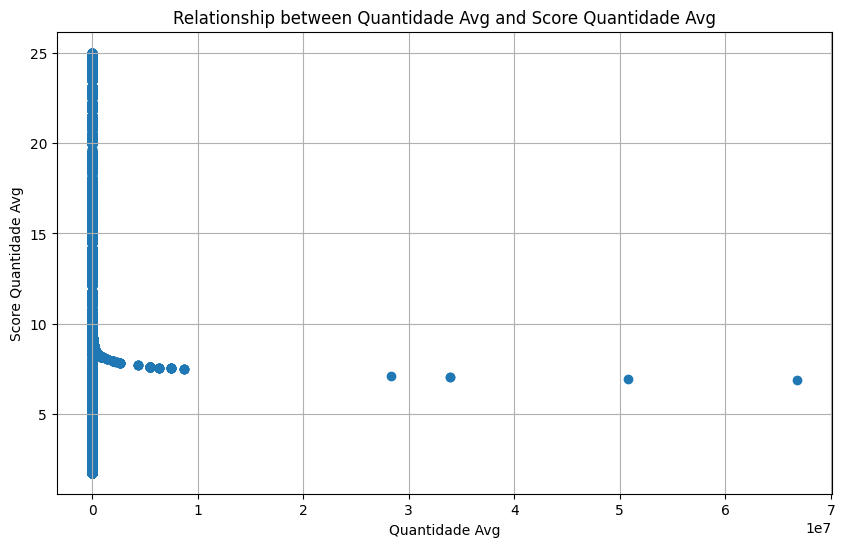

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_merged is already loaded

# 1. Calculate the average 'quantidade' for each 'numero_controle_pncp', excluding zeros
df_merged['quantidade_avg'] = df_merged[df_merged['quantidade'] != 0].groupby('numero_controle_pncp')['quantidade'].transform('mean')

# 2. Adjust the custom function for concave down increasing formula with adjusted ranges (20 to 5,000)
def quantidade_custom_function(x):
    max_value = 10  # Maximum score remains at 10
    a = 2.5  # Sharp increase scaling
    b = 0.05  # Controls the sharpness of the initial increase
    plateau_value = max_value  # Plateau height at max_value (10)
    c = 0.3  # Controls how fast the function decays after 5,000
    d = 0.0005  # Controls the smoothness of the decay after 5,000

    if x <= 20:
        # Sharp increase scaled to reach max_value at x = 20
        return plateau_value * (a * np.log(b * x + 1) / np.log(b * 20 + 1))  # Scale to ensure it reaches 10 at x = 20
    elif 20 < x <= 5000:
        # Plateau region, constant value of 10
        return plateau_value
    else:
        # Logarithmic decrease, ensure it stays in positive range
        decrease_value = plateau_value - c * np.log(d * (x - 5000) + 1)
        return max(decrease_value, 0)  # Ensure the value never goes below 0

# Apply the custom function to calculate the score for 'quantidade_avg'
df_merged['score_quantidade_avg'] = df_merged['quantidade_avg'].apply(quantidade_custom_function)

# 3. Print 20 sample rows for validation in Markdown format
print(df_merged[['numero_controle_pncp', 'quantidade_avg', 'score_quantidade_avg']].sample(20).to_markdown(index=False, numalign="left", stralign="left"))

# 4. Create a scatter plot of 'quantidade_avg' vs 'score_quantidade_avg'
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['quantidade_avg'], df_merged['score_quantidade_avg'])
plt.xlabel('Quantidade Avg')
plt.ylabel('Score Quantidade Avg')
plt.title('Relationship between Quantidade Avg and Score Quantidade Avg')
plt.grid(True)
plt.show()


In [ ]:
import sqlite3
import pandas as pd

def load_scores_and_process_dataframe(db_file_unidade, db_file_orgao, df):
    """
    Loads unidade_codigo and orgao_id scores from SQLite databases and processes the given DataFrame.

    Args:
        db_file_unidade (str): The path to the SQLite database for unidade_codigo scores.
        db_file_orgao (str): The path to the SQLite database for orgao_id scores.
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame with score columns added.
    """

    # Load unidade_codigo scores
    conn = sqlite3.connect(db_file_unidade)
    cursor = conn.cursor()
    cursor.execute('SELECT unidade_codigo FROM unidade_codigo_scores')
    unidade_codigo_scores = [row[0] for row in cursor.fetchall()]
    conn.close()

    # Clean and convert 'unidade_codigo' to integers
    df['unidade_codigo'] = df['unidade_codigo'].fillna(0).astype(str).str.replace('\D', '', regex=True)
    df['unidade_codigo'] = pd.to_numeric(df['unidade_codigo'], errors='coerce').fillna(0).astype(int)

    # Add and assign scores for unidade_codigo
    df['score_unidade_codigo'] = 0
    df.loc[df['unidade_codigo'].isin(unidade_codigo_scores), 'score_unidade_codigo'] = 10

    # Load orgao_id scores
    conn = sqlite3.connect(db_file_orgao)
    cursor = conn.cursor()
    cursor.execute('SELECT orgao_id FROM orgao_id_scores')
    orgao_id_scores = [row[0] for row in cursor.fetchall()]
    conn.close()

    # Clean and convert 'orgao_id' to integers
    df['orgao_id'] = df['orgao_id'].fillna(0).astype(str).str.replace('\D', '', regex=True)
    df['orgao_id'] = pd.to_numeric(df['orgao_id'], errors='coerce').fillna(0).astype(int)

    # Add and assign scores for orgao_id
    df['score_orgao_id'] = 0
    df.loc[df['orgao_id'].isin(orgao_id_scores), 'score_orgao_id'] = 10

    # Display rows with scores
    #if (df['score_unidade_codigo'] != 0).any():
     #   print("Sample rows with non-zero 'score_unidade_codigo':")
      #  print(df[df['score_unidade_codigo'] != 0].sample(10))
    #else:
     #   print("No rows found with non-zero 'score_unidade_codigo'")

    #if (df['score_orgao_id'] != 0).any():
     #   print("Sample rows with non-zero 'score_orgao_id':")
      #  print(df[df['score_orgao_id'] != 0].sample(10))
    #else:
     #   print("No rows found with non-zero 'score_orgao_id'")

    # Display 10 rows with zero scores
    #print("Sample rows with zero 'score_unidade_codigo':")
    #print(df[df['score_unidade_codigo'] == 0].sample(10))
    #print("Sample rows with zero 'score_orgao_id':")
    #print(df[df['score_orgao_id'] == 0].sample(10))

    return df

# Usage
DB_FILE_UNIDADE = '/content/drive/MyDrive/sqlite_dbs/unidade_codigo_scores.db'  # Replace with your actual path
DB_FILE_ORGAO = '/content/drive/MyDrive/sqlite_dbs/orgao_id_scores.db'  # Replace with your actual path
df_merged = load_scores_and_process_dataframe(DB_FILE_UNIDADE, DB_FILE_ORGAO, df_merged)

In [ ]:
import sqlite3
import pandas as pd

def load_description_words_and_process_dataframe(db_file, df):
    """
    Loads the description_words from SQLite database, processes the given DataFrame,
    and adds matching and concatenated words columns, along with a score based on matches.

    Args:
        db_file (str): The path to the SQLite database for description words.
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame with matching, concatenated words, and score columns added.
    """

    # Load description words
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    cursor.execute('SELECT word FROM description_words')
    description_words = [row[0] for row in cursor.fetchall()]
    conn.close()

    # Normalize the 'descricao' column (assuming normalize_text is defined)
    df['descricao_normalized'] = df['descricao'].apply(normalize_text)

    # Function to find matching words
    def find_matching_words(row):
        return [word for word in description_words if word in row['descricao_normalized']]

    # Apply the function to create the new column
    df['matching_words'] = df.apply(find_matching_words, axis=1)

    # Group by 'numero_controle_pncp' and aggregate 'matching_words' to avoid repetition
    grouped = df.groupby('numero_controle_pncp')['matching_words'].apply(
        lambda x: list(set([word for sublist in x for word in sublist]))
    )

    # Create a new column 'concatenated_words' with the aggregated words
    df['concatenated_words'] = df['numero_controle_pncp'].map(grouped)

    # Add the 'quantity_description_words' column
    df['quantity_description_words'] = df['concatenated_words'].apply(len)

    # Define a function to apply the conditions
    def calculate_score(row):
        if row['quantity_description_words'] == 0:
            return 0
        else:
            # Normalize for values greater than 0
            return ((row['quantity_description_words'] - df['quantity_description_words'].min()) /
                    (df['quantity_description_words'].max() - df['quantity_description_words'].min()) * (40 - 10) + 10)

    # Apply the function to create 'score_description_words' column
    df['score_description_words'] = df.apply(calculate_score, axis=1)

    # Print 20 sample rows in Markdown format
    print(df.sample(20).to_markdown(index=False, numalign="left", stralign="left"))

    return df

# Usage
DB_FILE = '/content/drive/MyDrive/sqlite_dbs/description_words.db'  # Replace with your actual path
df_merged = load_description_words_and_process_dataframe(DB_FILE, df_merged)

| id                               | index    | doc_type   | title                                         | description                                                                                                                                                                                                                                                                                                                                                                                                                                                   | item_url                           | document_type   | createdAt            | numero   | ano   | numero_sequencial   | numero_sequencial_compra_ata   | numero_controle_pncp         | orgao_id   | orgao_cnpj     | orgao_nome                                             | orgao_subrogado_id   | orgao_subrogado_nome   | unidade_id   | unidade_codigo   | unidade_nome                                  | esfera_id   | esfera_nome   | poder_id   | 

In [ ]:
import numpy as np
import pandas as pd

# Assuming df_merged is already loaded

# 1. Add a new column 'matching_words_flag' based on conditions:
# - matching_words is a non-empty list
# - valorTotal is greater than 4000
df_merged['matching_words_flag'] = np.where(
    (df_merged['matching_words'].apply(lambda x: isinstance(x, list) and len(x) > 0)) & (df_merged['valorTotal'] > 4000),
    1,
    0
)

# 2. Sum 'matching_words_flag' by 'numero_controle_pncp'
df_merged['sum_matching_words_flag'] = df_merged.groupby('numero_controle_pncp')['matching_words_flag'].transform('sum')

# 3. Normalize 'sum_matching_words_flag' to a score between 0 and 10
min_value = df_merged['sum_matching_words_flag'].min()
max_value = df_merged['sum_matching_words_flag'].max()

# Avoid division by zero in case all values are the same
if max_value != min_value:
    df_merged['score_matching_words'] = 10 * (df_merged['sum_matching_words_flag'] - min_value) / (max_value - min_value)
else:
    df_merged['score_matching_words'] = 10  # Assign a score of 10 if all values are the same

# 4. Optionally print 20 rows of the updated DataFrame
print(df_merged[['numero_controle_pncp', 'matching_words_flag', 'sum_matching_words_flag', 'score_matching_words']].sample(20).to_markdown(index=False, numalign="left", stralign="left"))


| numero_controle_pncp         | matching_words_flag   | sum_matching_words_flag   | score_matching_words   |
|:-----------------------------|:----------------------|:--------------------------|:-----------------------|
| 29138377000193-1-000077/2024 | 0                     | 0                         | 0                      |
| 13031547000104-1-000097/2024 | 0                     | 0                         | 0                      |
| 10882594000165-1-000491/2024 | 0                     | 9                         | 1.05882                |
| 00394452000103-1-018882/2024 | 0                     | 0                         | 0                      |
| 32479123000143-1-000146/2024 | 0                     | 24                        | 2.82353                |
| 77774867000129-1-000131/2024 | 0                     | 0                         | 0                      |
| 00394502000144-1-013974/2024 | 0                     | 4                         | 0.470588               |
| 15461510

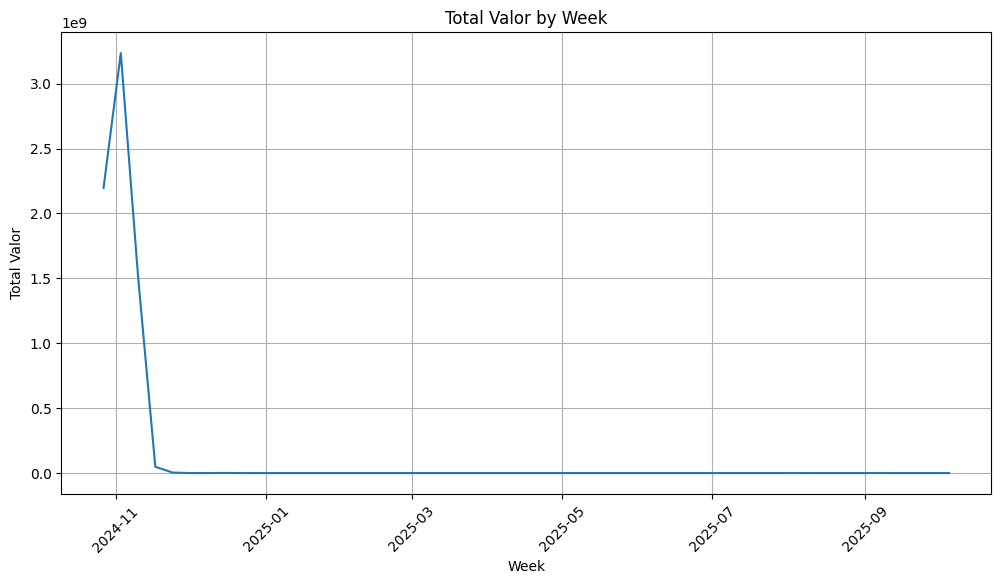

In [ ]:
# prompt: plot data_fim_vigencia_iso8601 and  valorTotal   grouped by week

import matplotlib.pyplot as plt
import pandas as pd

# Convert 'data_fim_vigencia_iso8601' to datetime objects
df_merged['data_fim_vigencia_iso8601'] = pd.to_datetime(df_merged['data_fim_vigencia_iso8601'])

# Group by week and calculate the sum of 'valorTotal'
df_weekly = df_merged.groupby(pd.Grouper(key='data_fim_vigencia_iso8601', freq='W'))['valorTotal'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_weekly.index, df_weekly.values)
plt.xlabel('Week')
plt.ylabel('Total Valor')
plt.title('Total Valor by Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


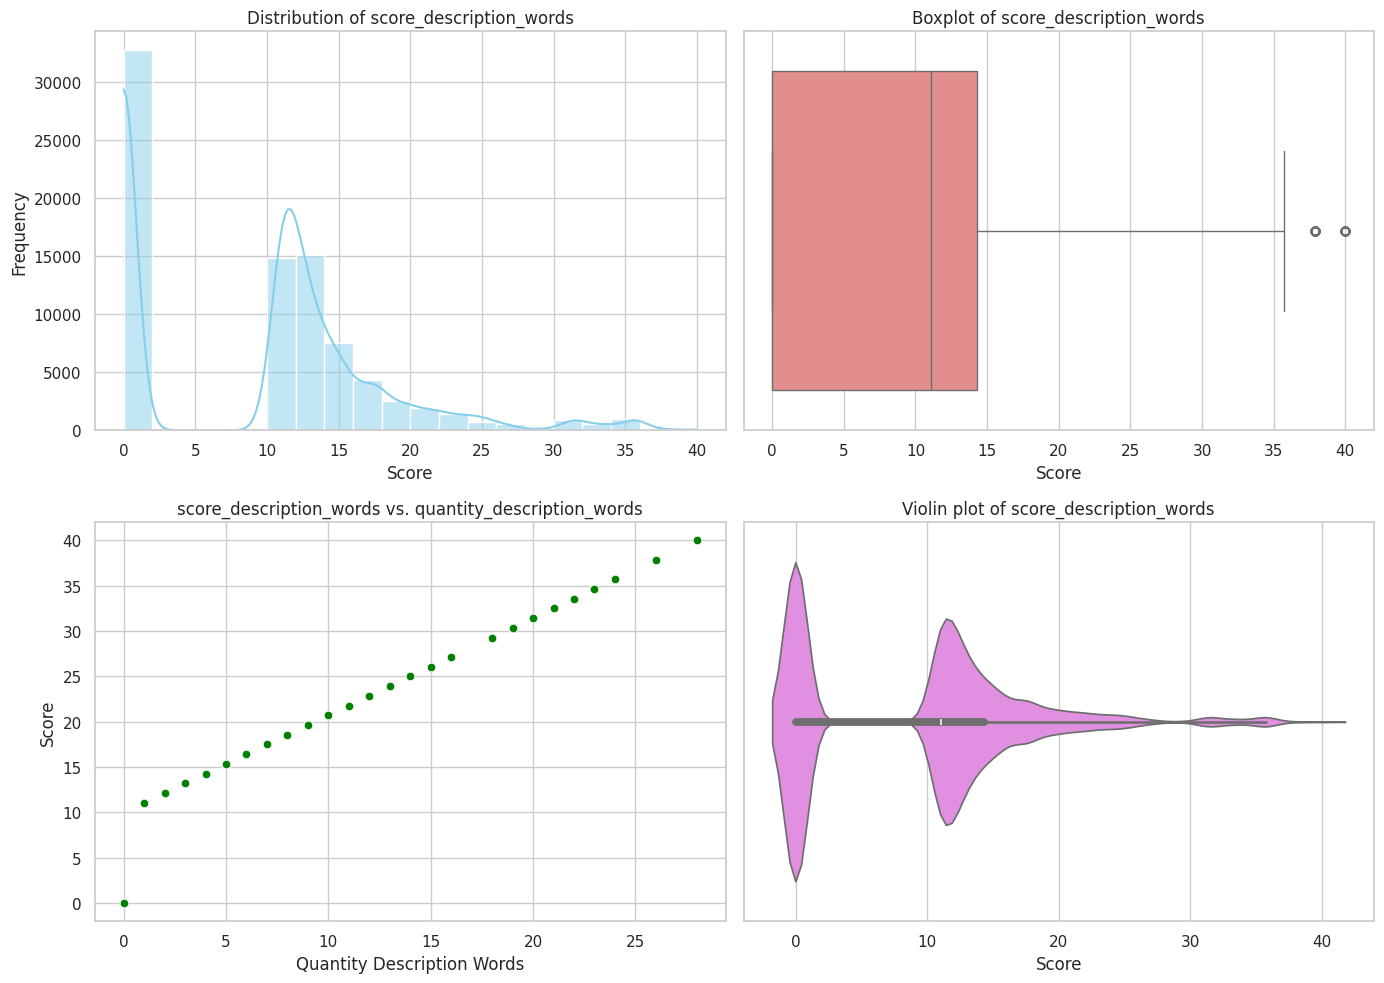

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure and axes for multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of score_description_words
sns.histplot(df_merged['score_description_words'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')  # Changed df to df_merged
axes[0, 0].set_title('Distribution of score_description_words')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')

# 2. Boxplot of score_description_words (for spread and outliers)
sns.boxplot(x=df_merged['score_description_words'], ax=axes[0, 1], color='lightcoral')  # Changed df to df_merged
axes[0, 1].set_title('Boxplot of score_description_words')
axes[0, 1].set_xlabel('Score')

# 3. Scatter plot: score_description_words vs. quantity_description_words
sns.scatterplot(x=df_merged['quantity_description_words'], y=df_merged['score_description_words'], ax=axes[1, 0], color='green')  # Changed df to df_merged
axes[1, 0].set_title('score_description_words vs. quantity_description_words')
axes[1, 0].set_xlabel('Quantity Description Words')
axes[1, 0].set_ylabel('Score')

# 4. Violin plot (to show distribution and density)
sns.violinplot(x=df_merged['score_description_words'], ax=axes[1, 1], color='violet')  # Changed df to df_merged
axes[1, 1].set_title('Violin plot of score_description_words')
axes[1, 1].set_xlabel('Score')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# prompt: add a column to df_merged that scores 8 points modalidade_licitacao_nome contains "Dispensa"

# Add the 'score_modalidade_licitacao_nome' column
df_merged['score_modalidade_licitacao_nome'] = 0

# Assign 10 points where 'modalidade_licitacao_nome' contains "Dispensa"
df_merged.loc[df_merged['modalidade_licitacao_nome'].str.contains("Dispensa", na=False), 'score_modalidade_licitacao_nome'] = 8


In [ ]:
# Import the golden ratio
golden_ratio = 1.618

# Create a new dictionary that adjusts scores based on the golden ratio and desired range
uf_scores_adjusted = {
    'GO': 12,
    'MS': 12,
    'MT': 12,
    'AL': 10,
    'BA': 10,
    'CE': 10,
    'MA': 10,
    'PB': 10,
    'PE': 10,
    'PI': 10,
    'RN': 10,
    'SE': 10,
    'AC': 4,
    'AM': 10,
    'AP': -5,  # Adjusted from -50
    'PA': 4,
    'RO': 4,
    'RR': -5,  # Adjusted from -50
    'TO': -5,  # Adjusted from -50
    'ES': 12,
    'MG': 12,
    'RJ': -5,  # Adjusted from -50
    'SP': 15,
    'PR': 12,  # Slightly reduced to follow golden ratio with other clusters
    'RS': 12,
    'SC': 12,
    'DF': 12,
}

# Add the 'score_uf' column to df_merged with the adjusted scores
df_merged['score_uf'] = df_merged['uf'].map(uf_scores_adjusted).fillna(0)

# Optionally, print 20 sample rows to verify changes
#print(df_merged.sample(20))


               numero_controle_pncp  count_valorUnitarioEstimado_above_500  score_count_valorUnitarioEstimado_above_500
48536  00444232000139-1-000535/2024                                    0.0                                     0.000000
77841  76205699000198-1-000055/2024                                    0.0                                     0.000000
81364  00394452000103-1-019371/2024                                    1.0                                     0.004552
29001  76105543000135-1-000170/2024                                   42.0                                     0.191170
47400  00394429000100-1-002419/2024                                    0.0                                     0.000000


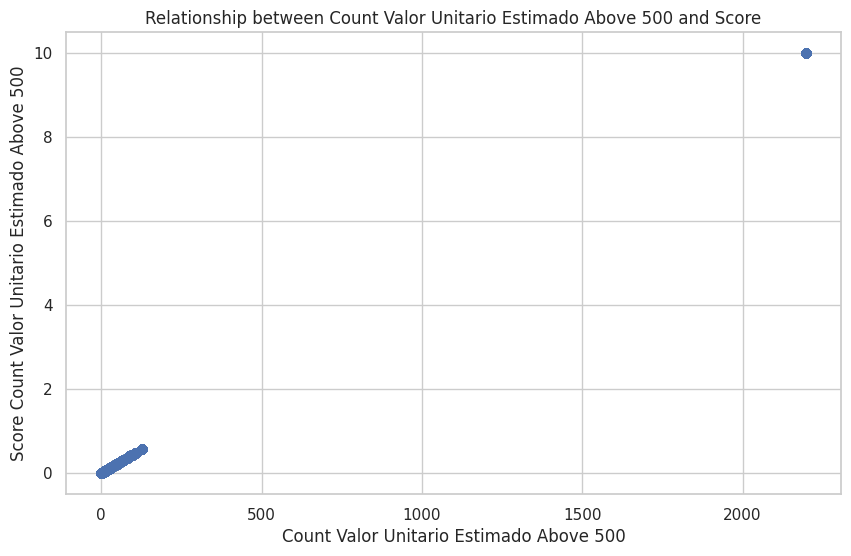

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def process_valor_estimado(df):
    """
    Processes the DataFrame to count 'valorUnitarioEstimado' above 500,
    normalizes the count, and creates a scatter plot.

    Args:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame with the new columns added.
    """

    # Group by 'numero_controle_pncp' and count 'valorUnitarioEstimado' above 500
    df['count_valorUnitarioEstimado_above_500'] = df[df['valorUnitarioEstimado'] > 500].groupby('numero_controle_pncp')['valorUnitarioEstimado'].transform('count')

    # Fill NaN values with 0
    df['count_valorUnitarioEstimado_above_500'] = df['count_valorUnitarioEstimado_above_500'].fillna(0)

    # Normalize 'count_valorUnitarioEstimado_above_500' from 0 to 10
    df['score_count_valorUnitarioEstimado_above_500'] = (
        df['count_valorUnitarioEstimado_above_500'] / df['count_valorUnitarioEstimado_above_500'].max() * 10
    )

    # Print 20 sample rows for validation
    print(df[['numero_controle_pncp', 'count_valorUnitarioEstimado_above_500', 'score_count_valorUnitarioEstimado_above_500']].sample(5))

    # Create a scatter plot of 'count_valorUnitarioEstimado_above_500' vs 'score_count_valorUnitarioEstimado_above_500'
    plt.figure(figsize=(10, 6))
    plt.scatter(df['count_valorUnitarioEstimado_above_500'], df['score_count_valorUnitarioEstimado_above_500'])
    plt.xlabel('Count Valor Unitario Estimado Above 500')
    plt.ylabel('Score Count Valor Unitario Estimado Above 500')
    plt.title('Relationship between Count Valor Unitario Estimado Above 500 and Score')
    plt.grid(True)
    plt.show()

    return df

# Usage
df_merged = process_valor_estimado(df_merged)

In [ ]:
# prompt: print the numero_controle_pncp  with the highest score_count_valorUnitarioEstimado_above_500

# Find the 'numero_controle_pncp' with the highest 'score_count_valorUnitarioEstimado_above_500'
numero_controle_pncp_with_highest_score = df_merged.loc[df_merged['score_count_valorUnitarioEstimado_above_500'].idxmax()]['numero_controle_pncp']

print(f"The 'numero_controle_pncp' with the highest 'score_count_valorUnitarioEstimado_above_500' is: {numero_controle_pncp_with_highest_score}")

The 'numero_controle_pncp' with the highest 'score_count_valorUnitarioEstimado_above_500' is: 76995323000124-1-000246/2024


               numero_controle_pncp  valorTotal  count_valorTotal_above_2000
51277  28645794000160-1-000062/2024    12136.50                         24.0
79101  01230238000176-1-000001/2024     1408.40                          0.0
6993   29138377000193-1-000078/2024     1318.35                          0.0
35457  15412257000128-1-000173/2024     8645.64                          6.0
55183  96291141000180-1-005345/2024       63.00                          0.0
9672   00394502000144-1-014304/2024    12375.00                        103.0
22864  02451938000153-1-000209/2024     7054.50                         23.0
53056  96291141000180-1-005362/2024     4496.50                          6.0
86043  96291141000180-1-005461/2024      127.36                          0.0
27192  27080605000196-1-000334/2024    21014.40                          4.0
              numero_controle_pncp  valorTotal  count_valorTotal_above_2000
1843  76995323000124-1-000246/2024     2840.79                        621.0
1

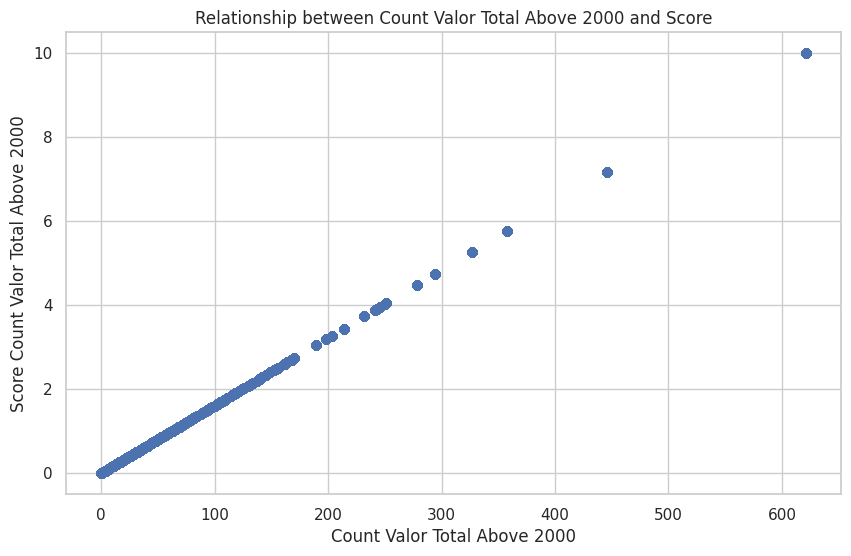

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def process_valor_total(df):
    """
    Processes the DataFrame to count 'valorTotal' above 2000,
    normalizes the count, and creates a scatter plot.

    Args:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame with the new columns added.
    """

    # Group by 'numero_controle_pncp' and count 'valorTotal' above 2000
    df['count_valorTotal_above_2000'] = df[df['valorTotal'] > 2000].groupby('numero_controle_pncp')['valorTotal'].transform('count')

    # Fill NaN values with 0
    df['count_valorTotal_above_2000'] = df['count_valorTotal_above_2000'].fillna(0)

    # Print 10 sample rows
    print(df[['numero_controle_pncp', 'valorTotal', 'count_valorTotal_above_2000']].sample(10))

    # Print the top 5 rows with the highest 'count_valorTotal_above_2000'
    top_5 = df[['numero_controle_pncp', 'valorTotal', 'count_valorTotal_above_2000']].nlargest(5, 'count_valorTotal_above_2000')

    # Print the result
    print(top_5)


    # Normalize 'count_valorTotal_above_2000' from 0 to 10
    df['score_count_valorTotal_above_2000'] = (
        df['count_valorTotal_above_2000'] / df['count_valorTotal_above_2000'].max() * 10
    )

    # Print 20 sample rows for validation
    # print(df[['numero_controle_pncp', 'count_valorTotal_above_2000', 'score_count_valorTotal_above_2000']].sample(20))

    # Create a scatter plot of 'count_valorTotal_above_2000' vs 'score_count_valorTotal_above_2000'
    plt.figure(figsize=(10, 6))
    plt.scatter(df['count_valorTotal_above_2000'], df['score_count_valorTotal_above_2000'])
    plt.xlabel('Count Valor Total Above 2000')
    plt.ylabel('Score Count Valor Total Above 2000')
    plt.title('Relationship between Count Valor Total Above 2000 and Score')
    plt.grid(True)
    plt.show()

    return df

# Usage
df_merged = process_valor_total(df_merged)

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# Set pandas display options
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Group by 'descricao_normalized' and calculate statistics
grouped_stats = df_merged.groupby('descricao_normalized').agg(
    valorUnitarioEstimado_mean=('valorUnitarioEstimado', 'mean'),
    valorUnitarioEstimado_median=('valorUnitarioEstimado', 'median'),
    valorUnitarioEstimado_75percentile=('valorUnitarioEstimado', lambda x: np.percentile(x, 75)),
    valorUnitarioEstimado_95percentile=('valorUnitarioEstimado', lambda x: np.percentile(x, 95)),
    count_rows=('valorUnitarioEstimado', 'size')
)

# Function to check normality
def check_normality(series):
    if len(series) < 3:
        return np.nan
    if series.max() - series.min() == 0:
        return 'Constant Data'
    stat, p_value = stats.shapiro(series)
    return 'Normal' if p_value > 0.05 else 'Not Normal'

# Apply normality test
df_merged['distribution'] = df_merged.groupby('descricao_normalized')['valorUnitarioEstimado'].transform(check_normality)

# Merge statistics back into the main DataFrame
df_merged = pd.merge(df_merged, grouped_stats, on='descricao_normalized', how='left')

# Display 20 sample rows with specified columns
columns_to_display = ['descricao_normalized', 'valorUnitarioEstimado', 'valorUnitarioEstimado_mean', 'valorUnitarioEstimado_median',
                      'valorUnitarioEstimado_75percentile', 'valorUnitarioEstimado_95percentile', 'count_rows']
print(df_merged.sample(20)[columns_to_display].to_markdown(index=False, numalign="left", stralign="left"))


| descricao_normalized                              | valorUnitarioEstimado   | valorUnitarioEstimado_mean   | valorUnitarioEstimado_median   | valorUnitarioEstimado_75percentile   | valorUnitarioEstimado_95percentile   | count_rows   |
|:--------------------------------------------------|:------------------------|:-----------------------------|:-------------------------------|:-------------------------------------|:-------------------------------------|:-------------|
| parafuso cirurgico  pequenos e grandes fragmentos | 18.06                   | 191.665                      | 64.455                         | 292.812                              | 663.032                              | 48           |
| envelope                                          | 19.2                    | 35.8546                      | 2.1                            | 51.05                                | 127.025                              | 151          |
| colete                                            

In [ ]:
# prompt: add a column to sf_merged that basis descricao_normalized calculates mode using valorUnitarioEstimado print sample rows and columns. you may round valorUnitarioEstimado  to closest integer for better mode calculation

# Round 'valorUnitarioEstimado' to the closest integer
df_merged['valorUnitarioEstimado_rounded'] = df_merged['valorUnitarioEstimado'].round().astype(int)

# Group by 'descricao_normalized' and calculate the mode of 'valorUnitarioEstimado_rounded'
mode_by_description = df_merged.groupby('descricao_normalized')['valorUnitarioEstimado_rounded'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Rename the mode column
mode_by_description = mode_by_description.rename('valorUnitarioEstimado_mode')

# Merge the mode back into the main DataFrame
df_merged = pd.merge(df_merged, mode_by_description, on='descricao_normalized', how='left')

# Display 20 sample rows with specified columns
columns_to_display = ['descricao_normalized', 'valorUnitarioEstimado', 'valorUnitarioEstimado_rounded', 'valorUnitarioEstimado_mode']
print(df_merged.sample(20)[columns_to_display].to_markdown(index=False, numalign="left", stralign="left"))


| descricao_normalized                       | valorUnitarioEstimado   | valorUnitarioEstimado_rounded   | valorUnitarioEstimado_mode   |
|:-------------------------------------------|:------------------------|:--------------------------------|:-----------------------------|
| carne de ave in natura                     | 16.23                   | 16                              | 19                           |
| disjuntor baixa tensao                     | 118.14                  | 118                             | 8                            |
| refrigerador duplex                        | 3483.49                 | 3483                            | 3483                         |
| papel celofane                             | 2.75                    | 3                               | 3                            |
| livro didatico                             | 197                     | 197                             | 46                           |
| cafeina                         

In [ ]:
def calculate_score(row):
    score = 0
    # Increment score for each condition met (now with >=)
    if row['valorUnitarioEstimado'] >= row['valorUnitarioEstimado_mean']:
        score += 1
    if row['valorUnitarioEstimado'] >= row['valorUnitarioEstimado_median']:
        score += 1
    if row['valorUnitarioEstimado'] >= row['valorUnitarioEstimado_75percentile']:
        score += 1
    if row['valorUnitarioEstimado'] >= row['valorUnitarioEstimado_95percentile']:
        score += 1
    if row['valorUnitarioEstimado'] >= row['valorUnitarioEstimado_mode']:  # Removed NaN check for mode1
        score += 1
    if row['distribution'] == 'Normal':
        score += 1
    return score

# Apply the scoring function to each row
df_merged['valorUnitarioEstimadoPoints'] = df_merged.apply(calculate_score, axis=1)

# Columns to display
columns_to_display = ['descricao_normalized', 'valorUnitarioEstimado', 'valorUnitarioEstimado_mean', 'valorUnitarioEstimado_median',
                      'valorUnitarioEstimado_75percentile', 'valorUnitarioEstimado_95percentile', 'valorUnitarioEstimado_mode',
                      'distribution', 'valorUnitarioEstimadoPoints']

# Display 20 sample rows with specified columns
print(df_merged.sample(20)[columns_to_display].to_markdown(index=False, numalign="left", stralign="left"))

| descricao_normalized                                                                                                                                                                                                               | valorUnitarioEstimado   | valorUnitarioEstimado_mean   | valorUnitarioEstimado_median   | valorUnitarioEstimado_75percentile   | valorUnitarioEstimado_95percentile   | valorUnitarioEstimado_mode   | distribution   | valorUnitarioEstimadoPoints   |
|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------|:-----------------------------|:-------------------------------|:-------------------------------------|:-------------------------------------|:-----------------------------|:---------------|:------------------------------|
| sofa                                    

In [ ]:
# prompt: add a column to df_merged that sums valorUnitarioEstimadoPoints basis numero_controle_pncp

# Group by 'numero_controle_pncp' and sum 'valorUnitarioEstimadoPoints'
df_merged['sum_valorUnitarioEstimadoPoints'] = df_merged.groupby('numero_controle_pncp')['valorUnitarioEstimadoPoints'].transform('sum')

# Display 20 sample rows in Markdown format for cleaner output
print(df_merged.sample(20)[['descricao_normalized', 'valorUnitarioEstimado', 'valorUnitarioEstimado_mean', 'valorUnitarioEstimado_median', 'valorUnitarioEstimado_75percentile', 'valorUnitarioEstimado_95percentile', 'count_rows', 'distribution', 'valorUnitarioEstimado_mode', 'valorUnitarioEstimadoPoints', 'sum_valorUnitarioEstimadoPoints']].to_markdown(index=False, numalign="left", stralign="left"))

| descricao_normalized                                                  | valorUnitarioEstimado   | valorUnitarioEstimado_mean   | valorUnitarioEstimado_median   | valorUnitarioEstimado_75percentile   | valorUnitarioEstimado_95percentile   | count_rows   | distribution   | valorUnitarioEstimado_mode   | valorUnitarioEstimadoPoints   | sum_valorUnitarioEstimadoPoints   |
|:----------------------------------------------------------------------|:------------------------|:-----------------------------|:-------------------------------|:-------------------------------------|:-------------------------------------|:-------------|:---------------|:-----------------------------|:------------------------------|:----------------------------------|
| baralho jogo 54 cartas palpel triplex plastificado unidade 10 unidade | 11.89                   | 11.89                        | 11.89                          | 11.89                                | 11.89                                | 1           

In [ ]:
# prompt: print the max and minimum of valorUnitarioEstimadoPoints

print(f"Maximum valorUnitarioEstimadoPoints: {df_merged['valorUnitarioEstimadoPoints'].max()}")
print(f"Minimum valorUnitarioEstimadoPoints: {df_merged['valorUnitarioEstimadoPoints'].min()}")


Maximum valorUnitarioEstimadoPoints: 6
Minimum valorUnitarioEstimadoPoints: 0


In [ ]:
def classify_score(score):
  """Classifies the valorUnitarioEstimadoPoints score into categories."""
  if score == 6:
    return 'A'
  elif score >= 4:
    return 'B'
  elif score >= 1:
    return 'c'
  else:
    return 'z'

# Use df_merged instead of df
df_merged['valorUnitarioEstimadoPoints_class'] = df_merged['valorUnitarioEstimadoPoints'].apply(classify_score)

In [ ]:
# Assuming df_merged is your DataFrame

# Select the desired columns
columns_to_print = [
    'numero_controle_pncp',
    'valorUnitarioEstimadoPoints',
    'valorUnitarioEstimadoPoints_class',
    'descricao_normalized',
    'valorUnitarioEstimado',
    'valorUnitarioEstimado_mean',
    'valorUnitarioEstimado_median',
    'valorUnitarioEstimado_75percentile',
    'valorUnitarioEstimado_95percentile',
    'count_rows',
    'distribution',
    'valorUnitarioEstimado_mode',
    'valorUnitarioEstimadoPoints',
    'sum_valorUnitarioEstimadoPoints'
]

import random

# Get two random 'numero_controle_pncp' values
random_pncp_values = random.sample(df_merged['numero_controle_pncp'].unique().tolist(), 2)

# Filter rows for the random 'numero_controle_pncp' values
df_filtered = df_merged[df_merged['numero_controle_pncp'].isin(random_pncp_values)]

# Print the selected columns of the filtered DataFrame
print(df_filtered[columns_to_print].to_markdown(index=False, numalign="left", stralign="left"))

| numero_controle_pncp         | valorUnitarioEstimadoPoints   | valorUnitarioEstimadoPoints_class   | descricao_normalized                                                                                  | valorUnitarioEstimado   | valorUnitarioEstimado_mean   | valorUnitarioEstimado_median   | valorUnitarioEstimado_75percentile   | valorUnitarioEstimado_95percentile   | count_rows   | distribution   | valorUnitarioEstimado_mode   | valorUnitarioEstimadoPoints   | sum_valorUnitarioEstimadoPoints   |
|:-----------------------------|:------------------------------|:------------------------------------|:------------------------------------------------------------------------------------------------------|:------------------------|:-----------------------------|:-------------------------------|:-------------------------------------|:-------------------------------------|:-------------|:---------------|:-----------------------------|:------------------------------|:------------------------

Best fitting distribution for 'oleo de imersao': pareto
Parameters: (0.7714503516761478, 6.714697608334504, 10.535302391665494)
KS statistic: 0.1731013651579705
KS p-value: 0.8421666523195197
AIC: 114.03043703649003


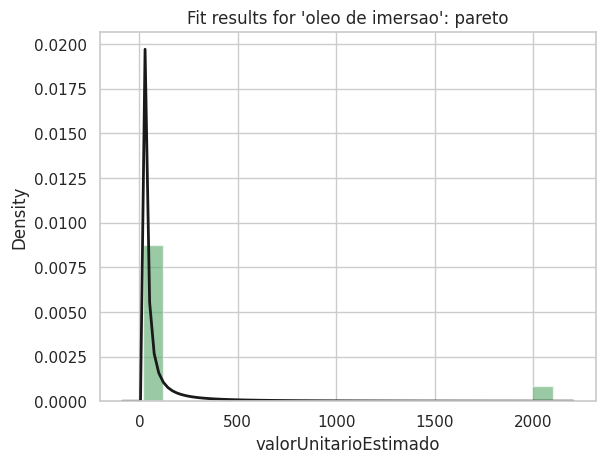

Best fitting distribution for 'carvedilol': weibull_min
Parameters: (0.656939920094736, 0.06999999999999999, 0.12573678350651005)
KS statistic: 0.20910178726424136
KS p-value: 0.12525275444297124
AIC: -89.77100109009999


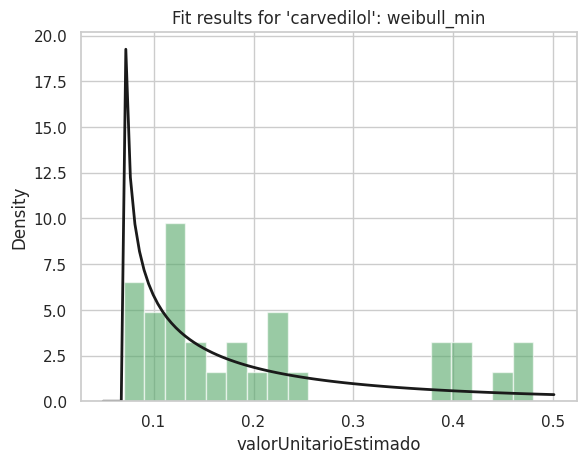

Best fitting distribution for 'mancal completo com flange': weibull_min
Parameters: (0.1204617407309169, 300.8399999999999, 19.798335770355884)
KS statistic: 0.3413197861482187
KS p-value: 0.6348329486729662
AIC: -8.464907460579028


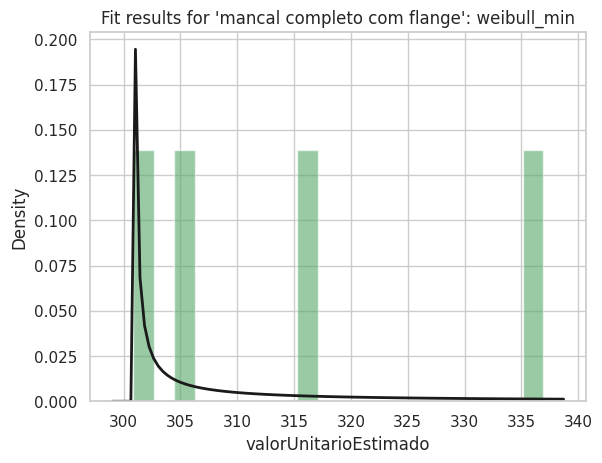

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2071: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:2512: RuntimeWarning: invalid value encountered in power
  return np.log(c) + sc.xlogy(c - 1, x) - pow(x, c)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7866: RuntimeWarning: divide by z

Failed to fit lognorm distribution for 'cateter mount traqueia corrugada regulavel retratil extensivel duplo giratorio que permita aspiracao traqueal e broncoscopias sem desconectar do respirador abertura superior com tampa extensao flexivel com memoria 9cm 1cm fechada e 16cm 2cm aberta traqueia corrugada com conector em cotovelo15mm interno e 22mm externo passivel de processamento embalagem 10 unidade' due to Optimization converged to parameters that are outside the range allowed by the distribution.
Failed to fit gamma distribution for 'cateter mount traqueia corrugada regulavel retratil extensivel duplo giratorio que permita aspiracao traqueal e broncoscopias sem desconectar do respirador abertura superior com tampa extensao flexivel com memoria 9cm 1cm fechada e 16cm 2cm aberta traqueia corrugada com conector em cotovelo15mm interno e 22mm externo passivel de processamento embalagem 10 unidade' due to Optimization converged to parameters that are outside the range allowed by the di

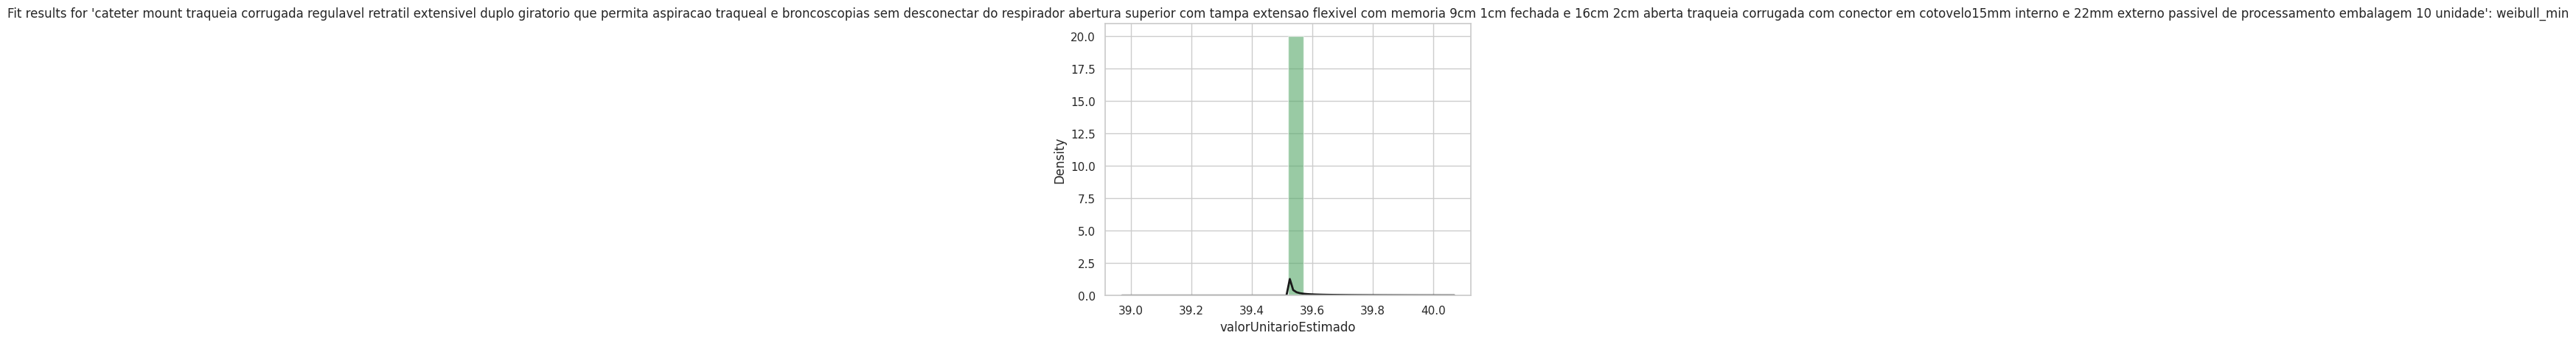

Failed to fit lognorm distribution for 'prego com cabeca dupla' due to Optimization converged to parameters that are outside the range allowed by the distribution.
Failed to fit gamma distribution for 'prego com cabeca dupla' due to Optimization converged to parameters that are outside the range allowed by the distribution.
Best fitting distribution for 'prego com cabeca dupla': weibull_min
Parameters: (0.021499999999973228, 20.689999999999998, 4.4613102756825294e-15)
KS statistic: 0.6303193503774256
KS p-value: 0.7393612992451488
AIC: -50.86270071224341


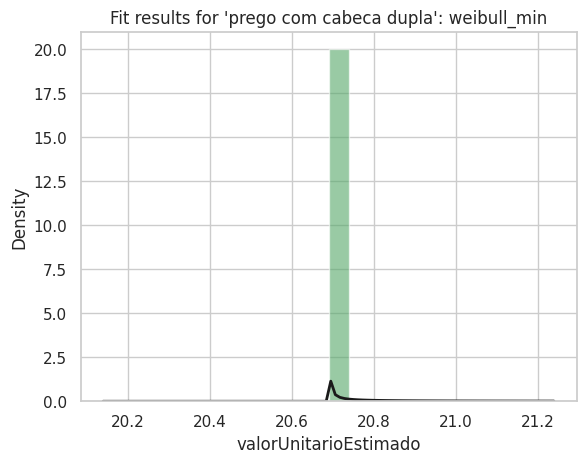

Best fitting distribution for 'enfeite': gamma
Parameters: (0.1208262632673072, 5.309999999999999, 59224.19878372384)
KS statistic: 0.254126572361488
KS p-value: 0.09701132510450794
AIC: 243.65679611279097


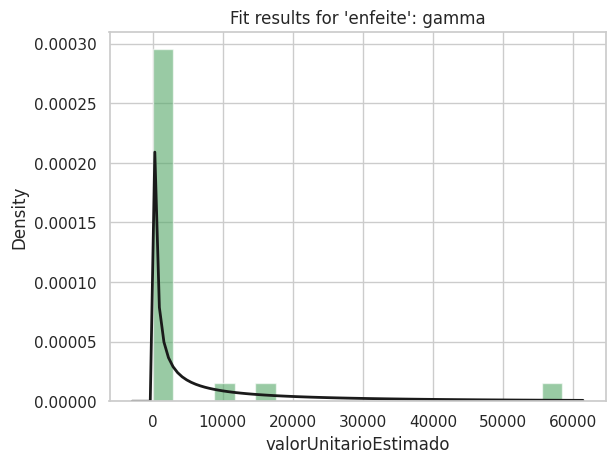

Best fitting distribution for 'faixa de esmarch': weibull_min
Parameters: (0.15425563582565843, 15.179999999999998, 9.225206351437933)
KS statistic: 0.35197724035513933
KS p-value: 0.7274432682547456
AIC: -27.17472250937263


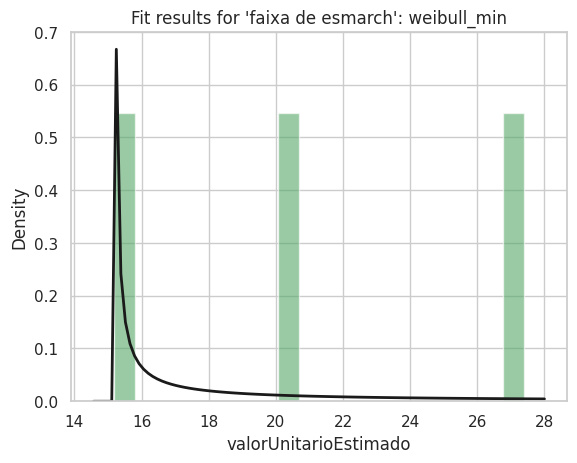

Best fitting distribution for 'acido etilenodiaminotetracetico edta': weibull_min
Parameters: (0.26930358802007714, 0.09999999999999999, 177.7109472920887)
KS statistic: 0.2679399127216433
KS p-value: 0.34509011261999245
AIC: 73.74148068938914


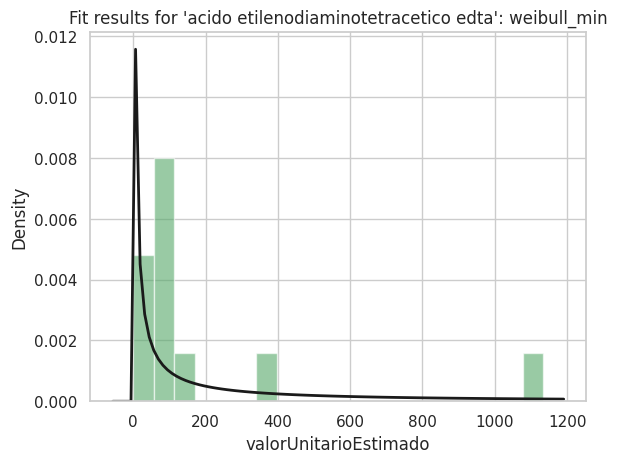

Best fitting distribution for 'grampo para cabo': gamma
Parameters: (0.7398324117803329, 1.3099999999999998, 2.5093381372286876)
KS statistic: 0.4490447657788276
KS p-value: 0.46102699943778525
AIC: 3.6474825618762123


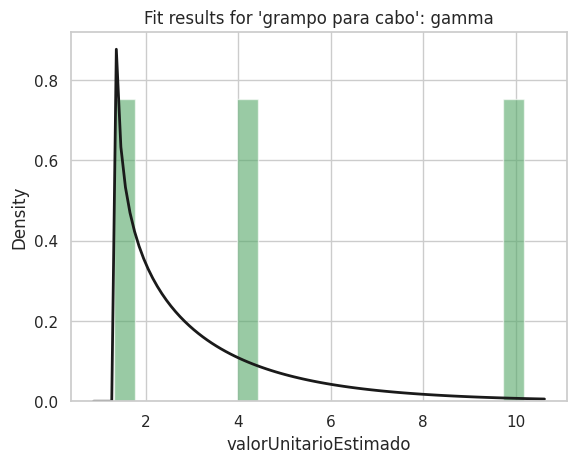

<ipython-input-40-d328263a062d>:53: RuntimeWarning: divide by zero encountered in log
  aic = 2 * len(params) - 2 * np.sum(np.log(dist.pdf(valores, *params)))


No suitable distribution found for 'condimento'
Best fitting distribution for 'puxador': weibull_min
Parameters: (0.5814479355580287, 4.859999999999999, 20.219213774464308)
KS statistic: 0.18923595211715283
KS p-value: 0.8475696687349005
AIC: 55.936861596294634


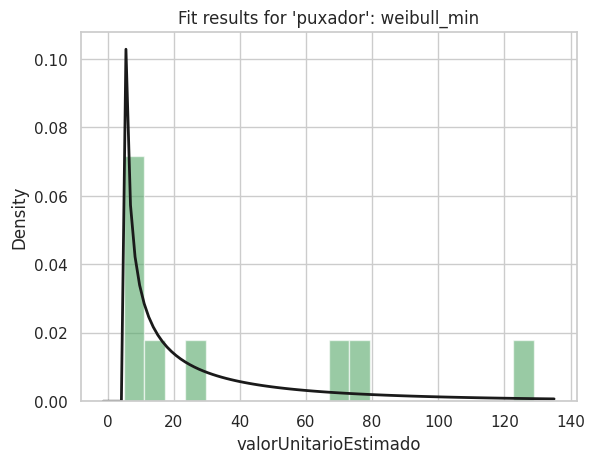

Best fitting distribution for 'enfeite natalino pisca pisca leds 08 funcoes embalagem 10 unidade': weibull_min
Parameters: (0.5879422247727505, 24.999999999999993, 2.9249679434074594)
KS statistic: 0.499999997444357
KS p-value: 0.5000000102225719
AIC: -12.131841409733653


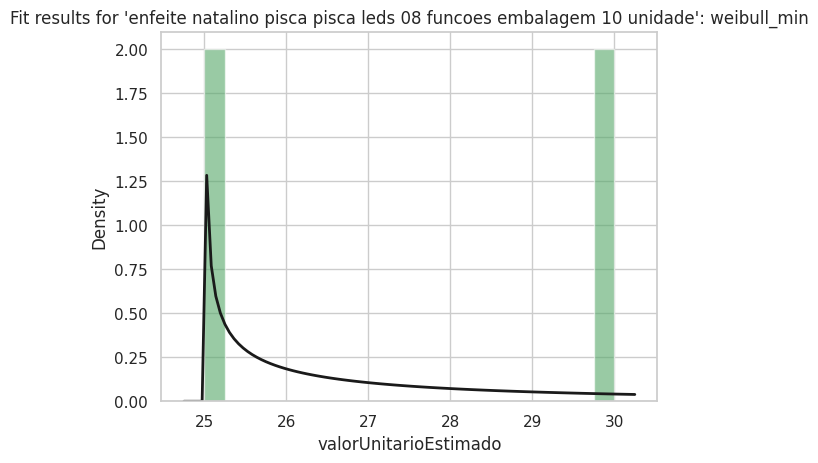

Failed to fit lognorm distribution for 'bagageiro veiculo' due to Optimization converged to parameters that are outside the range allowed by the distribution.
Failed to fit gamma distribution for 'bagageiro veiculo' due to Optimization converged to parameters that are outside the range allowed by the distribution.
Best fitting distribution for 'bagageiro veiculo': weibull_min
Parameters: (0.019277277176962405, 3161.999999999999, 0.00028481661706567906)
KS statistic: 0.5036654049289719
KS p-value: 0.9926691901420561
AIC: -39.428219015098506


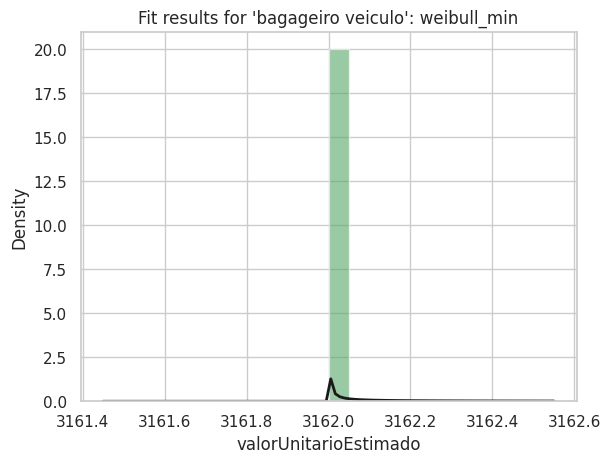

Best fitting distribution for 'parafuso com porca': weibull_min
Parameters: (0.2400776896023712, 1.1999999999999997, 5.128966229953143)
KS statistic: 0.3901996227800706
KS p-value: 0.0699441214770643
AIC: 33.15184342634748


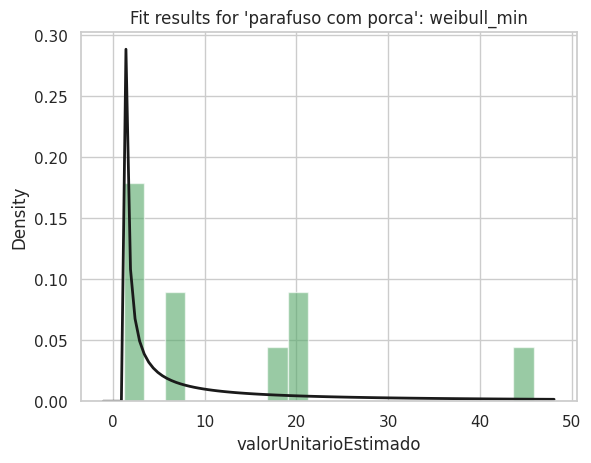

Best fitting distribution for 'forno eletrico': weibull_min
Parameters: (0.4028820343450481, 478.79999999999995, 1441.5099564513794)
KS statistic: 0.2642611024740398
KS p-value: 0.116464856803137
AIC: 280.5179529310897


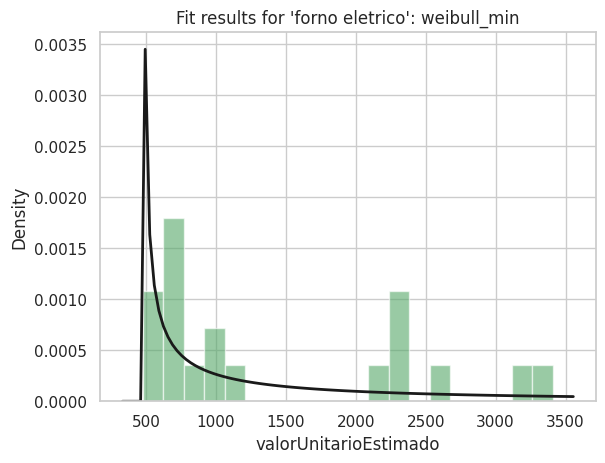

Failed to fit lognorm distribution for 'laboratorio de eletromecanica automacao industrial plataforma arduino uno r3 compativel com cabo usb embalagem 10 unidade' due to Optimization converged to parameters that are outside the range allowed by the distribution.
Failed to fit gamma distribution for 'laboratorio de eletromecanica automacao industrial plataforma arduino uno r3 compativel com cabo usb embalagem 10 unidade' due to Optimization converged to parameters that are outside the range allowed by the distribution.
Best fitting distribution for 'laboratorio de eletromecanica automacao industrial plataforma arduino uno r3 compativel com cabo usb embalagem 10 unidade': weibull_min
Parameters: (0.019277267767789145, 128.99999999999997, 0.00028481915557218145)
KS statistic: 0.526492010293405
KS p-value: 0.94701597941319
AIC: -46.31471800664698


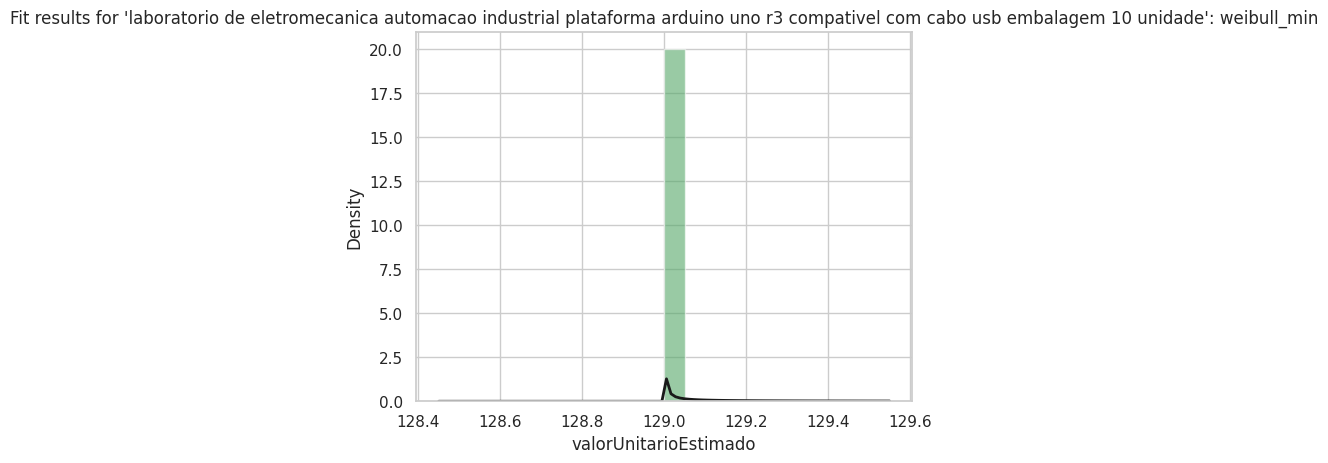

Best fitting distribution for 'vincristina': weibull_min
Parameters: (0.26935860937719347, 32.29999999999999, 10.650924944838302)
KS statistic: 0.3177111527736731
KS p-value: 0.594015247501295
AIC: -5.094060259330842


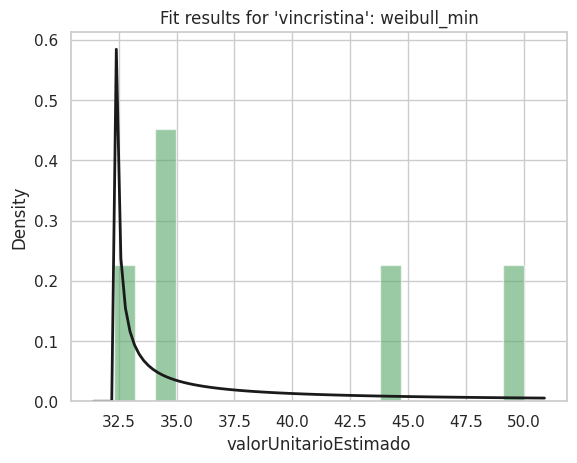

Best fitting distribution for 'dexlansoprazol': weibull_min
Parameters: (0.7948835209623912, 3.1399999999999997, 0.38893788480094565)
KS statistic: 0.49999999999867406
KS p-value: 0.5000000000053038
AIC: -7.928872388059698


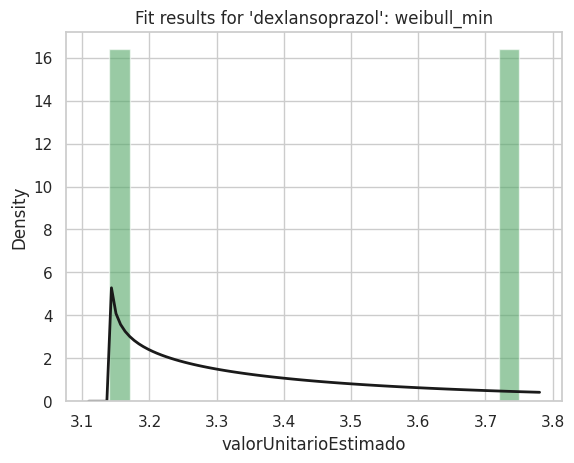

Best fitting distribution for 'deoxinucleotideo': gamma
Parameters: (0.4535045213307298, 373.68999999999994, 1233.65831700139)
KS statistic: 0.532027891248591
KS p-value: 0.13999869196878167
AIC: 37.753472678938294


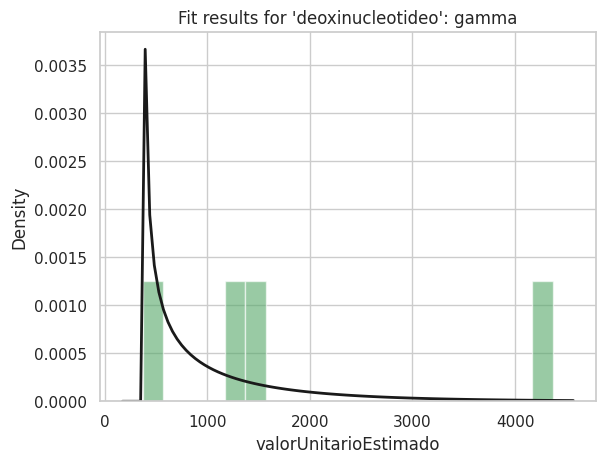

Best fitting distribution for 'clorexidina digluconato': gamma
Parameters: (0.8393123744547577, 1.4535999999999767, 19.64217885814683)
KS statistic: 0.1576714858119017
KS p-value: 0.06072743223774034
AIC: 515.4084834606581


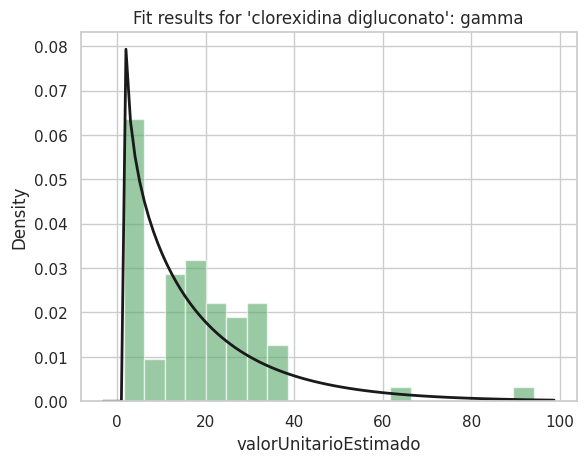

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming df_merged is your DataFrame

# Get all unique values from descricao_normalized
unique_words = df_merged['descricao_normalized'].unique()

# Choose 20 random words
random_words = random.sample(list(unique_words), 20)

# Loop through the random words
for word in random_words:
    # Filter for the current word in descricao_normalized
    word_data = df_merged[df_merged['descricao_normalized'] == word]

    # Extract valorUnitarioEstimado for the current word
    valores = word_data['valorUnitarioEstimado'].values

    # Handle non-numeric values: convert to numeric and drop NaN values
    valores = pd.to_numeric(valores, errors='coerce')
    valores = valores[~np.isnan(valores)]

    if len(valores) == 0:
        print(f"No valid numerical data for '{word}'")
        continue

    # Fit distributions
    dist_names = ['norm', 'lognorm', 'gamma', 'expon', 'weibull_min', 'pareto']
    best_fit_name = None
    best_fit_params = None
    best_fit_ks_statistic = 0
    best_fit_ks_p_value = 0
    best_fit_aic = float('inf')

    for dist_name in dist_names:
        try:
            dist = getattr(stats, dist_name)

            # Provide starting values for the parameters, especially for 'lognorm'
            if dist_name == 'lognorm':
                params = dist.fit(valores, floc=0, fscale=np.std(valores))
            else:
                params = dist.fit(valores)

            # Calculate goodness-of-fit (Kolmogorov-Smirnov test)
            ks_statistic, ks_p_value = stats.kstest(valores, dist_name, args=params)

            # Calculate AIC
            aic = 2 * len(params) - 2 * np.sum(np.log(dist.pdf(valores, *params)))

            # Check if this is the best fit so far
            if aic < best_fit_aic and ks_p_value > 0.05:  # Example threshold for KS test
                best_fit_name = dist_name
                best_fit_params = params
                best_fit_ks_statistic = ks_statistic
                best_fit_ks_p_value = ks_p_value
                best_fit_aic = aic

        except Exception as e:
            print(f"Failed to fit {dist_name} distribution for '{word}' due to {str(e)}")
            continue  # Skip to the next distribution

    # Print results
    if best_fit_name:
        print(f"Best fitting distribution for '{word}': {best_fit_name}")
        print(f"Parameters: {best_fit_params}")
        print(f"KS statistic: {best_fit_ks_statistic}")
        print(f"KS p-value: {best_fit_ks_p_value}")
        print(f"AIC: {best_fit_aic}")

        # (Optional) Visualize the results
        plt.hist(valores, bins=20, density=True, alpha=0.6, color='g')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        pdf = getattr(stats, best_fit_name).pdf(x, *best_fit_params)
        plt.plot(x, pdf, 'k', linewidth=2)
        title = f"Fit results for '{word}': {best_fit_name}"
        plt.title(title)
        plt.xlabel('valorUnitarioEstimado')
        plt.ylabel('Density')
        plt.show()
    else:
        print(f"No suitable distribution found for '{word}'")

In [ ]:
# prompt: normalize sum_valorUnitarioEstimadoPoints from 0 to 10 and call the new column  score_valorUnitarioEstimadoPoints

# Normalize 'sum_valorUnitarioEstimadoPoints' from 0 to 10
df_merged['score_valorUnitarioEstimadoPoints'] = (
    (df_merged['sum_valorUnitarioEstimadoPoints'] - df_merged['sum_valorUnitarioEstimadoPoints'].min()) /
    (df_merged['sum_valorUnitarioEstimadoPoints'].max() - df_merged['sum_valorUnitarioEstimadoPoints'].min()) * 10
)


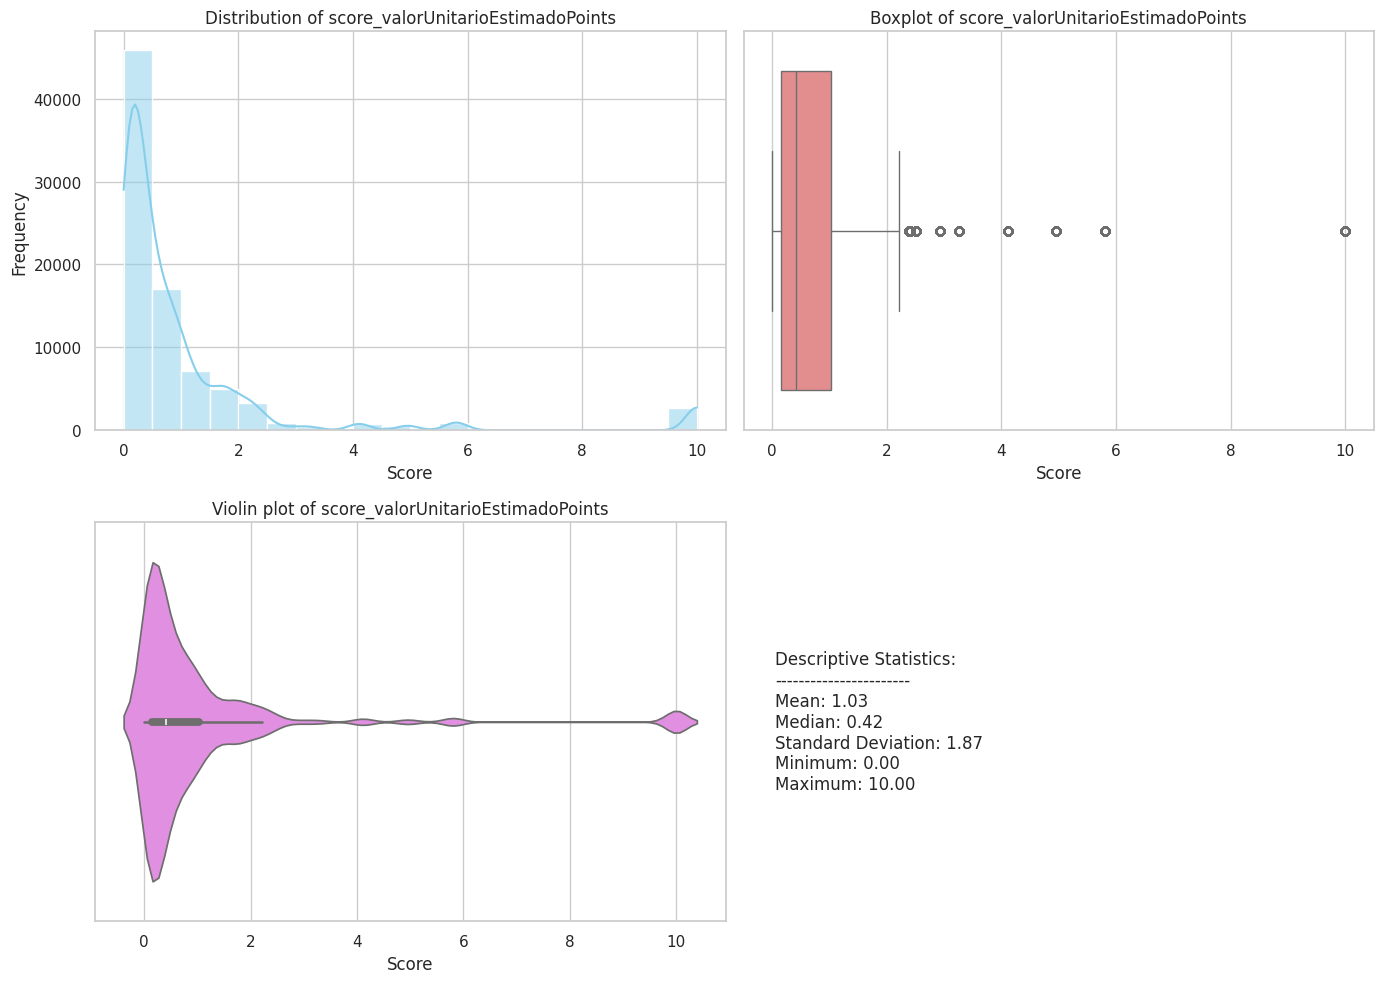

In [ ]:
# prompt: plot statistics and intel about score_valorUnitarioEstimadoPoints

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure and axes for multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of score_valorUnitarioEstimadoPoints
sns.histplot(df_merged['score_valorUnitarioEstimadoPoints'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of score_valorUnitarioEstimadoPoints')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')

# 2. Boxplot of score_valorUnitarioEstimadoPoints (for spread and outliers)
sns.boxplot(x=df_merged['score_valorUnitarioEstimadoPoints'], ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Boxplot of score_valorUnitarioEstimadoPoints')
axes[0, 1].set_xlabel('Score')

# 3. Violin plot (to show distribution and density)
sns.violinplot(x=df_merged['score_valorUnitarioEstimadoPoints'], ax=axes[1, 0], color='violet')
axes[1, 0].set_title('Violin plot of score_valorUnitarioEstimadoPoints')
axes[1, 0].set_xlabel('Score')

# 4. Descriptive Statistics Summary
stats_summary = df_merged['score_valorUnitarioEstimadoPoints'].describe()
stats_text = f"""
Descriptive Statistics:
-----------------------
Mean: {stats_summary['mean']:.2f}
Median: {stats_summary['50%']:.2f}
Standard Deviation: {stats_summary['std']:.2f}
Minimum: {stats_summary['min']:.2f}
Maximum: {stats_summary['max']:.2f}
"""

axes[1, 1].text(0.05, 0.5, stats_text, fontsize=12, va='center')  # Adjust coordinates as needed
axes[1, 1].axis('off')  # Remove axis ticks and labels

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# prompt: add a column to df_merged that sums all columns that start with score

# Get a list of columns that start with 'score_'
score_columns = [col for col in df_merged.columns if col.startswith('score_')]

# Calculate the sum of score columns
df_merged['total_score'] = df_merged[score_columns].sum(axis=1)

# Print 20 sample rows in Markdown format
print(df_merged.sample(20).to_markdown(index=False, numalign="left", stralign="left"))

| id                               | index    | doc_type   | title                                         | description                                                                                                                                                                                                                                                                                                                                                                                                                                         | item_url                           | document_type   | createdAt            | numero   | ano   | numero_sequencial   | numero_sequencial_compra_ata   | numero_controle_pncp         | orgao_id   | orgao_cnpj     | orgao_nome                                                                 | orgao_subrogado_id   | orgao_subrogado_nome   | unidade_id   | unidade_codigo   | unidade_nome                                  | esfera_id   | esfera_nome   | pod

count   84,306.00
mean        81.30
std         16.76
min         22.14
25%         69.52
50%         81.00
75%         91.38
max        138.25
Name: total_score, dtype: float64


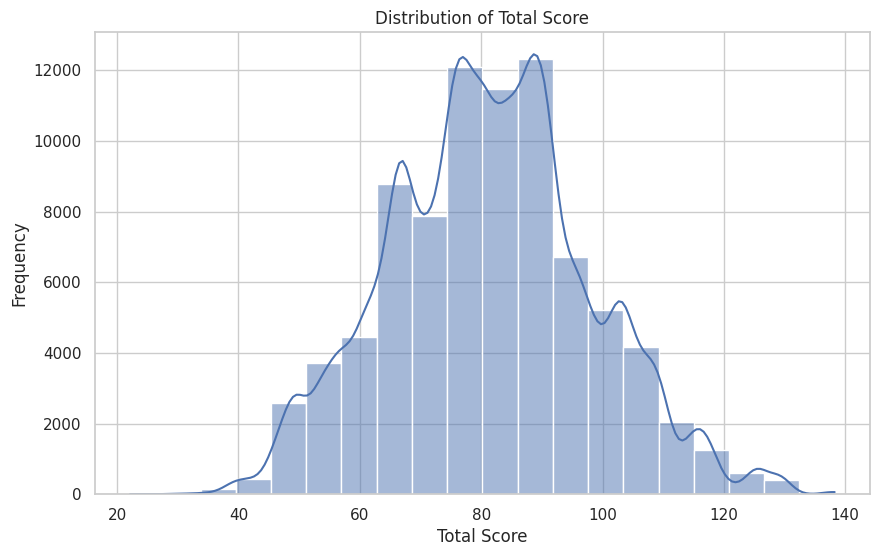

In [ ]:
# prompt: give me the data dristibution and othe statistical analisys for total_score, also graphs.

import matplotlib.pyplot as plt
import seaborn as sns

# Data distribution
print(df_merged['total_score'].describe())

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['total_score'], bins=20, kde=True)
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.title('Distribution of Total Score')
plt.show()

Unique values and their counts for 'modalidade_licitacao_nome':
 modalidade_licitacao_nome
Pregão - Eletrônico          78321
Dispensa                      5978
Concorrência - Eletrônica        5
Dispensa de Licitação            2
Name: count, dtype: int64

Percentage of each value:
 modalidade_licitacao_nome
Pregão - Eletrônico         92.90
Dispensa                     7.09
Concorrência - Eletrônica    0.01
Dispensa de Licitação        0.00
Name: count, dtype: float64


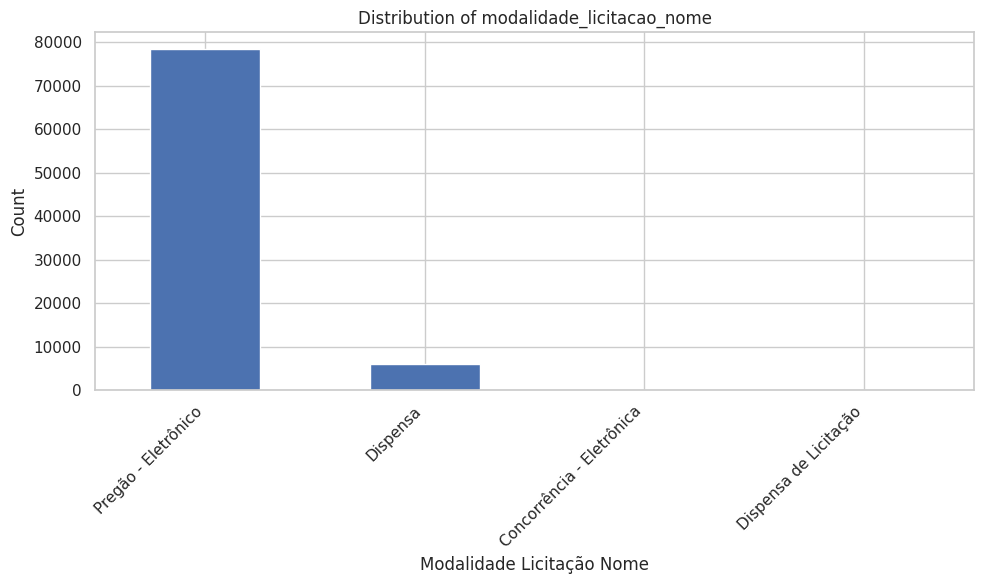

In [ ]:
# prompt: give me intel about modalidade_licitacao_nome

# Get unique values and their counts for 'modalidade_licitacao_nome'
modalidade_counts = df_merged['modalidade_licitacao_nome'].value_counts()

print("Unique values and their counts for 'modalidade_licitacao_nome':\n", modalidade_counts)

# Calculate the percentage of each value
modalidade_percentages = modalidade_counts / len(df_merged) * 100
print("\nPercentage of each value:\n", modalidade_percentages)

# Plot the distribution
plt.figure(figsize=(10, 6))
modalidade_counts.plot(kind='bar')
plt.title('Distribution of modalidade_licitacao_nome')
plt.xlabel('Modalidade Licitação Nome')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# prompt: save df_merged full content in google drive. create a specific folder for it and print info about file size and other relevant intel

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path in Google Drive
folder_path = '/content/drive/MyDrive/df_merged_data'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
  os.makedirs(folder_path)

# Define the file path
file_path = os.path.join(folder_path, 'df_merged.csv')

# Save the DataFrame to a CSV file
df_merged.to_csv(file_path, index=False)

# Get file size
file_size = os.path.getsize(file_path)
print(f"File size: {file_size} bytes")

# Get file creation time
creation_time = os.path.getctime(file_path)
print(f"File creation time: {creation_time}")

# Get file modification time
modification_time = os.path.getmtime(file_path)
print(f"File modification time: {modification_time}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File size: 137740259 bytes
File creation time: 1729595800.0
File modification time: 1729595800.0


       valorUnitarioEstimado_mean  valorUnitarioEstimado_median  valorUnitarioEstimado_75percentile  valorUnitarioEstimado_95percentile  count_rows  valorUnitarioEstimado_mode  valorUnitarioEstimadoPoints  sum_valorUnitarioEstimadoPoints
count                   84,306.00                     84,306.00                      84,306.00                           84,306.00        84,306.00                   84,306.00                    84,306.00                      84,306.00  
mean                     1,411.83                        848.65                       1,455.50                            3,697.75           190.63                      696.18                         2.12                         383.51  
std                      7,735.87                      6,748.28                       9,039.36                           18,417.52           477.53                    5,578.28                         1.72                         697.89  
min                          0.03               

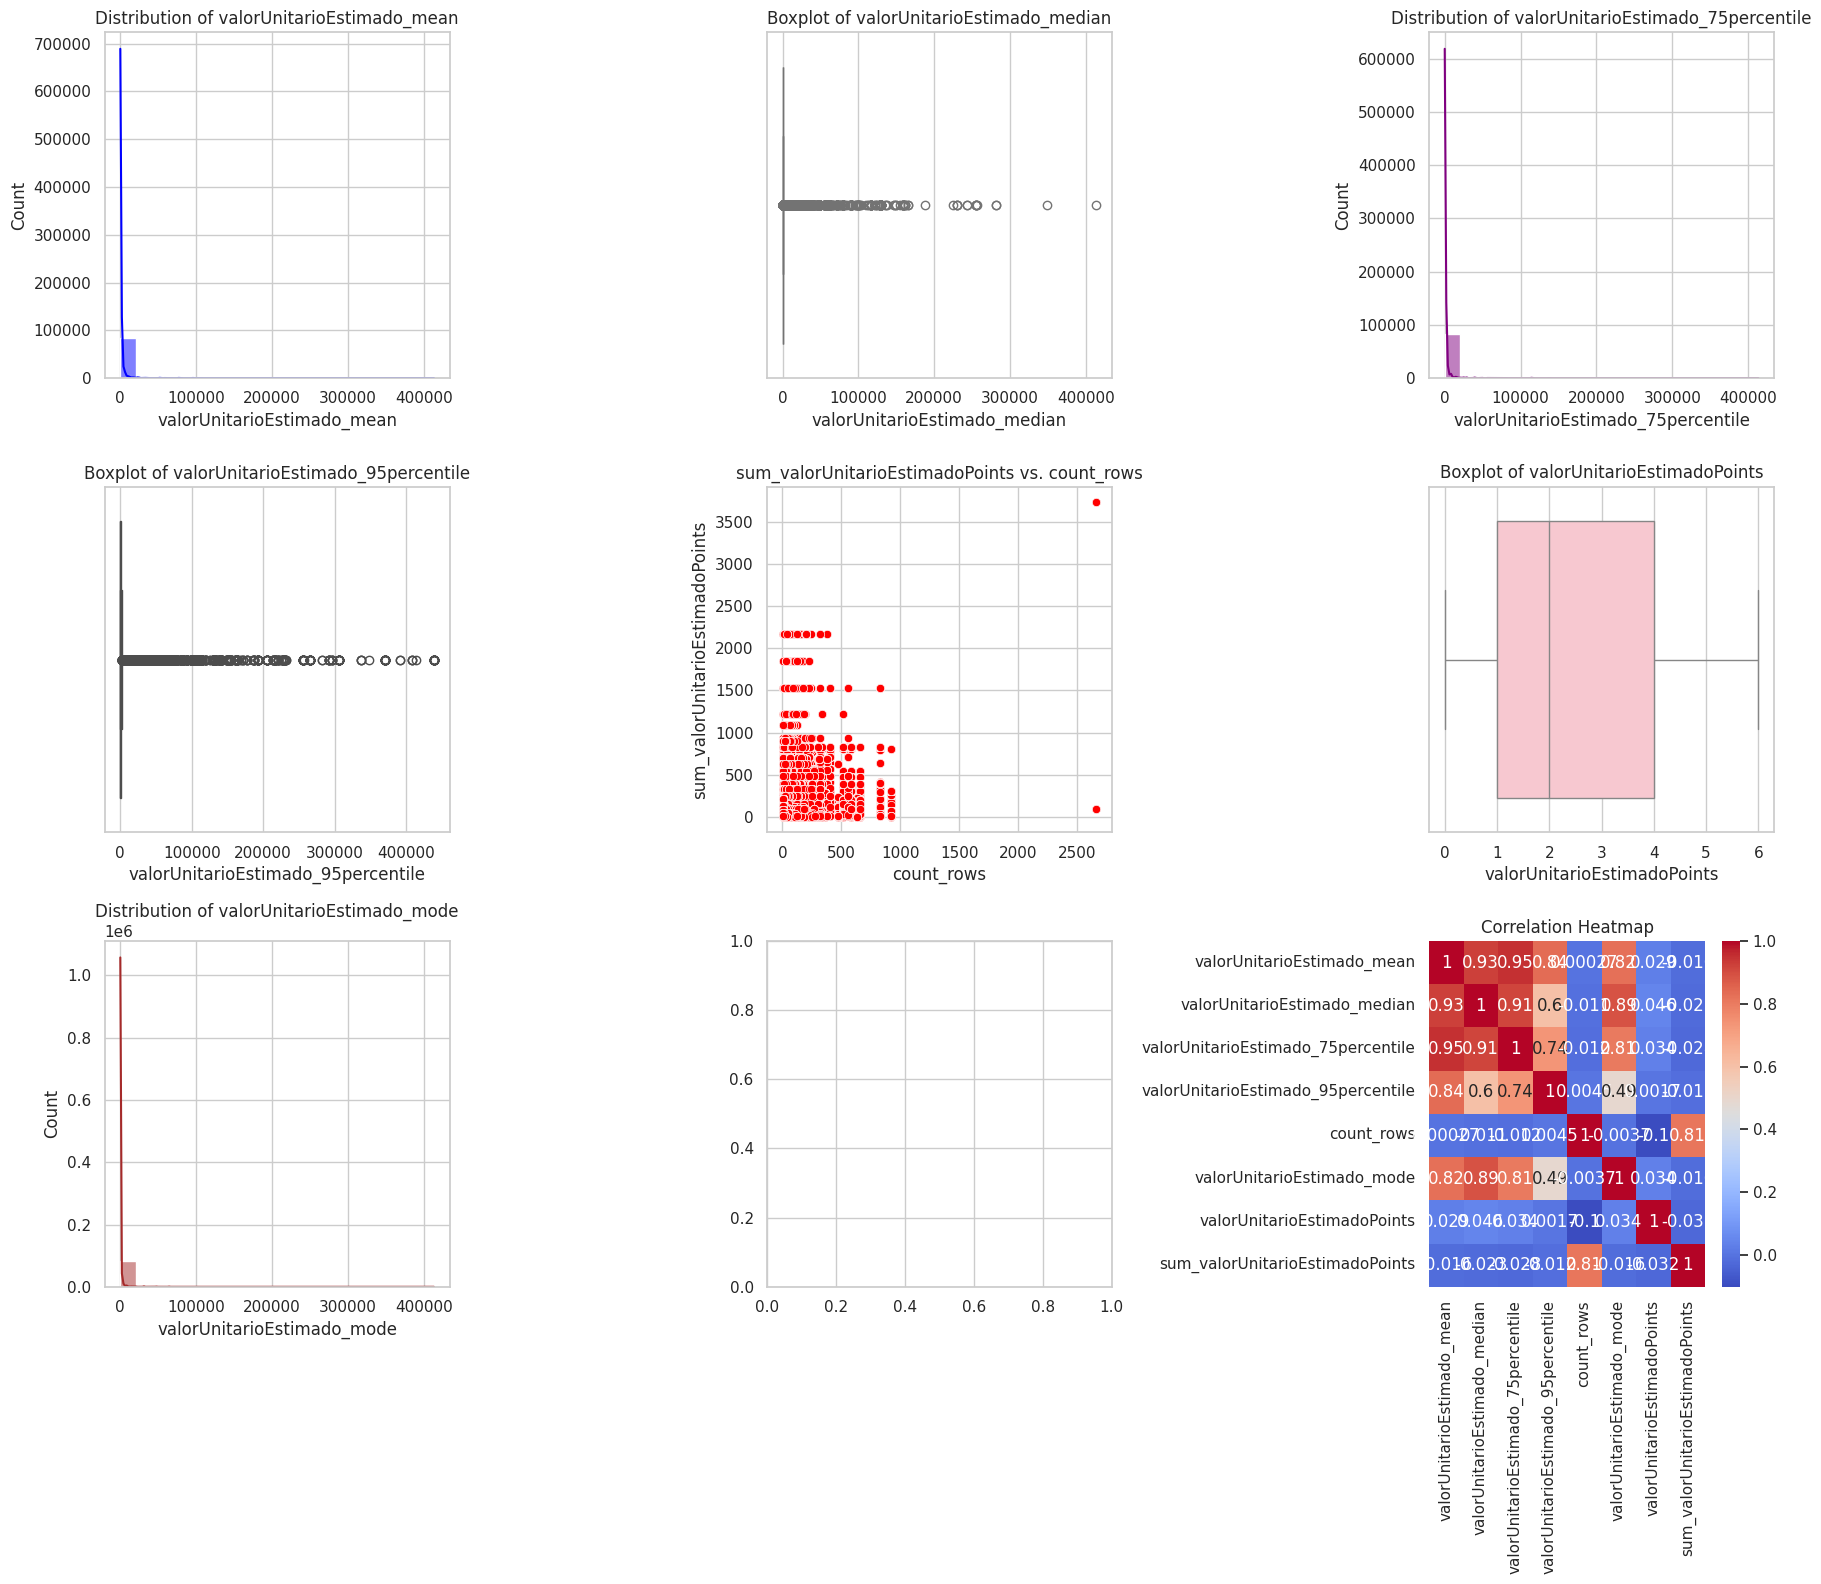

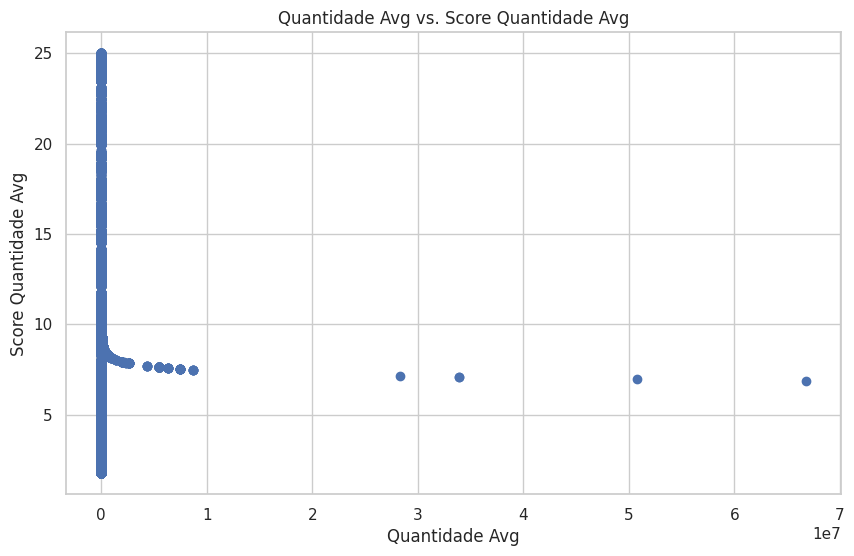

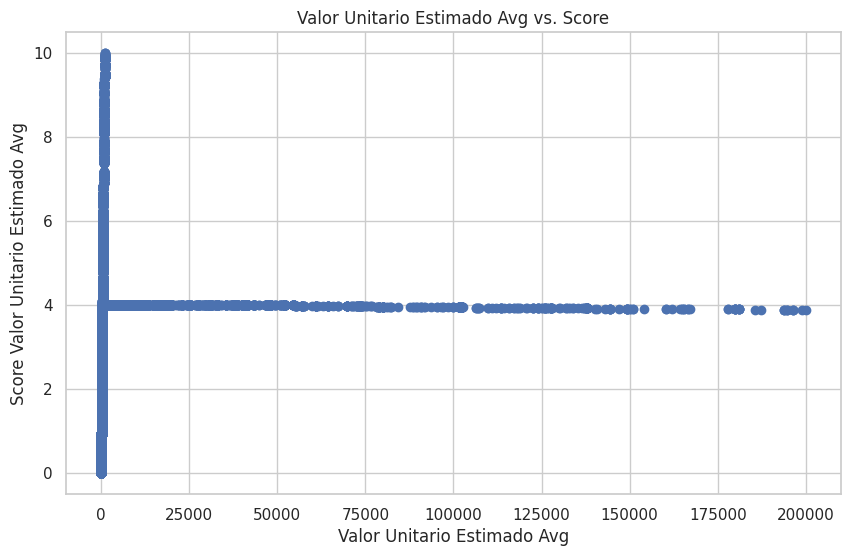

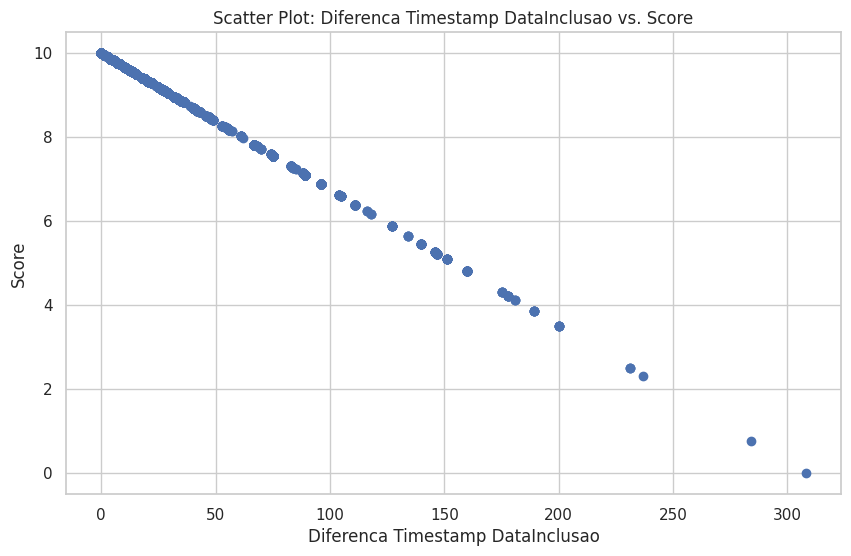

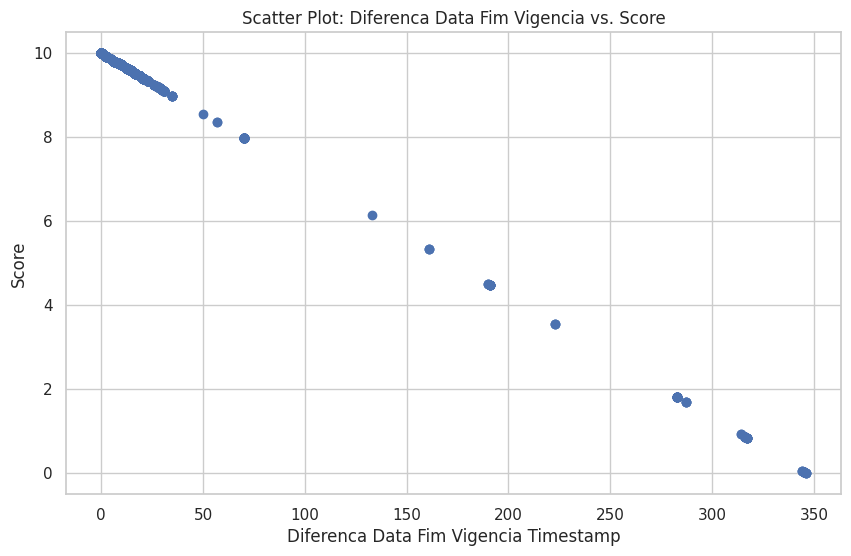

In [ ]:
# Descriptive statistics for the key columns
columns_to_describe = [
    'valorUnitarioEstimado_mean', 'valorUnitarioEstimado_median', 'valorUnitarioEstimado_75percentile',
    'valorUnitarioEstimado_95percentile', 'count_rows', 'valorUnitarioEstimado_mode', 'valorUnitarioEstimadoPoints', 'sum_valorUnitarioEstimadoPoints'
]

# Display descriptive statistics
print(df_merged[columns_to_describe].describe())

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Create figure and axes for subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 16))  # Adjust grid size based on number of metrics

# 1. Histogram of valorUnitarioEstimado_mean
sns.histplot(df_merged['valorUnitarioEstimado_mean'], bins=20, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Distribution of valorUnitarioEstimado_mean')

# 2. Boxplot of valorUnitarioEstimado_median
sns.boxplot(x=df_merged['valorUnitarioEstimado_median'], ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Boxplot of valorUnitarioEstimado_median')

# 3. Histogram of valorUnitarioEstimado_75percentile
sns.histplot(df_merged['valorUnitarioEstimado_75percentile'], bins=20, kde=True, ax=axes[0, 2], color='purple')
axes[0, 2].set_title('Distribution of valorUnitarioEstimado_75percentile')

# 4. Boxplot of valorUnitarioEstimado_95percentile
sns.boxplot(x=df_merged['valorUnitarioEstimado_95percentile'], ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Boxplot of valorUnitarioEstimado_95percentile')

# 5. Scatter plot: sum_valorUnitarioEstimadoPoints vs. count_rows
sns.scatterplot(x=df_merged['count_rows'], y=df_merged['sum_valorUnitarioEstimadoPoints'], ax=axes[1, 1], color='red')
axes[1, 1].set_title('sum_valorUnitarioEstimadoPoints vs. count_rows')

# 6. Boxplot of valorUnitarioEstimadoPoints
sns.boxplot(x=df_merged['valorUnitarioEstimadoPoints'], ax=axes[1, 2], color='pink')
axes[1, 2].set_title('Boxplot of valorUnitarioEstimadoPoints')

# 7. Histogram of valorUnitarioEstimado_mode1
sns.histplot(df_merged['valorUnitarioEstimado_mode'], bins=20, kde=True, ax=axes[2, 0], color='brown')
axes[2, 0].set_title('Distribution of valorUnitarioEstimado_mode')



# 9. Heatmap of correlations between numeric columns
correlation_matrix = df_merged[columns_to_describe].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[2, 2])
axes[2, 2].set_title('Correlation Heatmap')

# Adjust layout
plt.tight_layout()
plt.show()

# 1. Scatter plot for quantidade_avg vs score_quantidade_avg
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['quantidade_avg'], df_merged['score_quantidade_avg'])
plt.xlabel('Quantidade Avg')
plt.ylabel('Score Quantidade Avg')
plt.title('Quantidade Avg vs. Score Quantidade Avg')
plt.grid(True)
plt.show()

# 2. Scatter plot for valorUnitarioEstimado_avg vs score_valorUnitarioEstimado_avg
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['valorUnitarioEstimado_avg'], df_merged['score_valorUnitarioEstimado_avg'])
plt.xlabel('Valor Unitario Estimado Avg')
plt.ylabel('Score Valor Unitario Estimado Avg')
plt.title('Valor Unitario Estimado Avg vs. Score')
plt.grid(True)
plt.show()

# Scatter plot for diferenca_timestamp_dataInclusao vs score_diferenca_timestamp_dataInclusao
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['diferenca_timestamp_dataInclusao'], df_merged['score_diferenca_timestamp_dataInclusao'])
plt.xlabel('Diferenca Timestamp DataInclusao')
plt.ylabel('Score')
plt.title('Scatter Plot: Diferenca Timestamp DataInclusao vs. Score')
plt.grid(True)
plt.show()

# Scatter plot for diferenca_data_fim_vigencia_timestamp vs score_diferenca_data_fim_vigencia_timestamp
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['diferenca_data_fim_vigencia_timestamp'], df_merged['score_diferenca_data_fim_vigencia_timestamp'])
plt.xlabel('Diferenca Data Fim Vigencia Timestamp')
plt.ylabel('Score')
plt.title('Scatter Plot: Diferenca Data Fim Vigencia vs. Score')
plt.grid(True)
plt.show()


# Print resulting scores

In [ ]:
import pandas as pd
from collections import Counter

def format_brl(value):
    """
    Format large BRL numbers into readable currency format (e.g., R$ 1.5M, R$ 2.7B).
    """
    if value >= 1e9:
        return f"R$ {value / 1e9:.2f}B"
    elif value >= 1e6:
        return f"R$ {value / 1e6:.2f}M"
    elif value >= 1e3:
        return f"R$ {value / 1e3:.2f}K"
    else:
        return f"R$ {value:.2f}"

# Quantity of unique values for specific columns
unique_orgao_nome = df_merged['orgao_nome'].nunique()
unique_unidade_nome = df_merged['unidade_nome'].nunique()
unique_municipio_nome = df_merged['municipio_nome'].nunique()
unique_descricao_normalized = df_merged['descricao_normalized'].nunique()
unique_numero_controle_pncp = df_merged['numero_controle_pncp'].nunique()

# Print the results in Markdown format
print(f"Statistics Overview")
# Print the first value from the 'timestamp_data_scarping' column
print(df_merged['timestamp_data_scarping'].iloc[0])
print(f"{'-'*80}")
print(f"Unique Values:")
print(f"  - Unique 'orgao_nome': {unique_orgao_nome}")
print(f"  - Unique 'unidade_nome': {unique_unidade_nome}")
print(f"  - Unique 'municipio_nome': {unique_municipio_nome}")
print(f"  - Unique 'descricao_normalized': {unique_descricao_normalized}")
print(f"  - Unique 'numero_controle_pncp': {unique_numero_controle_pncp}")
print(f"{'-'*80}")

# Total 'valor_total_licitacao' in BRL
total_valor_total_licitacao = df_merged['valor_total_licitacao'].sum()
print(f"Total Value of Licitations (BRL):")
print(f"  - Total 'valor_total_licitacao' across all entries: {format_brl(total_valor_total_licitacao)}")
print(f"{'-'*80}")

# Total 'valor_total_licitacao' per 'orgao_nome' and 'orgao_id'
total_valor_per_orgao = df_merged.groupby(['orgao_id', 'orgao_nome'])['valor_total_licitacao'].sum().sort_values(ascending=False)

print(f"Total Value of Licitations per Orgao (BRL):")
# Apply format_brl to the 'valor_total_licitacao' column before converting to DataFrame
total_valor_per_orgao_formatted = total_valor_per_orgao.apply(format_brl)
print(pd.DataFrame(total_valor_per_orgao_formatted.head(10)).to_markdown(numalign="left", stralign="left", headers=["Orgao (ID)", "Valor"]))
print(f"{'-'*80}")

# Total 'valor_total_licitacao' per 'unidade_nome' and 'unidade_codigo'
total_valor_per_unidade = df_merged.groupby(['unidade_codigo', 'unidade_nome'])['valor_total_licitacao'].sum().sort_values(ascending=False)

print(f"Total Value of Licitations per Unidade (BRL):")
# Apply format_brl to the 'valor_total_licitacao' column before converting to DataFrame
total_valor_per_unidade_formatted = total_valor_per_unidade.apply(format_brl)
print(pd.DataFrame(total_valor_per_unidade_formatted.head(10)).to_markdown(numalign="left", stralign="left", headers=["Unidade (Codigo)", "Valor"]))
print(f"{'-'*80}")

# Total 'valor_total_licitacao' per 'municipio_nome'
total_valor_per_municipio = df_merged.groupby('municipio_nome')['valor_total_licitacao'].sum().sort_values(ascending=False)

print(f"Total Value of Licitations per Municipio (BRL):")
# Apply format_brl to the 'valor_total_licitacao' column before converting to DataFrame
total_valor_per_municipio_formatted = total_valor_per_municipio.apply(format_brl)
print(pd.DataFrame(total_valor_per_municipio_formatted.head(10)).to_markdown(numalign="left", stralign="left", headers=["Municipio", "Valor"]))
print(f"{'-'*80}")

# Top 30 'descricao_normalized' in repetition with 'valorTotal' and 'quantidade'
top_30_descricao = df_merged.groupby('descricao_normalized').agg({'valorTotal': 'sum', 'quantidade': 'sum'}).sort_values(by='valorTotal', ascending=False).head(30)

# Format 'valorTotal' with the BRL format
top_30_descricao['valorTotal'] = top_30_descricao['valorTotal'].apply(format_brl)

print(f"Top 30 Descriptions by Total Value and Quantity (in BRL):")
print(top_30_descricao.to_markdown(numalign="left", stralign="left"))
print(f"{'-'*80}")

# prompt: print top 10 words in concatenated_words considering only unique rows of numero_controle_pncp
# Get unique rows based on 'numero_controle_pncp'
unique_df = df_merged.drop_duplicates(subset=['numero_controle_pncp'])

# Flatten the 'concatenated_words' column into a single list
all_words = [word for sublist in unique_df['concatenated_words'].tolist() for word in sublist]

# Count the occurrences of each word
word_counts = Counter(all_words)

# Get the top 10 most frequent words
top_10_words = word_counts.most_common(10)

print(f"Top 10 words in concatenated_words (unique 'numero_controle_pncp'):")
print(pd.DataFrame(top_10_words, columns=["Word", "Count"]).to_markdown(index=False, numalign="left", stralign="left"))

Statistics Overview
2024-10-22 08:13:38.624005-03:00
--------------------------------------------------------------------------------
Unique Values:
  - Unique 'orgao_nome': 703
  - Unique 'unidade_nome': 1690
  - Unique 'municipio_nome': 591
  - Unique 'descricao_normalized': 6879
  - Unique 'numero_controle_pncp': 3735
--------------------------------------------------------------------------------
Total Value of Licitations (BRL):
  - Total 'valor_total_licitacao' across all entries: R$ 300.51B
--------------------------------------------------------------------------------
Total Value of Licitations per Orgao (BRL):
| Orgao (ID)                                                | Valor     |
|:----------------------------------------------------------|:----------|
| (45877, 'MINISTERIO DA JUSTICA E SEGURANCA PUBLICA')      | R$ 44.76B |
| (44611, 'COMANDO DO EXERCITO')                            | R$ 29.86B |
| (2049, 'MUNICIPIO DE PARNAMIRIM')                         | R$ 21.91B |
| 

In [ ]:
import pandas as pd

# Ensure all content in the cells is fully displayed
pd.set_option('display.max_colwidth', None)  # No limit on column width
pd.set_option('display.max_rows', None)      # Show all rows if needed (optional)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')  # Two decimal places globally

# Sort the DataFrame by 'total_score' in descending order and select the top 40 unique 'numero_controle_pncp'
top_40 = df_merged.sort_values(by='total_score', ascending=False).drop_duplicates(subset='numero_controle_pncp').head(40)

# Select the desired columns and format the 'valor_total_licitacao' column
score_columns = top_40.filter(like='score_').columns.tolist()
top_40 = top_40[['total_score', 'data_fim_vigencia_iso8601', 'concatenated_words', 'description_normalized',
                 'modalidade_licitacao_nome', 'municipio_nome', 'uf', 'unidade_nome', 'unidade_codigo',
                 'orgao_id', 'orgao_nome', 'valor_total_licitacao', 'count_line_items', 'new_item_url',
                 'timestamp_data_scarping', 'numero_controle_pncp', 'title'] + score_columns].copy()

# Format 'valor_total_licitacao' for better visualization
top_40['valor_total_licitacao'] = top_40['valor_total_licitacao'].apply(
    lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.') + ' BRL'
)

# Display the result in Markdown format
print(top_40.to_markdown(index=False, numalign="left", stralign="left"))

| total_score   | data_fim_vigencia_iso8601   | concatenated_words                                                                                                                                                                                                                                                                                                                                                                                                                                       | description_normalized                                                                                                                                                                                                                                                                                                                                                                                                             | modalidade_licitacao_nome   | municipio_nome      | uf   | unidade_nome                 

In [ ]:
import pandas as pd

# ... (your previous code) ...

# Filter the DataFrame to include rows where 'modalidade_licitacao_nome' contains 'Dispensa'
dispensa_df = df_merged[df_merged['modalidade_licitacao_nome'].str.contains('Dispensa', na=False)]

# Sort the filtered DataFrame by 'total_score' in descending order and select the top 40 unique 'numero_controle_pncp'
top_40_dispensa = dispensa_df.sort_values(by='total_score', ascending=False).drop_duplicates(subset='numero_controle_pncp').head(40)

# Select the desired columns and format the 'valor_total_licitacao' column
score_columns = top_40_dispensa.filter(like='score_').columns.tolist()
top_40_dispensa = top_40_dispensa[['total_score', 'data_fim_vigencia_iso8601', 'concatenated_words', 'description_normalized',
                                   'modalidade_licitacao_nome', 'municipio_nome', 'uf', 'unidade_nome', 'unidade_codigo',
                                   'orgao_id', 'orgao_nome', 'valor_total_licitacao', 'count_line_items', 'new_item_url',
                                   'timestamp_data_scarping', 'numero_controle_pncp', 'title'] + score_columns].copy()

# Format 'valor_total_licitacao' for better visualization
top_40_dispensa['valor_total_licitacao'] = top_40_dispensa['valor_total_licitacao'].apply(
    lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.') + ' BRL'
)

# Display the result in Markdown format
print(top_40_dispensa.to_markdown(index=False, numalign="left", stralign="left"))

| total_score   | data_fim_vigencia_iso8601   | concatenated_words                                        | description_normalized                                                                                                                                                                                                                                                                                                                                                                                                                                                  | modalidade_licitacao_nome   | municipio_nome         | uf   | unidade_nome                                                              | unidade_codigo   | orgao_id   | orgao_nome                                                   | valor_total_licitacao   | count_line_items   | new_item_url                                              | timestamp_data_scarping          | numero_controle_pncp         | title                       

In [ ]:
# prompt: define now as datetime brasilia

from datetime import datetime
from pytz import timezone

# Define the Brasilia timezone
brasilia_tz = timezone('America/Sao_Paulo')

# Get the current datetime in Brasilia timezone
now = datetime.now(brasilia_tz)

!pip install workalendar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.5 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732003 sha256=b11082b079ea3f1779d82e22a260221a00737855ea1ea79da93c8e9be57e5270
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
from workalendar.america import Brazil

# Ensure all content in the cells is fully displayed
pd.set_option('display.max_colwidth', None)  # No limit on column width
pd.set_option('display.max_rows', None)      # Show all rows if needed (optional)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')  # Two decimal places globally

# Convert 'data_fim_vigencia_iso8601' to datetime format if it's not already
df_merged['data_fim_vigencia_iso8601'] = pd.to_datetime(df_merged['data_fim_vigencia_iso8601'])

# Define the Brasilia timezone
brasilia_tz = timezone('America/Sao_Paulo')

# Get current time in Brasilia timezone
now = datetime.now(brasilia_tz)

# Initialize the Brazil calendar for holidays
cal = Brazil()

# Function to find the next working day (skipping weekends and holidays)
def get_next_working_day(date):
    next_day = date + timedelta(days=1)
    while not cal.is_working_day(next_day):
        next_day += timedelta(days=1)
    return next_day

# Get the next working day
next_working_day = get_next_working_day(now)

# Define the target time as 19:00 on the next working day
end_of_next_day = next_working_day.replace(hour=19, minute=0, second=0, microsecond=0)

# Check if the DateTimeIndex is already timezone-aware
if not df_merged['data_fim_vigencia_iso8601'].dt.tz:
    # Localize the 'data_fim_vigencia_iso8601' column to Brasilia timezone
    df_merged['data_fim_vigencia_iso8601'] = df_merged['data_fim_vigencia_iso8601'].dt.tz_localize(brasilia_tz)
else:
    # Convert the timezone to Brasilia if it's already timezone-aware
    df_merged['data_fim_vigencia_iso8601'] = df_merged['data_fim_vigencia_iso8601'].dt.tz_convert(brasilia_tz)

# Filter the DataFrame where 'data_fim_vigencia_iso8601' is between now and 19:00 on the next working day
filtered_df = df_merged[(df_merged['data_fim_vigencia_iso8601'] > now) &
                        (df_merged['data_fim_vigencia_iso8601'] <= end_of_next_day)]

# Sort the DataFrame by 'total_score' in descending order and select the top 40 unique 'numero_controle_pncp'
top_40_now = filtered_df.sort_values(by='total_score', ascending=False).drop_duplicates(subset='numero_controle_pncp').head(40)

# Select the desired columns and format the 'valor_total_licitacao' column
score_columns = top_40_now.filter(like='score_').columns.tolist()
top_40_now = top_40_now[['total_score', 'data_fim_vigencia_iso8601', 'concatenated_words', 'description_normalized',
                         'modalidade_licitacao_nome', 'municipio_nome', 'uf', 'unidade_nome', 'unidade_codigo',
                         'orgao_id', 'orgao_nome', 'valor_total_licitacao', 'count_line_items', 'new_item_url',
                         'timestamp_data_scarping', 'numero_controle_pncp', 'title'] + score_columns].copy()

# Format 'valor_total_licitacao' for better visualization
top_40_now['valor_total_licitacao'] = top_40_now['valor_total_licitacao'].apply(
    lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.') + ' BRL'
)

# Display the result in Markdown format
print(top_40_now.to_markdown(index=False, numalign="left", stralign="left"))

| total_score   | data_fim_vigencia_iso8601   | concatenated_words                                                                                                                                                                                                                                                                                                                                                                                                            | description_normalized                                                                                                                                                                                                                                                                                                                                                                                                                       | modalidade_licitacao_nome   | municipio_nome    | uf   | unidade_nome                                    

In [ ]:
from IPython.core.display import HTML

# Helper function to display all rows in Trello-like layout
def display_all_rows_in_trello_layout(df):
    style = """
    <style>
    .trello-card {
        background-color: #f9f9f9;
        border-radius: 10px;
        box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);
        margin-bottom: 15px;
        padding: 20px;
        font-family: Arial, sans-serif;
        max-width: 1200px; /* Increased width to accommodate more data */
    }
    .trello-card h3 {
        margin-top: 0;
    }
    .trello-card p {
        margin: 5px 0;
    }
    </style>
    """

    # Initialize content string with CSS styles
    content = style

    # Loop through each row and append the HTML for each card
    for _, row in df.iterrows():
        content += f"""
        <div class="trello-card">
            <h3>Numero Pregao/Dispensa: {row['title']}</h3>
            <p><strong>Numero Controle PNCP:</strong> {row['numero_controle_pncp']}</p>
            <p><strong>Total Score:</strong> {row['total_score']}</p>
            <p><strong>Data Vigência ISO 8601:</strong> {row['data_fim_vigencia_iso8601']}</p>
            <p><strong>Modalidade:</strong> {row['modalidade_licitacao_nome']}</p>
            <p><strong>Município:</strong> {row['municipio_nome']} / {row['uf']}</p>
            <p><strong>Unidade:</strong> {row['unidade_nome']} ({row['unidade_codigo']})</p>
            <p><strong>Orgao:</strong> {row['orgao_nome']} ({row['orgao_id']})</p>
            <p><strong>Valor Total Licitação:</strong> {row['valor_total_licitacao']}</p>
            <p><strong>Count Line Items:</strong> {row['count_line_items']}</p>
            <p><strong>New Item URL:</strong> {row['new_item_url']}</p>
            <p><strong>Timestamp Data Scraping:</strong> {row['timestamp_data_scarping']}</p>
            <p><strong>Concatenated Words:</strong> {row['concatenated_words']}</p>
            <p><strong>Description:</strong> {row['description_normalized']}</p>
            <p><strong>Score Diferença Dias Normalizada:</strong> {row['score_diferenca_dias_normalizada']}</p>
            <p><strong>Score Diferença Data Fim Vigência Timestamp:</strong> {row['score_diferenca_data_fim_vigencia_timestamp']}</p>
            <p><strong>Score Diferença Timestamp Data Inclusão:</strong> {row['score_diferenca_timestamp_dataInclusao']}</p>
            <p><strong>Score Tipo Benefício Nome:</strong> {row['score_tipoBeneficioNome']}</p>
            <p><strong>Score Valor Total Licitação:</strong> {row['score_valor_total_licitacao']}</p>
            <p><strong>Score Weekday Data Fim Vigência:</strong> {row['score_weekday_data_fim_vigencia']}</p>
            <p><strong>Score Hora Fim Vigência:</strong> {row['score_hora_fim_vigencia']}</p>
            <p><strong>Score Count Line Items:</strong> {row['score_count_line_items']}</p>
            <p><strong>Score Valor Unitário Estimado Avg:</strong> {row['score_valorUnitarioEstimado_avg']}</p>
            <p><strong>Score Quantidade Avg:</strong> {row['score_quantidade_avg']}</p>
            <p><strong>Score Unidade Código:</strong> {row['score_unidade_codigo']}</p>
            <p><strong>Score Orgão ID:</strong> {row['score_orgao_id']}</p>
            <p><strong>Score Description Words:</strong> {row['score_description_words']}</p>
            <p><strong>Score Modalidade Licitação Nome:</strong> {row['score_modalidade_licitacao_nome']}</p>
            <p><strong>Score UF:</strong> {row['score_uf']}</p>
            <p><strong>Score Count Valor Unitário Estimado Above 500:</strong> {row['score_count_valorUnitarioEstimado_above_500']}</p>
            <p><strong>Score Count Valor Total Above 2000:</strong> {row['score_count_valorTotal_above_2000']}</p>
            <p><strong>Score Valor Unitário Estimado Points:</strong> {row['score_valorUnitarioEstimadoPoints']}</p>
        </div>
        """

    # Display the entire content
    display(HTML(content))

# Sort the DataFrame by 'total_score' in descending order and select the top 40 unique 'numero_controle_pncp'
top_40_now = filtered_df.sort_values(by='total_score', ascending=False).drop_duplicates(subset='numero_controle_pncp').head(40)

# Display all 40 rows in a Trello-like layout at once
display_all_rows_in_trello_layout(top_40_now)


In [ ]:
# prompt: save top_40_now top_40_dispensa top_40 to a csv file folder_path = '/content/drive/MyDrive/top404040'

# Define the folder path in Google Drive
folder_path = '/content/drive/MyDrive/top404040'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
  os.makedirs(folder_path)

# Define the file paths for each DataFrame
top_40_now_file_path = os.path.join(folder_path, 'top_40_now.csv')
top_40_dispensa_file_path = os.path.join(folder_path, 'top_40_dispensa.csv')
top_40_file_path = os.path.join(folder_path, 'top_40.csv')

# Save each DataFrame to a CSV file
top_40_now.to_csv(top_40_now_file_path, index=False)
top_40_dispensa.to_csv(top_40_dispensa_file_path, index=False)
top_40.to_csv(top_40_file_path, index=False)

print(f"DataFrames saved to CSV files in '{folder_path}'")


DataFrames saved to CSV files in '/content/drive/MyDrive/top404040'


In [ ]:
import sqlite3
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path in Google Drive
folder_path = '/content/drive/MyDrive/df_merged_data'
db_file = f'{folder_path}/df_merged_historical.db'

# Connect to SQLite database (it will create the file if it doesn't exist)
conn = sqlite3.connect(db_file)

# Check if the table already exists
table_check_query = "SELECT name FROM sqlite_master WHERE type='table' AND name='df_merged';"
table_exists = pd.read_sql(table_check_query, conn).empty == False

# Load the daily fetched data (assuming df_merged is the fetched dataframe)
# Here, assign df_merged to merged_data as a new variable for clarity
merged_data = df_merged

if not table_exists:
    # If the table does not exist, create it and load the full data

    # Convert problematic columns to strings
    for col in merged_data.columns:
        if merged_data[col].dtype == 'object':
            merged_data.loc[:, col] = merged_data[col].astype(str)  # Use .loc to avoid warnings

    merged_data.to_sql('df_merged', conn, index=False, if_exists='replace')
    print("Full load performed.")
else:
    # If the table exists, load only the delta (new records)

    # Get all existing `numero_controle_pncp` from the database
    query = "SELECT numero_controle_pncp FROM df_merged;"
    existing_keys = pd.read_sql(query, conn)['numero_controle_pncp'].tolist()

    # Log the number of existing records
    print(f"Total existing records in the database: {len(existing_keys)}")

    # Filter the new data (only rows with `numero_controle_pncp` not in the database)
    delta_data = merged_data[~merged_data['numero_controle_pncp'].isin(existing_keys)].copy()  # Use .copy() to avoid warnings

    # Convert problematic columns to strings in new data
    for col in delta_data.columns:
        if delta_data[col].dtype == 'object':
            delta_data.loc[:, col] = delta_data[col].astype(str)  # Use .loc to avoid warnings

    # Function to check and add missing columns
    def add_missing_columns(df, conn, table_name):
        # Fetch existing columns in the SQLite table
        existing_columns_query = f"PRAGMA table_info({table_name})"
        existing_columns = {row[1] for row in conn.execute(existing_columns_query).fetchall()}

        # Check each column in the DataFrame and add if missing
        for column in df.columns:
            if column not in existing_columns:
                try:
                    # Assuming all missing columns are TEXT type; adjust as necessary
                    conn.execute(f"ALTER TABLE {table_name} ADD COLUMN {column} TEXT")
                    print(f"Added column '{column}' to the table.")
                except Exception as e:
                    print(f"Error adding column '{column}': {e}")

    # Check for and add missing columns before inserting new data
    add_missing_columns(delta_data, conn, 'df_merged')

    # Append the delta data to the SQLite database
    if not delta_data.empty:
        delta_data.to_sql('df_merged', conn, index=False, if_exists='append')  # Append the new data
        print(f"{len(delta_data)} new records inserted.")
    else:
        print("No new data to insert.")

# Optional: Close the database connection
conn.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total existing records in the database: 111775
9939 new records inserted.


# User Searching

In [ ]:
import pandas as pd
import re
import ipywidgets as widgets
from IPython.display import display, HTML
from datetime import datetime
import pytz

# Set pandas display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Ensure 'data_fim_vigencia_iso8601' is in datetime format
df_merged['data_fim_vigencia_iso8601'] = pd.to_datetime(df_merged['data_fim_vigencia_iso8601'], errors='coerce')

# Define searchable text columns
searchable_columns = ['title', 'description', 'matching_words', 'description_normalized', 'descricao_normalized', 'unidade_nome', 'orgao_nome','municipio_nome']

# Global variable to hold search results and track current row
search_results_df = pd.DataFrame()
current_row_index = 0
keywords_global = ""

# Helper function to highlight keywords in text (bold red)
def highlight_keywords(text, keywords):
    if not text:
        return text
    for keyword in keywords.split():
        text = re.sub(f"(?i)({re.escape(keyword)})", r"<span style='color:red; font-weight:bold;'>\1</span>", text)
    return text

# Helper function to display a row in Trello-like layout with highlighted keywords
def display_row_in_trello_layout(row):
    global keywords_global
    keywords = keywords_global  # Use the global keyword to ensure consistent highlighting
    style = """
    <style>
    .trello-card {
        background-color: #f9f9f9;
        border-radius: 10px;
        box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);
        margin-bottom: 15px;
        padding: 20px;
        font-family: Arial, sans-serif;
        max-width: 800px;
    }
    .trello-card h3 {
        margin-top: 0;
    }
    .trello-card p {
        margin: 5px 0;
    }
    </style>
    """
    content = f"""
    <div class="trello-card">
        <h3>Numero Pregao/Dispensa: {highlight_keywords(row['title'], keywords)}</h3>
        <p><strong>Numero Controle PNCP:</strong> {row['numero_controle_pncp']}</p>
        <p><strong>Total Score:</strong> {row['total_score']}</p>
        <p><strong>Modalidade:</strong> {highlight_keywords(row['modalidade_licitacao_nome'], keywords)}</p>
        <p><strong>Município:</strong> {highlight_keywords(row['municipio_nome'], keywords)} / {row['uf']}</p>
        <p><strong>Unidade:</strong> {highlight_keywords(row['unidade_nome'], keywords)} ({row['unidade_codigo']})</p>
        <p><strong>Orgao:</strong> {highlight_keywords(row['orgao_nome'], keywords)}</p>
        <p><strong>Valor Total:</strong> {row['valor_total_licitacao']}</p>
        <p><strong>Data Vigência:</strong> {row['data_fim_vigencia_iso8601']}</p>
        <p><strong>Count Line Items:</strong> {row['count_line_items']}</p>
        <p><strong>Item URL:</strong> <a href="{row['new_item_url']}" target="_blank">{row['new_item_url']}</a></p>
        <p><strong>Description (Normalized):</strong> {highlight_keywords(row['description_normalized'], keywords)}</p>
    </div>
    """
    display(HTML(style + content))

# Function to store decisions
def store_decision(numero_controle_pncp, action):
    brasilia_tz = pytz.timezone('America/Sao_Paulo')
    timestamp_brasilia = datetime.now(brasilia_tz).strftime('%Y-%m-%d %H:%M:%S')
    print(f"Stored decision: {numero_controle_pncp} -> {action} at {timestamp_brasilia}")
    # Logic to save decisions to a file or another storage system

# Function to perform keyword search with minimum value filters
def search_engine(keywords, min_valor_unitario=0, min_valor_total=0, min_quantidade=0):
    global search_results_df, current_row_index, keywords_global
    results = df_merged.copy()

    # Store the global keyword for highlighting
    keywords_global = keywords

    # Keyword search in the 'descricao_normalized' column
    if keywords:
        search_query = '|'.join(keywords.split())
        mask_keyword = results['descricao_normalized'].str.contains(search_query, case=False, na=False)

        # Filter rows with keyword match in 'descricao_normalized' and check if any row matches min values
        mask_min_values = (
            (results['valorUnitarioEstimado'] >= min_valor_unitario) &
            (results['valorTotal'] >= min_valor_total) &
            (results['quantidade'] >= min_quantidade)
        )

        # Combine both conditions
        filtered_results = results[mask_keyword & mask_min_values]

        # Group by 'numero_controle_pncp' to ensure at least one matching row exists per control number
        valid_ids = filtered_results['numero_controle_pncp'].unique()
        search_results_df = results[results['numero_controle_pncp'].isin(valid_ids)].drop_duplicates(subset='numero_controle_pncp')

    # Reset index for new search results
    current_row_index = 0
    if len(search_results_df) > 0:
        display_row_in_trello_layout(search_results_df.iloc[current_row_index])
        display_decision_buttons()
    else:
        print("No results found.")

# Move to the next row and display it
def move_to_next_row():
    global current_row_index
    current_row_index += 1
    if current_row_index < len(search_results_df):
        display_row_in_trello_layout(search_results_df.iloc[current_row_index])
        display_decision_buttons()
    else:
        print("No more rows to display.")

# Function to handle the 'Analisar' button click
def on_analisar_click(b):
    global search_results_df, current_row_index, keywords_global
    row = search_results_df.iloc[current_row_index]

    expanded_df = df_merged[df_merged['numero_controle_pncp'] == row['numero_controle_pncp']].copy()

    # Assuming calculate_score and classify_score functions are predefined
    expanded_df['valorUnitarioEstimadoPoints_class'] = expanded_df.apply(calculate_score, axis=1).apply(classify_score)

    expanded_df = expanded_df[['valorUnitarioEstimadoPoints_class', 'numeroItem', 'descricao_normalized', 'valorUnitarioEstimado', 'quantidade', 'valorTotal']]
    expanded_df = expanded_df.sort_values(by=['valorUnitarioEstimadoPoints_class', 'valorTotal'], ascending=[True, False])

    # HTML table structure for detailed information
    expanded_table_html = """
    <div style='border-radius: 10px; background-color: #f9f9f9; padding: 10px; margin: 10px 0; width: 80%; font-family: Arial, sans-serif;'>
        <table style='width: 90%; border-collapse: collapse;'>
            <thead>
                <tr style='background-color: #ddd;'>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Price Potential</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Numero Item</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Description Normalized</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Valor Unitario Estimado</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Quantidade</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Valor Total</th>
                </tr>
            </thead>
            <tbody>
    """

    # Add each row of expanded information with alternating background colors
    for i, (_, expanded_row) in enumerate(expanded_df.iterrows()):
        descricao_normalized_highlighted = highlight_keywords(expanded_row['descricao_normalized'], keywords_global)

        valor_unitario = f"R$ {expanded_row['valorUnitarioEstimado']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
        valor_total = f"R$ {expanded_row['valorTotal']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

        background_color = "#f2f2f2" if i % 2 == 0 else "#ffffff"
        expanded_table_html += f"""
        <tr style='background-color: {background_color};'>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['valorUnitarioEstimadoPoints_class']}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['numeroItem']}</td>
            <td style='padding: 6px; border: 1px solid #ccc;'>{descricao_normalized_highlighted}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{valor_unitario}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['quantidade']}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{valor_total}</td>
        </tr>
        """

    expanded_table_html += """
            </tbody>
        </table>
    </div>
    """

    display(HTML(expanded_table_html))
    display_expanded_buttons()

# Present additional buttons after 'Analisar'
def display_expanded_buttons():
    cotar_produtos_button = widgets.Button(description='Cotar Produtos', button_style='success')
    rejeitar_button = widgets.Button(description='Rejeitar', button_style='danger')
    adiar_button = widgets.Button(description='Adiar', button_style='warning')

    cotar_produtos_button.on_click(on_cotar_produtos_click)
    rejeitar_button.on_click(on_rejeitar_click)
    adiar_button.on_click(on_adiar_click)

    display(widgets.HBox([cotar_produtos_button, rejeitar_button, adiar_button]))

# Function to handle 'Rejeitar' click
def on_rejeitar_click(b):
    store_decision(search_results_df.iloc[current_row_index]['numero_controle_pncp'], 'Rejeitar')
    move_to_next_row()

# Function to handle 'Adiar' click
def on_adiar_click(b):
    store_decision(search_results_df.iloc[current_row_index]['numero_controle_pncp'], 'Adiar')
    move_to_next_row()

# Function to handle 'Cotar Produtos' click
def on_cotar_produtos_click(b):
    store_decision(search_results_df.iloc[current_row_index]['numero_controle_pncp'], 'Cotar Produtos')
    move_to_next_row()

# Present decision buttons: Rejeitar, Analisar, Adiar
def display_decision_buttons():
    rejeitar_button = widgets.Button(description='Rejeitar', button_style='danger')
    analisar_button = widgets.Button(description='Analisar', button_style='info')
    adiar_button = widgets.Button(description='Adiar', button_style='warning')

    rejeitar_button.on_click(on_rejeitar_click)
    analisar_button.on_click(on_analisar_click)
    adiar_button.on_click(on_adiar_click)

    display(widgets.HBox([rejeitar_button, analisar_button, adiar_button]))

# UI elements for keyword input and minimum values
keyword_input = widgets.Text(placeholder='Enter keywords', description='Keywords:')
min_valor_unitario_input = widgets.FloatText(placeholder='Min Unit Value', description='Min Unit Value:', value=0)
min_valor_total_input = widgets.FloatText(placeholder='Min Total Value', description='Min Total Value:', value=0)
min_quantidade_input = widgets.FloatText(placeholder='Min Quantity', description='Min Quantity:', value=0)
search_button = widgets.Button(description='Search')

# Function to handle search button click
def on_search_click(b):
    keywords = keyword_input.value
    min_valor_unitario = min_valor_unitario_input.value
    min_valor_total = min_valor_total_input.value
    min_quantidade = min_quantidade_input.value

    search_engine(keywords, min_valor_unitario, min_valor_total, min_quantidade)

# Bind the search button to the function
search_button.on_click(on_search_click)

# Display the search form with minimum value filters
display(keyword_input, min_valor_unitario_input, min_valor_total_input, min_quantidade_input, search_button)

Text(value='', description='Keywords:', placeholder='Enter keywords')

FloatText(value=0.0, description='Min Unit Value:')

FloatText(value=0.0, description='Min Total Value:')

FloatText(value=0.0, description='Min Quantity:')

Button(description='Search', style=ButtonStyle())

In [ ]:
################## RESTAURADO


import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML
from datetime import datetime

# Set pandas display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Ensure 'data_fim_vigencia_iso8601' is in datetime format
df_merged['data_fim_vigencia_iso8601'] = pd.to_datetime(df_merged['data_fim_vigencia_iso8601'], errors='coerce')

# Define searchable text columns
searchable_columns = ['title', 'description', 'matching_words', 'description_normalized', 'descricao_normalized', 'unidade_nome', 'orgao_nome','municipio_nome']

# Define filter columns
filter_columns = ['modalidade_licitacao_nome', 'municipio_nome', 'total_score', 'ano', 'data_fim_vigencia_iso8601']

# Function to display the results in a Trello-like card format
def display_trello_card(row):
    card_template = f"""
    <div style="border: 2px solid #ccc; border-radius: 10px; padding: 10px; margin: 10px 0; background-color: #f9f9f9; font-family: Arial, sans-serif;">
        <h3 style="color: #333;">Numero Controle: {row['numero_controle_pncp']}</h3>
        <p><strong>Total Score:</strong> {row['total_score']}</p>
        <p><strong>Modalidade:</strong> {row['modalidade_licitacao_nome']}</p>
        <p><strong>Município:</strong> {row['municipio_nome']} / {row['uf']}</p>
        <p><strong>Unidade:</strong> {row['unidade_nome']} ({row['unidade_codigo']})</p>
        <p><strong>Orgao:</strong> {row['orgao_nome']}</p>
        <p><strong>Valor Total:</strong> {row['valor_total_licitacao']}</p>
        <p><strong>Data Vigência:</strong> {row['data_fim_vigencia_iso8601'].strftime('%Y-%m-%d') if pd.notnull(row['data_fim_vigencia_iso8601']) else 'N/A'}</p>
        <p><strong>Description (Normalized):</strong> {row['description_normalized']}</p>
        <p><strong>Descrição (Normalized):</strong> {row['descricao_normalized']}</p>
        <p><strong>Matching Words:</strong> {row['matching_words']}</p>
        <p><strong>Concatenated Words:</strong> {row['concatenated_words']}</p>
        <p><strong>Count Line Items:</strong> {row['count_line_items']}</p>
        <p><strong>Item URL:</strong> <a href="{row['new_item_url']}" target="_blank">{row['new_item_url']}</a></p>
    </div>
    """
    display(HTML(card_template))

# Function to perform keyword search and apply filters
def search_engine(keywords, modalidade=None, municipio=None, min_score=None, max_score=None, year=None, start_date=None, end_date=None):
    results = df_merged.copy()

    # Keyword search in the text columns
    if keywords:
        search_query = '|'.join(keywords.split())
        mask = results[searchable_columns].apply(lambda x: x.str.contains(search_query, case=False, na=False)).any(axis=1)
        results = results[mask]

    # Apply filters
    if modalidade:
        results = results[results['modalidade_licitacao_nome'] == modalidade]
    if municipio:
        results = results[results['municipio_nome'] == municipio]
    if min_score is not None:
        results = results[results['total_score'] >= min_score]
    if max_score is not None:
        results = results[results['total_score'] <= max_score]
    if year:
        results = results[results['ano'] == year]

    # Apply date filters for 'data_fim_vigencia_iso8601'
    if start_date:
        results = results[results['data_fim_vigencia_iso8601'] >= start_date]
    if end_date:
        results = results[results['data_fim_vigencia_iso8601'] <= end_date]

    # Remove duplicates based on 'numero_controle_pncp'
    results = results.drop_duplicates(subset='numero_controle_pncp')

    # Display the filtered results in Trello-like cards
    for _, row in results.iterrows():
        display_trello_card(row)

# UI elements for user inputs
keyword_input = widgets.Text(placeholder='Enter keywords', description='Keywords:')
modalidade_input = widgets.Text(placeholder='Enter modalidade_licitacao_nome (optional)', description='Modalidade:')
municipio_input = widgets.Text(placeholder='Enter municipio_nome (optional)', description='Município:')
min_score_input = widgets.FloatText(value=None, description='Min Score:', step=0.1)
max_score_input = widgets.FloatText(value=None, description='Max Score:', step=0.1)
year_input = widgets.IntText(value=None, description='Year (optional):')

# Date range inputs
start_date_input = widgets.DatePicker(description='Start Date:')
end_date_input = widgets.DatePicker(description='End Date:')

# Button to execute the search
search_button = widgets.Button(description='Search')

# Function to handle search button click
def on_search_click(b):
    keywords = keyword_input.value
    modalidade = modalidade_input.value or None
    municipio = municipio_input.value or None
    min_score = min_score_input.value if min_score_input.value else None
    max_score = max_score_input.value if max_score_input.value else None
    year = year_input.value if year_input.value else None

    # Convert DatePicker values to strings for filtering
    start_date = start_date_input.value.strftime('%Y-%m-%d') if start_date_input.value else None
    end_date = end_date_input.value.strftime('%Y-%m-%d') if end_date_input.value else None

    # Call the search engine with the inputs
    search_engine(keywords, modalidade, municipio, min_score, max_score, year, start_date, end_date)

# Bind the button to the function
search_button.on_click(on_search_click)

# Display the search form
display(keyword_input, modalidade_input, municipio_input, min_score_input, max_score_input, year_input, start_date_input, end_date_input, search_button)


Text(value='', description='Keywords:', placeholder='Enter keywords')

Text(value='', description='Modalidade:', placeholder='Enter modalidade_licitacao_nome (optional)')

Text(value='', description='Município:', placeholder='Enter municipio_nome (optional)')

FloatText(value=0.0, description='Min Score:', step=0.1)

FloatText(value=0.0, description='Max Score:', step=0.1)

IntText(value=0, description='Year (optional):')

DatePicker(value=None, description='Start Date:')

DatePicker(value=None, description='End Date:')

Button(description='Search', style=ButtonStyle())

# Priorizacao

In [ ]:
#################### ESTE com cores ####################################

import os
import pandas as pd
from datetime import datetime
import pytz
import ipywidgets as widgets
from IPython.display import display, HTML
from google.colab import drive

# 1 - Mount Google Drive
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")


# 2 - Set Pandas display options for human visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Path for storing decisions DataFrame
decisions_file = '/content/drive/MyDrive/userdecisions.csv'

# Initialize decisions DataFrame
decisions_df = pd.DataFrame(columns=['numero_controle_pncp', 'action', 'timestamp'])

# Load existing decisions if file exists
if os.path.exists(decisions_file):
    decisions_df = pd.read_csv(decisions_file)

# Store decision function
def store_decision(numero_controle_pncp, action):
    global decisions_df

    # Timestamp in Brasília timezone
    brasilia_tz = pytz.timezone('America/Sao_Paulo')
    timestamp_brasilia = datetime.now(brasilia_tz).strftime('%Y-%m-%d %H:%M:%S')

    new_row = pd.DataFrame({
        'numero_controle_pncp': [numero_controle_pncp],
        'action': [action],
        'timestamp': [timestamp_brasilia]
    })

    decisions_df = pd.concat([decisions_df, new_row], ignore_index=True)
    decisions_df.to_csv(decisions_file, index=False)

    print(f"Stored decision: {numero_controle_pncp} -> {action} at {timestamp_brasilia}")

# 3 - Present the user with buttons to choose which DataFrame to manage
df_choices = {'Top 40': 'top_40', 'Dispensa': 'top_40_dispensa', 'Now': 'top_40_now'}

choose_df_button = widgets.ToggleButtons(
    options=list(df_choices.keys()),
    description='Choose DataFrame:',
    disabled=False,
    button_style=''
)

display(choose_df_button)

# Global variable to keep track of the chosen DataFrame and current row index
chosen_df = None
current_row_index = 0

# Helper function to display a row in Trello-like layout
def display_row_in_trello_layout(row):
    style = """
    <style>
    .trello-card {
        background-color: #f9f9f9;
        border-radius: 10px;
        box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);
        margin-bottom: 15px;
        padding: 20px;
        font-family: Arial, sans-serif;
        max-width: 800px;
    }
    .trello-card h3 {
        margin-top: 0;
    }
    .trello-card p {
        margin: 5px 0;
    }
    </style>
    """
    # Format valor_total_licitacao as currency
    #valor_total_formatted = f"R$ {row['valor_total_licitacao']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
        # <p><strong>Valor Total:</strong> {valor_total_formatted}</p>

    content = f"""
    <div class="trello-card">
        <h3>Numero Pregao/Dispensa: {row['title']}</h3>
        <p><strong>Numero Controle PNCP:</strong> {row['numero_controle_pncp']}</p>
        <p><strong>Total Score:</strong> {row['total_score']}</p>
        <p><strong>Modalidade:</strong> {row['modalidade_licitacao_nome']}</p>
        <p><strong>Município:</strong> {row['municipio_nome']} / {row['uf']}</p>
        <p><strong>Unidade:</strong> {row['unidade_nome']} ({row['unidade_codigo']})</p>
        <p><strong>Orgao:</strong> {row['orgao_nome']} ({row['orgao_id']})</p>
        <p><strong>Valor Total:</strong> {row['valor_total_licitacao']}</p>
        <p><strong>Data Vigência:</strong> {row['data_fim_vigencia_iso8601']}</p>
        <p><strong>Count Line Items:</strong> {row['count_line_items']}</p>
        <p><strong>New Item URL:</strong> {row['new_item_url']}</p>
        <p><strong>Concatenated Words:</strong> {row['concatenated_words']}</p>
        <p><strong>Description:</strong> {row['description_normalized']}</p>
    </div>
    """
    display(HTML(style + content))




# 4 - Function to handle the chosen DataFrame and display the first row
def on_choose_df(change):
    global chosen_df, current_row_index
    df_name = df_choices[change['new']]
    chosen_df = globals()[df_name]
    current_row_index = 0
    display_row_in_trello_layout(chosen_df.iloc[current_row_index])
    display_decision_buttons()

choose_df_button.observe(on_choose_df, names='value')

# 5 - Present the user with decision buttons: Rejeitar, Analisar, Adiar
def display_decision_buttons():
    rejeitar_button = widgets.Button(description='Rejeitar', button_style='danger')
    analisar_button = widgets.Button(description='Analisar', button_style='info')
    adiar_button = widgets.Button(description='Adiar', button_style='warning')

    rejeitar_button.on_click(on_rejeitar_click)
    analisar_button.on_click(on_analisar_click)
    adiar_button.on_click(on_adiar_click)

    display(widgets.HBox([rejeitar_button, analisar_button, adiar_button]))

# 6 - Functions for Rejeitar, Adiar (store decision and move to next row)
def on_rejeitar_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Rejeitar')
    move_to_next_row()

def on_adiar_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Adiar')
    move_to_next_row()

# Move to the next row and display it
def move_to_next_row():
    global current_row_index
    current_row_index += 1
    if current_row_index < len(chosen_df):
        display_row_in_trello_layout(chosen_df.iloc[current_row_index])
        display_decision_buttons()
    else:
        print("No more rows to display.")

# ... (your existing code) ...

# Updated function to handle Analisar (expand card and show detailed info)
from IPython.display import display, HTML
def on_analisar_click(b):
    row = chosen_df.iloc[current_row_index]

    # Assuming 'concatenated_words' is a list of words, no need to split
    concatenated_words = row['concatenated_words']  # Use directly as a list
    expanded_df = df_merged[df_merged['numero_controle_pncp'] == row['numero_controle_pncp']].copy()
    expanded_df['valorUnitarioEstimadoPoints_class'] = expanded_df.apply(calculate_score, axis=1).apply(classify_score)

    # Reorder columns to put 'valorUnitarioEstimadoPoints_class' first
    expanded_df = expanded_df[['valorUnitarioEstimadoPoints_class', 'numeroItem', 'descricao_normalized', 'valorUnitarioEstimado', 'quantidade', 'valorTotal']]

    # Sort the DataFrame by 'valorUnitarioEstimadoPoints_class' (ascending), 'numeroItem' (ascending), and 'valorTotal' (descending)
    expanded_df = expanded_df.sort_values(by=['valorUnitarioEstimadoPoints_class', 'valorTotal'], ascending=[True, False])

    # HTML table structure (without sorting)
    expanded_table_html = f"""
    <div style='border-radius: 10px; background-color: #f9f9f9; padding: 10px; margin: 10px 0; width: 80%; font-family: Arial, sans-serif;'>
        <table style='width: 90%; border-collapse: collapse;'>
            <thead>
                <tr style='background-color: #ddd;'>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Price Potencial</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Numero Item</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Description Normalized</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Valor Unitario Estimado</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Quantidade</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Valor Total</th>
                </tr>
            </thead>
            <tbody>
    """

    # Add each row of expanded information with alternating background colors
    for i, (_, expanded_row) in enumerate(expanded_df.iterrows()):
        valor_unitario = f"R$ {expanded_row['valorUnitarioEstimado']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
        valor_total = f"R$ {expanded_row['valorTotal']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

        # Highlight concatenated words in bold red if found in the description
        description = expanded_row['descricao_normalized']
        for word in concatenated_words:
            if word in description:
                description = description.replace(word, f"<strong style='color: red;'>{word}</strong>")

        # Apply different background colors for even and odd rows
        background_color = "#f2f2f2" if i % 2 == 0 else "#ffffff"

        expanded_table_html += f"""
        <tr style='background-color: {background_color};'>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['valorUnitarioEstimadoPoints_class']}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['numeroItem']}</td>
            <td style='padding: 6px; border: 1px solid #ccc;'>{description}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{valor_unitario}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['quantidade']}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{valor_total}</td>
        </tr>
        """

    expanded_table_html += """
            </tbody>
        </table>
    </div>
    """

    # Display the expanded table
    display(HTML(expanded_table_html))

    # Display additional buttons: Rejeitar, Adiar, and Cotar Produtos
    display_expanded_buttons()




    # 8 - Present the user with "Cotar Produtos" button after Analisar
def display_expanded_buttons():
    cotar_produtos_button = widgets.Button(description='Cotar Produtos', button_style='success')
    rejeitar_button = widgets.Button(description='Rejeitar', button_style='danger')
    adiar_button = widgets.Button(description='Adiar', button_style='warning')

    cotar_produtos_button.on_click(on_cotar_produtos_click)
    rejeitar_button.on_click(on_rejeitar_click)
    adiar_button.on_click(on_adiar_click)

    display(widgets.HBox([cotar_produtos_button, rejeitar_button, adiar_button]))

def on_cotar_produtos_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Cotar Produtos')
    move_to_next_row()

Google Drive is already mounted.


ToggleButtons(description='Choose DataFrame:', options=('Top 40', 'Dispensa', 'Now'), value='Top 40')

Price Potencial,Numero Item,Description Normalized,Valor Unitario Estimado,Quantidade,Valor Total
A,43,suporte microfone,"R$ 919,19",8.0,"R$ 7.353,52"
A,21,plug audio,"R$ 46,33",27.0,"R$ 1.250,91"
B,31,lente para camera fotografica,"R$ 13.130,20",5.0,"R$ 65.651,00"
B,12,cabo coaxial,"R$ 1.806,00",8.0,"R$ 14.448,00"
B,24,equipamento acessorios fotograficos,"R$ 475,42",18.0,"R$ 8.557,56"
B,26,lampada halogena,"R$ 52,34",93.0,"R$ 4.867,62"
B,33,amplificador de sinais,"R$ 1.500,83",3.0,"R$ 4.502,49"
B,36,conversor video,"R$ 2.492,30",1.0,"R$ 2.492,30"
B,37,conversor video,"R$ 2.293,33",1.0,"R$ 2.293,33"
B,34,conector audiovideo,"R$ 720,94",3.0,"R$ 2.162,82"


Stored decision: 24365710000183-1-000168/2023 -> Rejeitar at 2024-10-22 08:25:20


Price Potencial,Numero Item,Description Normalized,Valor Unitario Estimado,Quantidade,Valor Total
A,163,bateria estacionaria alta capacidade,"R$ 2.378,93",154.0,"R$ 366.354,71"
A,167,bateria estacionaria alta capacidade,"R$ 2.378,93",28.0,"R$ 66.609,94"
A,126,chave catraca,"R$ 732,98",10.0,"R$ 7.329,80"
A,214,lampada luz mista,"R$ 78,35",50.0,"R$ 3.917,50"
B,121,bateria recarregavel,"R$ 527,50",1080.0,"R$ 569.700,00"
B,62,bateria estacionaria alta capacidade,"R$ 1.403,23",200.0,"R$ 280.646,34"
B,115,bateria recarregavel,"R$ 1.203,88",200.0,"R$ 240.776,00"
B,157,chave comutadora,"R$ 22.729,37",6.0,"R$ 136.376,20"
B,155,cordoalha eletrica flexivel,"R$ 28,64",4000.0,"R$ 114.560,00"
B,156,cordoalha eletrica flexivel,"R$ 28,64",4000.0,"R$ 114.560,00"


In [ ]:
#################### ESTE ####################################

import os
import pandas as pd
from datetime import datetime
import pytz
import ipywidgets as widgets
from IPython.display import display, HTML
from google.colab import drive

# 1 - Mount Google Drive
if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")


# 2 - Set Pandas display options for human visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Path for storing decisions DataFrame
decisions_file = '/content/drive/MyDrive/userdecisions.csv'

# Initialize decisions DataFrame
decisions_df = pd.DataFrame(columns=['numero_controle_pncp', 'action', 'timestamp'])

# Load existing decisions if file exists
if os.path.exists(decisions_file):
    decisions_df = pd.read_csv(decisions_file)

# Store decision function
def store_decision(numero_controle_pncp, action):
    global decisions_df

    # Timestamp in Brasília timezone
    brasilia_tz = pytz.timezone('America/Sao_Paulo')
    timestamp_brasilia = datetime.now(brasilia_tz).strftime('%Y-%m-%d %H:%M:%S')

    new_row = pd.DataFrame({
        'numero_controle_pncp': [numero_controle_pncp],
        'action': [action],
        'timestamp': [timestamp_brasilia]
    })

    decisions_df = pd.concat([decisions_df, new_row], ignore_index=True)
    decisions_df.to_csv(decisions_file, index=False)

    print(f"Stored decision: {numero_controle_pncp} -> {action} at {timestamp_brasilia}")

# 3 - Present the user with buttons to choose which DataFrame to manage
df_choices = {'Top 40': 'top_40', 'Dispensa': 'top_40_dispensa', 'Now': 'top_40_now'}

choose_df_button = widgets.ToggleButtons(
    options=list(df_choices.keys()),
    description='Choose DataFrame:',
    disabled=False,
    button_style=''
)

display(choose_df_button)

# Global variable to keep track of the chosen DataFrame and current row index
chosen_df = None
current_row_index = 0

# Helper function to display a row in Trello-like layout
def display_row_in_trello_layout(row):
    style = """
    <style>
    .trello-card {
        background-color: #f9f9f9;
        border-radius: 10px;
        box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);
        margin-bottom: 15px;
        padding: 20px;
        font-family: Arial, sans-serif;
        max-width: 800px;
    }
    .trello-card h3 {
        margin-top: 0;
    }
    .trello-card p {
        margin: 5px 0;
    }
    </style>
    """
    # Format valor_total_licitacao as currency
    #valor_total_formatted = f"R$ {row['valor_total_licitacao']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
        # <p><strong>Valor Total:</strong> {valor_total_formatted}</p>

    content = f"""
    <div class="trello-card">
        <h3>Numero Pregao/Dispensa: {row['title']}</h3>
        <p><strong>Numero Controle PNCP:</strong> {row['numero_controle_pncp']}</p>
        <p><strong>Total Score:</strong> {row['total_score']}</p>
        <p><strong>Modalidade:</strong> {row['modalidade_licitacao_nome']}</p>
        <p><strong>Município:</strong> {row['municipio_nome']} / {row['uf']}</p>
        <p><strong>Unidade:</strong> {row['unidade_nome']} ({row['unidade_codigo']})</p>
        <p><strong>Orgao:</strong> {row['orgao_nome']} ({row['orgao_id']})</p>
        <p><strong>Valor Total:</strong> {row['valor_total_licitacao']}</p>
        <p><strong>Data Vigência:</strong> {row['data_fim_vigencia_iso8601']}</p>
        <p><strong>Count Line Items:</strong> {row['count_line_items']}</p>
        <p><strong>New Item URL:</strong> {row['new_item_url']}</p>
        <p><strong>Concatenated Words:</strong> {row['concatenated_words']}</p>
        <p><strong>Description:</strong> {row['description_normalized']}</p>
    </div>
    """
    display(HTML(style + content))




# 4 - Function to handle the chosen DataFrame and display the first row
def on_choose_df(change):
    global chosen_df, current_row_index
    df_name = df_choices[change['new']]
    chosen_df = globals()[df_name]
    current_row_index = 0
    display_row_in_trello_layout(chosen_df.iloc[current_row_index])
    display_decision_buttons()

choose_df_button.observe(on_choose_df, names='value')

# 5 - Present the user with decision buttons: Rejeitar, Analisar, Adiar
def display_decision_buttons():
    rejeitar_button = widgets.Button(description='Rejeitar', button_style='danger')
    analisar_button = widgets.Button(description='Analisar', button_style='info')
    adiar_button = widgets.Button(description='Adiar', button_style='warning')

    rejeitar_button.on_click(on_rejeitar_click)
    analisar_button.on_click(on_analisar_click)
    adiar_button.on_click(on_adiar_click)

    display(widgets.HBox([rejeitar_button, analisar_button, adiar_button]))

# 6 - Functions for Rejeitar, Adiar (store decision and move to next row)
def on_rejeitar_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Rejeitar')
    move_to_next_row()

def on_adiar_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Adiar')
    move_to_next_row()

# Move to the next row and display it
def move_to_next_row():
    global current_row_index
    current_row_index += 1
    if current_row_index < len(chosen_df):
        display_row_in_trello_layout(chosen_df.iloc[current_row_index])
        display_decision_buttons()
    else:
        print("No more rows to display.")

# ... (your existing code) ...

# Updated function to handle Analisar (expand card and show detailed info)
from IPython.display import display, HTML

def on_analisar_click(b):
    row = chosen_df.iloc[current_row_index]
    expanded_df = df_merged[df_merged['numero_controle_pncp'] == row['numero_controle_pncp']].copy()
    expanded_df['valorUnitarioEstimadoPoints_class'] = expanded_df.apply(calculate_score, axis=1).apply(classify_score)

    # Reorder columns to put 'valorUnitarioEstimadoPoints_class' first
    expanded_df = expanded_df[['valorUnitarioEstimadoPoints_class', 'numeroItem', 'descricao_normalized', 'valorUnitarioEstimado', 'quantidade', 'valorTotal']]

    # Sort the DataFrame by 'valorUnitarioEstimadoPoints_class' (ascending), 'numeroItem' (ascending), and 'valorTotal' (descending)
    expanded_df = expanded_df.sort_values(by=['valorUnitarioEstimadoPoints_class', 'valorTotal'], ascending=[True, False])

    # HTML table structure (without sorting)
    expanded_table_html = f"""
    <div style='border-radius: 10px; background-color: #f9f9f9; padding: 10px; margin: 10px 0; width: 80%; font-family: Arial, sans-serif;'>
        <table style='width: 90%; border-collapse: collapse;'>
            <thead>
                <tr style='background-color: #ddd;'>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Price Potencial</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Numero Item</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Description Normalized</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Valor Unitario Estimado</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Quantidade</th>
                    <th style='padding: 6px; border: 1px solid #ccc; font-weight: bold;'>Valor Total</th>
                </tr>
            </thead>
            <tbody>
    """

    # Add each row of expanded information with alternating background colors
    for i, (_, expanded_row) in enumerate(expanded_df.iterrows()):
        valor_unitario = f"R$ {expanded_row['valorUnitarioEstimado']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
        valor_total = f"R$ {expanded_row['valorTotal']:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

        # Apply different background colors for even and odd rows
        background_color = "#f2f2f2" if i % 2 == 0 else "#ffffff"

        expanded_table_html += f"""
        <tr style='background-color: {background_color};'>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['valorUnitarioEstimadoPoints_class']}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['numeroItem']}</td>
            <td style='padding: 6px; border: 1px solid #ccc;'>{expanded_row['descricao_normalized']}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{valor_unitario}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{expanded_row['quantidade']}</td>
            <td style='padding: 6px; border: 1px solid #ccc; white-space: nowrap;'>{valor_total}</td>
        </tr>
        """

    expanded_table_html += """
            </tbody>
        </table>
    </div>
    """

    # Display the expanded table
    display(HTML(expanded_table_html))

    # Display additional buttons: Rejeitar, Adiar, and Cotar Produtos
    display_expanded_buttons()


    # 8 - Present the user with "Cotar Produtos" button after Analisar
def display_expanded_buttons():
    cotar_produtos_button = widgets.Button(description='Cotar Produtos', button_style='success')
    rejeitar_button = widgets.Button(description='Rejeitar', button_style='danger')
    adiar_button = widgets.Button(description='Adiar', button_style='warning')

    cotar_produtos_button.on_click(on_cotar_produtos_click)
    rejeitar_button.on_click(on_rejeitar_click)
    adiar_button.on_click(on_adiar_click)

    display(widgets.HBox([cotar_produtos_button, rejeitar_button, adiar_button]))

def on_cotar_produtos_click(b):
    store_decision(chosen_df.iloc[current_row_index]['numero_controle_pncp'], 'Cotar Produtos')
    move_to_next_row()

Google Drive is already mounted.


ToggleButtons(description='Choose DataFrame:', options=('Top 40', 'Dispensa', 'Now'), value='Top 40')

# Pricing

In [ ]:
# prompt: print the schema and 2 sample rows of user_decisions_df and df_merged_historical

print("Schema and 2 sample rows of user_decisions_df:")
if 'decisions_df' in locals():
  print(decisions_df.info())
  print(decisions_df.head(2))
else:
  print("user_decisions_df not found.")

print("\nSchema and 2 sample rows of df_merged_historical:")
if 'df_merged' in locals():
  print(df_merged.info())
  print(df_merged.head(2))
else:
  print("df_merged_historical not found.")

Schema and 2 sample rows of user_decisions_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790 entries, 0 to 1789
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   numero_controle_pncp  1790 non-null   object
 1   action                1790 non-null   object
 2   timestamp             1790 non-null   object
dtypes: object(3)
memory usage: 42.1+ KB
None
           numero_controle_pncp    action            timestamp
0  00394429000100-1-002006/2024  Rejeitar  2024-09-16 11:17:37
1  00394429000100-1-002006/2024  Rejeitar  2024-09-16 11:17:37

Schema and 2 sample rows of df_merged_historical:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84306 entries, 0 to 84305
Columns: 137 entries, id to total_score
dtypes: bool(7), datetime64[ns, America/Sao_Paulo](1), datetime64[us, America/Sao_Paulo](1), float64(30), int32(2), int64(27), object(69)
memory usage: 83.5+ MB
None
                             

In [ ]:
import os
import pandas as pd
import sqlite3
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder and database file path
folder_path = '/content/drive/MyDrive/df_merged_data'
db_file = f'{folder_path}/df_merged_historical.db'
pricing_folder = '/content/drive/My Drive/pricing'
pricing_file = os.path.join(pricing_folder, 'df_pricing.csv')

# Connect to SQLite database
conn = sqlite3.connect(db_file)

# Check if the df_merged table already exists in the SQLite database
table_check_query = "SELECT name FROM sqlite_master WHERE type='table' AND name='df_merged';"
table_exists = pd.read_sql(table_check_query, conn).empty == False

# Load df_merged_historical from the SQLite database if it exists
if table_exists:
    query = "SELECT * FROM df_merged"
    df_merged_historical = pd.read_sql(query, conn)
else:
    print("Error: df_merged table does not exist in the database.")
    conn.close()
    exit()  # Exit since we can't continue without the historical data

# Load and prepare user_decisions_df (assuming it's already available as a DataFrame)
# Assuming user_decisions_df has been created and has a timestamp column
user_decisions_df['timestamp'] = pd.to_datetime(user_decisions_df['timestamp'])

# Filter for the latest timestamp per 'numero_controle_pncp' where action is 'Cotar Produtos'
latest_cotar_produtos = (
    user_decisions_df[user_decisions_df['action'] == 'Cotar Produtos']
    .sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset=['numero_controle_pncp'], keep='first')
)

# Rename potentially conflicting columns in df_merged_historical before merging
df_merged_historical = df_merged_historical.rename(
    columns={'timestamp': 'timestamp_historical', 'action': 'action_historical'}
)

# Merge the filtered user_decisions_df with df_merged_historical on 'numero_controle_pncp'
df_pricing_new = pd.merge(
    latest_cotar_produtos,
    df_merged_historical,
    on='numero_controle_pncp',
    how='inner',
    suffixes=('_user_decisions', '_historical')  # Suffixes should work as expected now
)

# Check if df_pricing already exists in Google Drive
if os.path.exists(pricing_file):
    # Load the existing df_pricing
    df_pricing_existing = pd.read_csv(pricing_file)

    # Convert 'timestamp' in existing df_pricing to datetime for comparison
    df_pricing_existing['timestamp'] = pd.to_datetime(df_pricing_existing['timestamp'])

    # Reset index to ensure unique index values
    df_pricing_new.reset_index(drop=True, inplace=True)
    df_pricing_existing.reset_index(drop=True, inplace=True)

    # Check for any duplicate columns between the two DataFrames
    duplicate_columns = set(df_pricing_new.columns).intersection(df_pricing_existing.columns)

    # If duplicates exist, you may want to rename them or handle accordingly
    if duplicate_columns:
        print(f"Warning: Found duplicate columns: {duplicate_columns}")

    # Find new rows (delta) that are not already in the existing df_pricing
    df_pricing_delta = pd.concat([df_pricing_new, df_pricing_existing]).drop_duplicates(
        subset=['numero_controle_pncp', 'timestamp'], keep=False
    )

    # Append the new rows (delta) to the existing df_pricing
    df_pricing_updated = pd.concat([df_pricing_existing, df_pricing_delta], ignore_index=True)
else:
    # If no existing file, the new DataFrame is the full df_pricing
    df_pricing_updated = df_pricing_new

# Save the updated df_pricing back to Google Drive
df_pricing_updated.to_csv(pricing_file, index=False)

# Now, update the SQLite database with any new data from df_pricing_updated
# First, we need to check if there are any new records to add to the database

# Get all existing `numero_controle_pncp` from the SQLite database
query = "SELECT numero_controle_pncp FROM df_merged;"
existing_keys = pd.read_sql(query, conn)['numero_controle_pncp'].tolist()

# Filter new records not already in the database
new_data = df_pricing_updated[~df_pricing_updated['numero_controle_pncp'].isin(existing_keys)].copy()

# Convert problematic columns to strings in new_data
for col in new_data.columns:
    if new_data[col].dtype == 'object':
        new_data.loc[:, col] = new_data[col].astype(str)

# Function to check and add missing columns in the SQLite table
def add_missing_columns(df, conn, table_name):
    existing_columns_query = f"PRAGMA table_info({table_name})"
    existing_columns = {row[1] for row in conn.execute(existing_columns_query).fetchall()}

    for column in df.columns:
        if column not in existing_columns:
            try:
                # Assuming all missing columns are TEXT type; adjust as necessary
                conn.execute(f"ALTER TABLE {table_name} ADD COLUMN {column} TEXT")
                print(f"Added column '{column}' to the table.")
            except Exception as e:
                print(f"Error adding column '{column}': {e}")

# Add missing columns if any in the database before inserting new data
add_missing_columns(new_data, conn, 'df_merged')

# Insert new records into the database
if not new_data.empty:
    new_data.to_sql('df_merged', conn, index=False, if_exists='append')
    print(f"{len(new_data)} new records inserted into the database.")
else:
    print("No new data to insert into the database.")

# Close the connection to the SQLite database
conn.close()

# Print confirmation
print(f"df_pricing saved/updated at {pricing_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
import pandas as pd
import os

# Define the folder and file path
pricing_folder = '/content/drive/My Drive/pricing'
pricing_file = os.path.join(pricing_folder, 'df_pricing.csv')

# Load the df_pricing from the saved CSV file
df_pricing = pd.read_csv(pricing_file)

# Display 20 random sample rows from df_pricing
df_pricing_sample = df_pricing.sample(20)
print(df_pricing_sample)


In [ ]:
# Install tabulate if it's not already installed
!pip install tabulate

# Import the necessary library
from tabulate import tabulate

# Select only the relevant columns from df_pricing
columns_to_display = [
    'title',
    'orgao_id',
    'orgao_nome',
    'unidade_codigo',
    'unidade_nome',
    'municipio_nome',
    'uf',
    'data_fim_vigencia',
    'new_item_url',
    'description_normalized',
    'valor_total_licitacao',
    'concatenated_words'
]

# Filter the DataFrame to include only the specified columns
df_pricing_filtered = df_pricing[columns_to_display]

# Display 20 sample rows in markdown format
print(tabulate(df_pricing_filtered.sample(20), headers='keys', tablefmt='github'))


In [ ]:
from IPython.display import display, HTML

# Helper function to display a row in Trello-like layout
def display_row_in_trello_layout(row):
    style = """
    <style>
    .trello-card {
        background-color: #f9f9f9;
        border-radius: 10px;
        box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);
        margin-bottom: 15px;
        padding: 20px;
        font-family: Arial, sans-serif;
        max-width: 800px;
    }
    .trello-card h3 {
        margin-top: 0;
    }
    .trello-card p {
        margin: 5px 0;
    }
    </style>
    """

    # Handle missing or null values
    valor_total = row['valor_total_licitacao'] if pd.notna(row['valor_total_licitacao']) else "Not Available"
    data_fim_vigencia = row['data_fim_vigencia'] if pd.notna(row['data_fim_vigencia']) else "Not Available"

    # Format the total value as currency if it exists
    if isinstance(valor_total, (int, float)) and valor_total != "Not Available":
        valor_total_formatted = f"R$ {valor_total:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
    else:
        valor_total_formatted = valor_total

    content = f"""
    <div class="trello-card">
        <h3>{row['title']}</h3>
        <p><strong>Orgao:</strong> {row['orgao_nome']} ({row['orgao_id']})</p>
        <p><strong>Unidade:</strong> {row['unidade_nome']} ({row['unidade_codigo']})</p>
        <p><strong>Município:</strong> {row['municipio_nome']} / {row['uf']}</p>
        <p><strong>Data Fim Vigência:</strong> {data_fim_vigencia}</p>
        <p><strong>New Item URL:</strong> <a href="{row['new_item_url']}" target="_blank">{row['new_item_url']}</a></p>
        <p><strong>Description:</strong> {row['description_normalized']}</p>
        <p><strong>Valor Total da Licitação:</strong> {valor_total_formatted}</p>
        <p><strong>Concatenated Words:</strong> {row['concatenated_words']}</p>
    </div>
    """
    display(HTML(style + content))

# Function to display multiple rows in Trello layout
def display_multiple_rows_in_trello_layout(df):
    for _, row in df.iterrows():
        display_row_in_trello_layout(row)

# Example usage with a filtered DataFrame
columns_to_display = [
    'title',
    'orgao_id',
    'orgao_nome',
    'unidade_codigo',
    'unidade_nome',
    'municipio_nome',
    'uf',
    'data_fim_vigencia',
    'new_item_url',
    'description_normalized',
    'valor_total_licitacao',
    'concatenated_words'
]

# Filter the DataFrame to include only the specified columns
df_pricing_filtered = df_pricing[columns_to_display]

# Display 5 sample rows in Trello-like layout
display_multiple_rows_in_trello_layout(df_pricing_filtered.sample(5))


In [ ]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

# Suppress the warning about unverified HTTPS requests
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# User input for each part of the URL
numero_uasg = input("Enter the 'numeroUasg' value: ")
codigo_modalidade = input("Enter the 'codigoModalidade' value: ")
numero_licitacao = input("Enter the 'numeroLicitacao' value: ")
ano_licitacao = input("Enter the 'anoLicitacao' value: ")

# Construct the URL dynamically using user inputs
url = f'https://www2.comprasnet.gov.br/siasgnet-dc/recuperarUltimoEditalValido.do?method=obterEdital&numeroUasg={numero_uasg}&codigoModalidade={codigo_modalidade}&numeroLicitacao={numero_licitacao}&anolicitacao={ano_licitacao}'

# Send a GET request to the URL, ignoring the SSL verification
response = requests.get(url, verify=False)

# Specify the file path where you want to save the file
file_path = 'edital.pdf'

# Save the file
with open(file_path, 'wb') as file:
    file.write(response.content)

print(f'File downloaded successfully and saved as {file_path}')


In [ ]:
import os
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from google.colab import drive

# Suppress the warning about unverified HTTPS requests
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Mount Google Drive
drive.mount('/content/drive')

# User input for each part of the URL
numero_uasg = input("Enter the 'numeroUasg' value: ")
codigo_modalidade = input("Enter the 'codigoModalidade' value: ")
numero_licitacao = input("Enter the 'numeroLicitacao' value: ")
ano_licitacao = input("Enter the 'anoLicitacao' value: ")

# Construct the URL dynamically using user inputs
url = f'https://www2.comprasnet.gov.br/siasgnet-dc/recuperarUltimoEditalValido.do?method=obterEdital&numeroUasg={numero_uasg}&codigoModalidade={codigo_modalidade}&numeroLicitacao={numero_licitacao}&anolicitacao={ano_licitacao}'

# Send a GET request to the URL, ignoring the SSL verification
response = requests.get(url, verify=False)

# Determine the file type based on the response headers
content_type = response.headers.get('Content-Type')

# Define the folder path in Google Drive
folder_path = '/content/drive/MyDrive/editais_baixados_auto'

# Create the folder if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Determine file extension based on content type
if 'pdf' in content_type:
    file_extension = 'pdf'
elif 'zip' in content_type:
    file_extension = 'zip'
else:
    # Default extension if content type is unknown
    file_extension = 'bin'

# Construct the full file path in Google Drive
file_path = f'{folder_path}/edital_{numero_licitacao}.{file_extension}'

# Save the file with the appropriate extension
with open(file_path, 'wb') as file:
    file.write(response.content)

print(f'File downloaded successfully and saved as {file_path}')


In [ ]:
# prompt: i want to inspect this file File /content/drive/MyDrive/editais_baixados_auto/edital_90007.bin

# Load the file and inspect its content
with open('/content/drive/MyDrive/editais_baixados_auto/edital_90007.bin', 'r') as file:
  content = file.read()
  print(content)

In [ ]:
from IPython.display import display, HTML

# Helper function to display a row in Trello-like layout
def display_row_in_trello_layout(row):
    style = """
    <style>
    .trello-card {
        background-color: #f9f9f9;
        border-radius: 10px;
        box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.1);
        margin-bottom: 15px;
        padding: 20px;
        font-family: Arial, sans-serif;
        max-width: 800px;
    }
    .trello-card h3 {
        margin-top: 0;
    }
    .trello-card p {
        margin: 5px 0;
    }
    </style>
    """

    # Handle missing or null values
    valor_total = row['valor_total_licitacao'] if pd.notna(row['valor_total_licitacao']) else "Not Available"
    data_fim_vigencia = row['data_fim_vigencia'] if pd.notna(row['data_fim_vigencia']) else "Not Available"

    # Format the total value as currency if it exists
    if isinstance(valor_total, (int, float)) and valor_total != "Not Available":
        valor_total_formatted = f"R$ {valor_total:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
    else:
        valor_total_formatted = valor_total

    content = f"""
    <div class="trello-card">
        <h3>{row['title']}</h3>
        <p><strong>Orgao:</strong> {row['orgao_nome']} ({row['orgao_id']})</p>
        <p><strong>Unidade:</strong> {row['unidade_nome']} ({row['unidade_codigo']})</p>
        <p><strong>Município:</strong> {row['municipio_nome']} / {row['uf']}</p>
        <p><strong>Data Fim Vigência:</strong> {data_fim_vigencia}</p>
        <p><strong>New Item URL:</strong> <a href="{row['new_item_url']}" target="_blank">{row['new_item_url']}</a></p>
        <p><strong>Description:</strong> {row['description_normalized']}</p>
        <p><strong>Valor Total da Licitação:</strong> {valor_total_formatted}</p>
        <p><strong>Concatenated Words:</strong> {row['concatenated_words']}</p>
    </div>
    """
    display(HTML(style + content))

# Function to display grouped rows in Trello layout based on sorting
def display_grouped_by_numero_controle(df):
    # Group by 'numero_controle_pncp' and take the first row for each group
    df_grouped = df.groupby('numero_controle_pncp').first().reset_index()

    # Sort by 'data_fim_vigencia' descending, and 'total_score' descending in case of tie
    df_sorted = df_grouped.sort_values(by=['data_fim_vigencia', 'total_score'], ascending=[False, False])

    # Display each row (grouped by 'numero_controle_pncp')
    for _, row in df_sorted.iterrows():
        display_row_in_trello_layout(row)

# Example usage with a filtered DataFrame
columns_to_display = [
    'numero_controle_pncp',  # Including 'numero_controle_pncp' for grouping
    'title',
    'orgao_id',
    'orgao_nome',
    'unidade_codigo',
    'unidade_nome',
    'municipio_nome',
    'uf',
    'data_fim_vigencia',
    'new_item_url',
    'description_normalized',
    'valor_total_licitacao',
    'concatenated_words',
    'total_score'  # Adding total_score for the secondary sort
]

# Filter the DataFrame to include only the specified columns
df_pricing_filtered = df_pricing[columns_to_display]

# Display the grouped and sorted rows
display_grouped_by_numero_controle(df_pricing_filtered)


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Function to convert Windows path to Google Drive path in Colab
def convert_windows_path_to_drive_path(windows_path):
    """
    Convert a Windows path to the corresponding Google Drive path in Colab.
    Handles paths that start with G:\ or similar.
    """
    # Check if the path starts with a drive letter (like G:\)
    if ':' in windows_path:
        # Strip everything before "Meu Drive" or "My Drive" and handle the rest
        drive_path_start = windows_path.split('Meu Drive')[-1].replace('\\', '/').strip('/')
    else:
        # If there's no drive letter, just handle it normally
        drive_path_start = windows_path.replace('\\', '/').strip('/')

    # Construct the corresponding path in Google Drive in Colab
    drive_mount_path = f'/content/drive/My Drive/{drive_path_start}'

    return drive_mount_path

# Prompt the user to input the Windows file path
windows_file_path = input("Please enter the Windows file path (e.g., C:\\Users\\YourName\\MyDrive\\folder\\file.csv): ")

# Convert the user-provided Windows path to a Google Drive path
drive_file_path = convert_windows_path_to_drive_path(windows_file_path)

# Example: Attempt to access the file
import os

if os.path.exists(drive_file_path):
    print(f"File found at: {drive_file_path}")
else:
    print(f"File not found: {drive_file_path}")


In [ ]:
######### essa extracao ja esta boa ################

# Install pdfplumber if it's not already installed
!pip install pdfplumber

import pdfplumber

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Function to convert Windows path to Google Drive path in Colab
def convert_windows_path_to_drive_path(windows_path):
    """
    Convert a Windows path to the corresponding Google Drive path in Colab.
    Handles paths that start with G:\ or similar.
    """
    # Check if the path starts with a drive letter (like G:\)
    if ':' in windows_path:
        # Strip everything before "Meu Drive" or "My Drive" and handle the rest
        drive_path_start = windows_path.split('Meu Drive')[-1].replace('\\', '/').strip('/')
    else:
        # If there's no drive letter, just handle it normally
        drive_path_start = windows_path.replace('\\', '/').strip('/')

    # Construct the corresponding path in Google Drive in Colab
    drive_mount_path = f'/content/drive/My Drive/{drive_path_start}'

    return drive_mount_path

# Prompt the user to input the Windows file path
windows_file_path = input("Please enter the Windows file path (e.g., C:\\Users\\YourName\\MyDrive\\folder\\file.csv): ")

# Convert the user-provided Windows path to a Google Drive path
drive_file_path = convert_windows_path_to_drive_path(windows_file_path)

# Step: Extract text from the PDF file using pdfplumber
try:
    with pdfplumber.open(drive_file_path) as pdf:
        all_text = ""
        for page_num, page in enumerate(pdf.pages):
            # Extract text from each page
            text = page.extract_text()
            if text:
                all_text += f"\n--- Page {page_num + 1} ---\n{text}"

        # Print the extracted text
        print(all_text if all_text else "No text found in the PDF.")
except FileNotFoundError:
    print(f"File not found: {drive_file_path}")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# Install necessary libraries
!pip install pdfplumber pytesseract tabula-py pymupdf
!apt-get install tesseract-ocr -y  # Installing Tesseract OCR
!apt-get install tesseract-ocr-por  # Install Portuguese language data (if needed)

import pdfplumber
import pytesseract
from PIL import Image
import tabula
import fitz  # PyMuPDF for text extraction from PDFs

# Specify the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Rest of your code...


# Mount Google Drive (if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Function to convert Windows path to Google Drive path in Colab
def convert_windows_path_to_drive_path(windows_path):
    """
    Convert a Windows path to the corresponding Google Drive path in Colab.
    Handles paths that start with G:\ or similar.
    """
    if ':' in windows_path:
        drive_path_start = windows_path.split('Meu Drive')[-1].replace('\\', '/').strip('/')
    else:
        drive_path_start = windows_path.replace('\\', '/').strip('/')

    drive_mount_path = f'/content/drive/My Drive/{drive_path_start}'
    return drive_mount_path

# Function to extract text from PDFs using pdfplumber or PyMuPDF
def extract_text_from_pdf(pdf_path):
    text_data = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    text_data += f"\n--- Page {page_num + 1} ---\n{text}"
    except Exception as e:
        print(f"Error extracting text with pdfplumber: {e}")

    # If no text found, fallback to PyMuPDF
    if not text_data.strip():
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text_data += f"\n--- Page {page_num + 1} ---\n{page.get_text('text')}"
        doc.close()

    return text_data if text_data.strip() else "No text found in the PDF."

# Function to extract tables using Tabula
def extract_tables_from_pdf(pdf_path):
    try:
        tables = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True)
        return tables
    except Exception as e:
        print(f"Error extracting tables: {e}")
        return []

# Function to perform OCR on image-based PDFs
def ocr_from_pdf(pdf_path):
    ocr_text = ""
    try:
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()  # Render page as an image
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            ocr_text += f"\n--- OCR Page {page_num + 1} ---\n" + pytesseract.image_to_string(img)
        doc.close()
    except Exception as e:
        print(f"Error performing OCR: {e}")

    return ocr_text if ocr_text.strip() else "No OCR text extracted."

# Input the Windows path
windows_file_path = input("Please enter the Windows file path (e.g., C:\\Users\\YourName\\MyDrive\\folder\\file.pdf): ")

# Convert Windows path to Google Drive path
drive_file_path = convert_windows_path_to_drive_path(windows_file_path)

# Step: Extract text from the PDF
print("Extracting text from PDF...")
pdf_text = extract_text_from_pdf(drive_file_path)
print(pdf_text)

# Step: Extract tables from the PDF using Tabula
print("Extracting tables from PDF...")
pdf_tables = extract_tables_from_pdf(drive_file_path)
if pdf_tables:
    for idx, table in enumerate(pdf_tables):
        print(f"\n--- Table {idx + 1} ---\n")
        print(table)
else:
    print("No tables found or extracted.")

# Step: Perform OCR on image-based PDFs
print("Performing OCR on the PDF (if applicable)...")
ocr_text = ocr_from_pdf(drive_file_path)
print(ocr_text)


In [ ]:
# Install necessary libraries
!pip install pdfplumber pytesseract tabula-py pymupdf
!apt-get install tesseract-ocr -y  # Installing Tesseract OCR
!apt-get install tesseract-ocr-por  # Install Portuguese language data (if needed)

import pdfplumber
import pytesseract
from PIL import Image
import tabula
import fitz  # PyMuPDF for text extraction from PDFs
import pandas as pd

# Specify the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Mount Google Drive (if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Function to convert Windows path to Google Drive path in Colab
def convert_windows_path_to_drive_path(windows_path):
    """
    Convert a Windows path to the corresponding Google Drive path in Colab.
    Handles paths that start with G:\ or similar.
    """
    if ':' in windows_path:
        drive_path_start = windows_path.split('Meu Drive')[-1].replace('\\', '/').strip('/')
    else:
        drive_path_start = windows_path.replace('\\', '/').strip('/')

    drive_mount_path = f'/content/drive/My Drive/{drive_path_start}'
    return drive_mount_path

# Function to clean and structure extracted text
def clean_text(text):
    # Remove excessive whitespace, newline characters, and redundant page markers
    text = ' '.join(text.split())  # Replaces multiple spaces and newlines
    return text

# Function to extract text from PDFs using pdfplumber or PyMuPDF
def extract_text_from_pdf(pdf_path):
    text_data = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    text_data += f"\n--- Page {page_num + 1} ---\n{text}"
    except Exception as e:
        print(f"Error extracting text with pdfplumber: {e}")

    # If no text found, fallback to PyMuPDF
    if not text_data.strip():
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text_data += f"\n--- Page {page_num + 1} ---\n{page.get_text('text')}"
        doc.close()

    return clean_text(text_data) if text_data.strip() else "No text found in the PDF."

# Function to extract tables using Tabula and convert them to pandas DataFrame for better usability
def extract_tables_from_pdf(pdf_path):
    try:
        tables = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True)
        # Convert the extracted tables to pandas DataFrames for better structure
        table_data = [pd.DataFrame(table) for table in tables]
        return table_data
    except Exception as e:
        print(f"Error extracting tables: {e}")
        return []

# Function to perform OCR on image-based PDFs
def ocr_from_pdf(pdf_path):
    ocr_text = ""
    try:
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()  # Render page as an image
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            ocr_text += f"\n--- OCR Page {page_num + 1} ---\n" + pytesseract.image_to_string(img)
        doc.close()
    except Exception as e:
        print(f"Error performing OCR: {e}")

    return clean_text(ocr_text) if ocr_text.strip() else "No OCR text extracted."

# Function to print structured text with better formatting
def print_extracted_text(text):
    print("\n########## Extracted Text ##########\n")
    print(text)
    print("\n########## End of Text ##########\n")

# Function to print tables cleanly
def print_extracted_tables(tables):
    if tables:
        for idx, table in enumerate(tables):
            print(f"\n--- Table {idx + 1} ---\n")
            print(table)
    else:
        print("No tables found or extracted.")

# Input the Windows path
windows_file_path = input("Please enter the Windows file path (e.g., C:\\Users\\YourName\\MyDrive\\folder\\file.pdf): ")

# Convert Windows path to Google Drive path
drive_file_path = convert_windows_path_to_drive_path(windows_file_path)

# Step: Extract text from the PDF
print("Extracting text from PDF...")
pdf_text = extract_text_from_pdf(drive_file_path)
print_extracted_text(pdf_text)

# Step: Extract tables from the PDF using Tabula
print("Extracting tables from PDF...")
pdf_tables = extract_tables_from_pdf(drive_file_path)
print_extracted_tables(pdf_tables)

# Step: Perform OCR on image-based PDFs (if needed)
print("Performing OCR on the PDF (if applicable)...")
ocr_text = ocr_from_pdf(drive_file_path)
print_extracted_text(ocr_text)


In [ ]:
# Install necessary libraries
!pip install pdfplumber pytesseract tabula-py pymupdf spacy
!apt-get install tesseract-ocr -y  # Installing Tesseract OCR
!apt-get install tesseract-ocr-por  # Install Portuguese language data (if needed)
!python -m spacy download pt_core_news_sm  # For Portuguese NER model

import os
import sqlite3
import pdfplumber
import pytesseract
from PIL import Image
import tabula
import fitz  # PyMuPDF for text extraction from PDFs
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher

# Specify the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Mount Google Drive (if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths for the databases in Google Drive
DB_FOLDER = '/content/drive/MyDrive/sqlite_dbs/'
os.makedirs(DB_FOLDER, exist_ok=True)

# Database files
DB_ORGAO_ID_FILE = os.path.join(DB_FOLDER, 'orgao_id_scores.db')
DB_UNIDADE_CODIGO_FILE = os.path.join(DB_FOLDER, 'unidade_codigo_scores.db')
DB_DESCRIPTION_WORDS_FILE = os.path.join(DB_FOLDER, 'description_words.db')

# Function to load data from SQLite database
def load_keywords_from_db(db_path, table_name):
    keywords = []
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute(f"SELECT keyword FROM {table_name}")
        rows = cursor.fetchall()
        keywords = [row[0] for row in rows]
        conn.close()
    except Exception as e:
        print(f"Error loading data from {db_path}: {e}")
    return keywords

# Load keywords from the databases
orgao_keywords = load_keywords_from_db(DB_ORGAO_ID_FILE, 'orgao_table')
unidade_keywords = load_keywords_from_db(DB_UNIDADE_CODIGO_FILE, 'unidade_table')
description_keywords = load_keywords_from_db(DB_DESCRIPTION_WORDS_FILE, 'description_table')

# Combine all keywords into one list for entity matching
all_keywords = set(orgao_keywords + unidade_keywords + description_keywords)

# Function to clean and structure extracted text
def clean_text(text):
    # Remove excessive whitespace, newline characters, and redundant page markers
    text = ' '.join(text.split())  # Replaces multiple spaces and newlines
    return text

# Function to extract text from PDFs using pdfplumber or PyMuPDF
def extract_text_from_pdf(pdf_path):
    text_data = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    text_data += f"\n--- Page {page_num + 1} ---\n{text}"
    except Exception as e:
        print(f"Error extracting text with pdfplumber: {e}")

    # If no text found, fallback to PyMuPDF
    if not text_data.strip():
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text_data += f"\n--- Page {page_num + 1} ---\n{page.get_text('text')}"
        doc.close()

    return clean_text(text_data) if text_data.strip() else "No text found in the PDF."

# Function to extract tables using Tabula and convert them to pandas DataFrame for better usability
def extract_tables_from_pdf(pdf_path):
    try:
        tables = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True)
        # Convert the extracted tables to pandas DataFrames for better structure
        table_data = [pd.DataFrame(table) for table in tables]
        return table_data
    except Exception as e:
        print(f"Error extracting tables: {e}")
        return []

# Function to perform OCR on image-based PDFs
def ocr_from_pdf(pdf_path):
    ocr_text = ""
    try:
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()  # Render page as an image
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            ocr_text += f"\n--- OCR Page {page_num + 1} ---\n" + pytesseract.image_to_string(img)
        doc.close()
    except Exception as e:
        print(f"Error performing OCR: {e}")

    return clean_text(ocr_text) if ocr_text.strip() else "No OCR text extracted."

# Load spaCy Portuguese model
nlp = spacy.load('pt_core_news_sm')

# Function to apply NER using spaCy
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Custom matcher for product-related keywords using the keywords loaded from the DBs
def create_custom_matcher(nlp, keywords):
    matcher = PhraseMatcher(nlp.vocab)
    patterns = [nlp.make_doc(keyword) for keyword in keywords]
    matcher.add("PRODUCT_KEYWORDS", patterns)
    return matcher

# Function to apply custom keyword-based entity matching
def apply_custom_ner(text, matcher):
    doc = nlp(text)
    matches = matcher(doc)
    custom_entities = []
    for match_id, start, end in matches:
        span = doc[start:end]
        custom_entities.append((span.text, "PRODUCT_KEYWORD"))
    return custom_entities

# Create custom matcher using the keywords from databases
product_matcher = create_custom_matcher(nlp, all_keywords)

# Function to extract both standard NER entities and custom keyword matches
def extract_all_entities(text):
    # Extract standard NER entities using spaCy
    standard_entities = extract_entities(text)

    # Extract custom product-related entities using the keyword matcher
    custom_entities = apply_custom_ner(text, product_matcher)

    # Combine both sets of entities
    all_entities = standard_entities + custom_entities
    return all_entities

# Function to print extracted entities
def print_entities(entities):
    print("\n########## Extracted Entities ##########\n")
    for entity, label in entities:
        print(f"{entity} -> {label}")
    print("\n########## End of Entities ##########\n")

# Function to print extracted text with better formatting
def print_extracted_text(text):
    print("\n########## Extracted Text ##########\n")
    print(text)
    print("\n########## End of Text ##########\n")

# Function to print tables cleanly
def print_extracted_tables(tables):
    if tables:
        for idx, table in enumerate(tables):
            print(f"\n--- Table {idx + 1} ---\n")
            print(table)
    else:
        print("No tables found or extracted.")

# Function to convert Windows path to Google Drive path in Colab
def convert_windows_path_to_drive_path(windows_path):
    """
    Convert a Windows path to the corresponding Google Drive path in Colab.
    Handles paths that start with G:\ or similar.
    """
    if ':' in windows_path:
        drive_path_start = windows_path.split('Meu Drive')[-1].replace('\\', '/').strip('/')
    else:
        drive_path_start = windows_path.replace('\\', '/').strip('/')

    drive_mount_path = f'/content/drive/My Drive/{drive_path_start}'
    return drive_mount_path

# Input the Windows path
windows_file_path = input("Please enter the Windows file path (e.g., C:\\Users\\YourName\\MyDrive\\folder\\file.pdf): ")

# Convert Windows path to Google Drive path
drive_file_path = convert_windows_path_to_drive_path(windows_file_path)

# Step: Extract text from the PDF
print("Extracting text from PDF...")
pdf_text = extract_text_from_pdf(drive_file_path)
print_extracted_text(pdf_text)

# Step: Extract entities from the extracted text
print("Extracting entities from the text...")
entities = extract_all_entities(pdf_text)
print_entities(entities)

# Step: Extract tables from the PDF using Tabula
print("Extracting tables from PDF...")
pdf_tables = extract_tables_from_pdf(drive_file_path)
print_extracted_tables(pdf_tables)

# Step: Perform OCR on image-based PDFs (if needed)
print("Performing OCR on the PDF (if applicable)...")
ocr_text = ocr_from_pdf(drive_file_path)
print_extracted_text(ocr_text)

# Optionally, apply NER on OCR text as well
print("Extracting entities from the OCR text...")
ocr_entities = extract_all_entities(ocr_text)
print_entities(ocr_entities)


In [ ]:
# Install necessary libraries
!pip install pdfplumber pytesseract tabula-py pymupdf spacy
!apt-get install tesseract-ocr -y  # Installing Tesseract OCR
!apt-get install tesseract-ocr-por  # Install Portuguese language data (if needed)
!python -m spacy download pt_core_news_sm  # For Portuguese NER model

import os
import sqlite3
import pdfplumber
import pytesseract
from PIL import Image
import tabula
import fitz  # PyMuPDF for text extraction from PDFs
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import re

# Specify the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Mount Google Drive (if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths for the databases in Google Drive
DB_FOLDER = '/content/drive/MyDrive/sqlite_dbs/'
os.makedirs(DB_FOLDER, exist_ok=True)

# Database files
DB_ORGAO_ID_FILE = os.path.join(DB_FOLDER, 'orgao_id_scores.db')
DB_UNIDADE_CODIGO_FILE = os.path.join(DB_FOLDER, 'unidade_codigo_scores.db')
DB_DESCRIPTION_WORDS_FILE = os.path.join(DB_FOLDER, 'description_words.db')

# Function to load data from SQLite database
def load_keywords_from_db(db_path, table_name):
    keywords = []
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute(f"SELECT keyword FROM {table_name}")
        rows = cursor.fetchall()
        keywords = [row[0] for row in rows]
        conn.close()
    except Exception as e:
        print(f"Error loading data from {db_path}: {e}")
    return keywords

# Load keywords from the databases
orgao_keywords = load_keywords_from_db(DB_ORGAO_ID_FILE, 'orgao_table')
unidade_keywords = load_keywords_from_db(DB_UNIDADE_CODIGO_FILE, 'unidade_table')
description_keywords = load_keywords_from_db(DB_DESCRIPTION_WORDS_FILE, 'description_table')

# Combine all keywords into one list for entity matching
all_keywords = set(orgao_keywords + unidade_keywords + description_keywords)

# Function to clean and structure extracted text
def clean_text(text):
    # Remove excessive whitespace, newline characters, and redundant page markers
    text = ' '.join(text.split())  # Replaces multiple spaces and newlines
    return text

# Function to tokenize the text based on important contract terms
def custom_tokenize(text):
    # Define key contract terms around which to split the text
    contract_terms = [
        "entrega", "nota fiscal", "amostra", "pagamento", "endereço",
        "periodo de vigencia", "registro de preco", "dados de fatura", "data de entrega"
    ]

    # Create a regex pattern that includes all key contract terms
    pattern = r"(" + "|".join(map(re.escape, contract_terms)) + r")"

    # Split text based on these terms while keeping the delimiter in the result
    tokens = re.split(pattern, text, flags=re.IGNORECASE)

    # Recombine the split text in pairs to show context around the matched terms
    tokenized_sentences = []
    for i in range(0, len(tokens), 2):
        if i + 1 < len(tokens):
            tokenized_sentences.append(tokens[i] + tokens[i + 1])
        else:
            tokenized_sentences.append(tokens[i])

    return tokenized_sentences

# Function to extract text from PDFs using pdfplumber or PyMuPDF
def extract_text_from_pdf(pdf_path):
    text_data = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    text_data += f"\n--- Page {page_num + 1} ---\n{text}"
    except Exception as e:
        print(f"Error extracting text with pdfplumber: {e}")

    # If no text found, fallback to PyMuPDF
    if not text_data.strip():
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text_data += f"\n--- Page {page_num + 1} ---\n{page.get_text('text')}"
        doc.close()

    return clean_text(text_data) if text_data.strip() else "No text found in the PDF."

# Function to extract tables using Tabula and convert them to pandas DataFrame for better usability
def extract_tables_from_pdf(pdf_path):
    try:
        tables = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True)
        # Convert the extracted tables to pandas DataFrames for better structure
        table_data = [pd.DataFrame(table) for table in tables]
        return table_data
    except Exception as e:
        print(f"Error extracting tables: {e}")
        return []

# Function to perform OCR on image-based PDFs
def ocr_from_pdf(pdf_path):
    ocr_text = ""
    try:
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            pix = page.get_pixmap()  # Render page as an image
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            ocr_text += f"\n--- OCR Page {page_num + 1} ---\n" + pytesseract.image_to_string(img)
        doc.close()
    except Exception as e:
        print(f"Error performing OCR: {e}")

    return clean_text(ocr_text) if ocr_text.strip() else "No OCR text extracted."

# Load spaCy Portuguese model
nlp = spacy.load('pt_core_news_sm')

# Function to apply NER using spaCy
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Custom matcher for product-related keywords using the keywords loaded from the DBs
def create_custom_matcher(nlp, keywords):
    matcher = PhraseMatcher(nlp.vocab)
    patterns = [nlp.make_doc(keyword) for keyword in keywords]
    matcher.add("PRODUCT_KEYWORDS", patterns)
    return matcher

# Function to apply custom keyword-based entity matching
def apply_custom_ner(text, matcher):
    doc = nlp(text)
    matches = matcher(doc)
    custom_entities = []
    for match_id, start, end in matches:
        span = doc[start:end]
        custom_entities.append((span.text, "PRODUCT_KEYWORD"))
    return custom_entities

# Create custom matcher using the keywords from databases
product_matcher = create_custom_matcher(nlp, all_keywords)

# Function to extract both standard NER entities and custom keyword matches
def extract_all_entities(text):
    # Extract standard NER entities using spaCy
    standard_entities = extract_entities(text)

    # Extract custom product-related entities using the keyword matcher
    custom_entities = apply_custom_ner(text, product_matcher)

    # Combine both sets of entities
    all_entities = standard_entities + custom_entities
    return all_entities

# Function to print extracted entities
def print_entities(entities):
    print("\n########## Extracted Entities ##########\n")
    for entity, label in entities:
        print(f"{entity} -> {label}")
    print("\n########## End of Entities ##########\n")

# Function to print extracted text with better formatting
def print_extracted_text(text):
    print("\n########## Extracted Text ##########\n")
    print(text)
    print("\n########## End of Text ##########\n")

# Function to print tokenized text around contract terms
def print_tokenized_text(tokenized_text):
    print("\n########## Tokenized Text Around Contract Terms ##########\n")
    for sentence in tokenized_text:
        print(f"{sentence}\n")
    print("\n########## End of Tokenized Text ##########\n")

# Function to print tables cleanly
def print_extracted_tables(tables):
    if tables:
        for idx, table in enumerate(tables):
            print(f"\n--- Table {idx + 1} ---\n")
            print(table)
    else:
        print("No tables found or extracted.")

# Function to convert Windows path to Google Drive path in Colab
def convert_windows_path_to_drive_path(windows_path):
    """
    Convert a Windows path to the corresponding Google Drive path in Colab.
    Handles paths that start with G:\ or similar.
    """
    if ':' in windows_path:
        drive_path_start = windows_path.split('Meu Drive')[-1].replace('\\', '/').strip('/')
    else:
        drive_path_start = windows_path.replace('\\', '/').strip('/')

    drive_mount_path = f'/content/drive/My Drive/{drive_path_start}'
    return drive_mount_path

# Input the Windows path
windows_file_path = input("Please enter the Windows file path (e.g., C:\\Users\\YourName\\MyDrive\\folder\\file.pdf): ")

# Convert Windows path to Google Drive path
drive_file_path = convert_windows_path_to_drive_path(windows_file_path)

# Step: Extract text from the PDF
print("Extracting text from PDF...")
pdf_text = extract_text_from_pdf(drive_file_path)
print_extracted_text(pdf_text)

# Step: Tokenize text around contract terms
print("Tokenizing text around contract terms...")
tokenized_text = custom_tokenize(pdf_text)
print_tokenized_text(tokenized_text)

# Step: Extract entities from the extracted text
print("Extracting entities from the text...")
entities = extract_all_entities(pdf_text)
print_entities(entities)

# Step: Extract tables from the PDF using Tabula
print("Extracting tables from PDF...")
pdf_tables = extract_tables_from_pdf(drive_file_path)
print_extracted_tables(pdf_tables)

# Step: Perform OCR on image-based PDFs (if needed)
print("Performing OCR on the PDF (if applicable)...")
ocr_text = ocr_from_pdf(drive_file_path)
print_extracted_text(ocr_text)

# Optionally, apply NER on OCR text as well
print("Extracting entities from the OCR text...")
ocr_entities = extract_all_entities(ocr_text)
print_entities(ocr_entities)


In [ ]:
# Install necessary libraries
!pip install pdfplumber pytesseract tabula-py pymupdf spacy
!apt-get install tesseract-ocr -y  # Installing Tesseract OCR
!apt-get install tesseract-ocr-por  # Install Portuguese language data (if needed)
!python -m spacy download pt_core_news_sm  # For Portuguese NER model

import os
import sqlite3
import pdfplumber
import pytesseract
from PIL import Image
import tabula
import fitz  # PyMuPDF for text extraction from PDFs
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import re

# Specify the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Mount Google Drive (if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths for the databases in Google Drive
DB_FOLDER = '/content/drive/MyDrive/sqlite_dbs/'
os.makedirs(DB_FOLDER, exist_ok=True)

# Database files
DB_ORGAO_ID_FILE = os.path.join(DB_FOLDER, 'orgao_id_scores.db')
DB_UNIDADE_CODIGO_FILE = os.path.join(DB_FOLDER, 'unidade_codigo_scores.db')
DB_DESCRIPTION_WORDS_FILE = os.path.join(DB_FOLDER, 'description_words.db')

# Function to clean and structure extracted text
def clean_text(text):
    text = ' '.join(text.split())  # Replaces multiple spaces and newlines
    return text

# Function to tokenize the text based on important contract terms
def custom_tokenize(text):
    contract_terms = [
        "entrega", "nota fiscal", "amostra", "pagamento", "endereço",
        "periodo de vigencia", "registro de preco", "dados de fatura", "data de entrega"
    ]
    pattern = r"(" + "|".join(map(re.escape, contract_terms)) + r")"
    tokens = re.split(pattern, text, flags=re.IGNORECASE)

    tokenized_sentences = []
    for i in range(0, len(tokens), 2):
        if i + 1 < len(tokens):
            tokenized_sentences.append(tokens[i] + tokens[i + 1])
        else:
            tokenized_sentences.append(tokens[i])

    return tokenized_sentences

# Function to extract text from PDFs using pdfplumber or PyMuPDF
def extract_text_from_pdf(pdf_path):
    text_data = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    text_data += f"\n--- Page {page_num + 1} ---\n{text}"
    except Exception as e:
        print(f"Error extracting text with pdfplumber: {e}")

    if not text_data.strip():
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            text_data += f"\n--- Page {page_num + 1} ---\n{page.get_text('text')}"
        doc.close()

    return clean_text(text_data) if text_data.strip() else "No text found in the PDF."
import pandas as pd
import re

# Function to map table columns to standard names based on clusters
def map_column_names(columns):
    mapping = {
        'Item': ["Item", "ITEM"],
        'Código': ["Cód", "IPM"],
        'Catmat': ["Catmat", "CATMAT"],
        'Descrição': ["Descrição do Catmat", "ESPECIFICAÇÃO", "Especificações", "Especificação", "DESCRIÇÃO CATMAT"],
        'Unidade de Medida': ["Unidade de Medida", "UNIDADE DE MEDIDA", "Un.", "Un", "UN"],
        'Quantidade': ["Quant.", "QUANTIDADE", "Qtde", "Qtd", "QTD"],
        'Valor Unitário': ["Valor Unitário", "VALOR UNITÁRIO", "R$ Unit.", "PREÇO UNITÁRIO R$"],
        'Valor Total': ["Valor Total", "VALOR TOTAL", "R$ Total", "TOTAL R$"],
        'Informação Complementar': ["Inf. Complementar"],
        'Quantidade Mínima': ["QTD MÍN"],
        'Quantidade Máxima': ["QTD MÁX"]
    }

    # Standardize column names based on the mapping
    standardized_columns = []
    for col in columns:
        found = False
        for std_col, variations in mapping.items():
            if col.strip() in variations:
                standardized_columns.append(std_col)
                found = True
                break
        if not found:
            standardized_columns.append(col.strip())  # If no match found, keep the original
    return standardized_columns

# Function to clean up the extracted tables
def clean_extracted_table(df):
    # Drop columns that are entirely "Unnamed" or empty
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Drop rows that are completely empty or filled with NaNs
    df.dropna(how="all", inplace=True)

    # If there are multi-line descriptions in the table, handle them here (e.g., merging cells)
    df = df.fillna('')  # Replace NaNs with empty strings for further processing

    return df

# Function to extract tables using Tabula and map columns
def extract_tables_from_pdf(pdf_path):
    try:
        tables = tabula.read_pdf(pdf_path, pages="all", multiple_tables=True)
        standardized_tables = []

        for table in tables:
            if not table.empty:
                # Standardize column names
                table.columns = map_column_names(table.columns)

                # Clean up the table (remove empty columns, merge cells, etc.)
                cleaned_table = clean_extracted_table(table)

                standardized_tables.append(cleaned_table)

        return standardized_tables
    except Exception as e:
        print(f"Error extracting tables: {e}")
        return []

# Function to print extracted tables
def print_extracted_tables(tables):
    if tables:
        for idx, table in enumerate(tables):
            print(f"\n--- Cleaned Table {idx + 1} ---\n")
            print(table.to_string(index=False))
    else:
        print("No tables found or extracted.")

# Input the Windows path
windows_file_path = input("Please enter the Windows file path (e.g., C:\\Users\\YourName\\MyDrive\\folder\\file.pdf): ")

# Convert Windows path to Google Drive path
drive_file_path = convert_windows_path_to_drive_path(windows_file_path)

# Step: Extract text from the PDF
print("Extracting text from PDF...")
pdf_text = extract_text_from_pdf(drive_file_path)
print(f"\nExtracted Text:\n{pdf_text[:1000]}")  # Printing first 1000 characters for brevity

# Step: Extract tables from the PDF using Tabula
print("Extracting and cleaning tables from PDF...")
pdf_tables = extract_tables_from_pdf(drive_file_path)
print_extracted_tables(pdf_tables)

# Step: Perform OCR on image-based PDFs (if needed)
print("Performing OCR on the PDF (if applicable)...")
ocr_text = ocr_from_pdf(drive_file_path)
print(f"\nOCR Extracted Text:\n{ocr_text[:1000]}")  # Printing first 1000 characters for brevity

